# Brain Tumour Multi-Classification and Clustering

> Nikin Baidar  
> Submission (Phase 1): Fri Apr 15 2022  
> Submission (Phase 2): Fri May 06 2022

### Imports

In [1]:
# Py general
import numpy
import pandas
import os
import pathlib
import random

# Images/figures
from matplotlib import pyplot
from matplotlib import figure
from matplotlib import cm
from cv2 import imread
from cv2 import resize
from cv2 import IMREAD_GRAYSCALE
from cv2 import merge

# Data perping
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
from skimage.util import img_as_float
from skimage.util import img_as_ubyte

# Models
from keras.models import Sequential
from keras.models import Model

# Layers
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

# Activation functions
from keras.layers import ReLU
from keras.layers import LeakyReLU
from keras.layers import PReLU
from keras.layers import Softmax

# Callbacks
from keras.callbacks import EarlyStopping

# Optimizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam

# HP tuners
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Performancec evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Grad CAM
from tensorflow import GradientTape
from tensorflow import reduce_mean
from tensorflow import squeeze
from tensorflow import newaxis
from tensorflow import argmax as argmax_

In [2]:
project_root = pathlib.Path.home().joinpath('projects/tumor_classification')

### Class defs

#### Class Images

In [110]:
class Images:
    """ A class with methods to import and prepare images and also 
    learn the class distribution.
    
    # Args:
      * img_size
      * validation_ratio
      * random_state
    
    # Class methods:
      * getClassDistribution
      * shuffleData 
      * getRandomImage
    """
    
    ####################
    # Class attributes #
    ####################

    labels =  {
        'glioma_tumor'    : 0,
        'meningioma_tumor': 1,
        'no_tumor'        : 2,
        'pituitary_tumor' : 3
    }
    
    classes = list(labels.keys())
    
    # Specify paths
    training_set_dir = project_root.joinpath('mri_dataset/Training')
    testing_set_dir  = project_root.joinpath('mri_dataset/Testing')
    
    def __init__(self, image_size, validation_ratio=None, random_state=101):
    
        global img_shape
        global img_size
        
        img_size  = (image_size, image_size)
        img_shape = img_size + (1,)
        
        self.random_state = random_state
        self.X_train  = []
        self.Y_train  = []
        self.X_test   = []
        self.Y_test   = []
        
        # Import the training set.
        for label in self.labels.keys():
            input_dir = self.training_set_dir.joinpath(label)
            for item in os.listdir(input_dir):
                img_path  = input_dir.joinpath(item).as_posix()
                input_img = imread(img_path, IMREAD_GRAYSCALE) * (1/255.0)
                input_img = resize(input_img, img_size)
                self.X_train.append(input_img)
                self.Y_train.append(self.labels[label])
                
        # Import the test set.
        for label in self.labels.keys():
            input_dir = self.testing_set_dir.joinpath(label)
            for item in os.listdir(input_dir):
                path = input_dir.joinpath(item).as_posix()
                input_img = imread(path, IMREAD_GRAYSCALE) * (1/255.0)
                input_img = resize(input_img, img_size)
                self.X_test.append(input_img)
                self.Y_test.append(self.labels[label])
                
        # Change things into numpy arrays.
        self.x_train = numpy.array(self.X_train)
        self.y_train = numpy.array(self.Y_train)
        self.x_test  = numpy.array(self.X_test)
        self.y_test  = numpy.array(self.Y_test)
        # Reshape inputs
        self.x_train = self.x_train.reshape(-1, img_size[0], img_size[1], 1)
        self.x_test  = self.x_test.reshape(-1, img_size[0], img_size[1], 1)
        # Reshape outputs
        self.y_train = self.y_train.reshape(-1, 1)
        self.y_test  = self.y_test.reshape(-1)
        # Change labels to categorical
        self.y_train = to_categorical(self.y_train)
        self.y_test  = to_categorical(self.y_test)
        
        # If validation_ratio is provided create a validation set.
        if validation_ratio:
            self.x_train, self.x_val , self.y_train, self.y_val =  \
            train_test_split(
                self.x_train,
                self.y_train,
                test_size=validation_ratio,
                random_state=self.random_state
            )
            self.Y_val   = list(numpy.argmax(self.y_val, axis=1))
            self.Y_train = list(numpy.argmax(self.y_train, axis=1))
        
    #######################################
    # Class methods pertaining to phase 1 #
    #######################################
    
    def getClassDistribution(self, mode='training', visualize=False):
        """Return a pandas dataframe with class distribution information."""
        if mode in 'training':
            classes = self.Y_train
        elif mode in 'test':
            classes = self.Y_test
        elif mode in 'validation':
            classes = self.Y_val
        else: 
            return None
        self.class_frequencies  = [classes.count(self.labels[label])
                                   for label in self.labels]
        self.class_distribution = [count/len(classes)
                                   for count in self.class_frequencies]
        data = {
            'classes'     : self.classes, 
            'value_count' : self.class_frequencies,
            'distribution': self.class_distribution
        }
        table = pandas.DataFrame(data)
        if visualize:
            pyplot.bar(self.labels.keys(), self.class_frequencies, width=0.4,
                       color=['#7EA8B4', '#A17544', '#D1D1CC', '#7F8C83'])
            pyplot.grid(linewidth=0.5, axis='y', linestyle='--' )
            pyplot.title(f'Class distribution in the {mode} set.')
        return table
        
    def shuffleData(self, mode='training'):
        """Shuffles the data in the training (or the specified) dataset."""
        if mode == 'training':
            self.x_train, self.y_train = shuffle(self.x_train, self.y_train)
        elif mode == 'test':
            self.x_test, self.y_test = shuffle(self.x_test, self.y_test)
        elif mode == 'validation':
            self.x_val, self.y_val = shuffle(self.x_val, self.y_val)
    
    def getRandomImage(self, mode='training', label=None, printLabel=False):
        """Fetches random images from the training (or the specified)
        dataset. If label is given, random images are selected from that
        class."""
        if mode == 'training':
            x, y = self.x_train, list(numpy.argmax(self.y_train, axis=1))
        elif mode == 'test':
            x, y = self.x_test, list(numpy.argmax(self.y_test, axis=1))
        elif mode == 'validation':
            try:
                x, y = self.x_val, list(numpy.argmax(self.y_val, axis=1))
            except:
                print('Validation set not defined.')
                return None
        label = self.labels.get(label, 4)
        if label < 4:
            tumour_class_index = 4
            while not tumour_class_index == label:
                fig = random.randrange(0, len(y))
                tumour_class_index = y[fig]
        else:
            fig = random.randrange(len(y))
            tumour_class_index = y[fig]
        tumour_class = self.classes[tumour_class_index]
        img = x[fig]
        if printLabel:
            print(tumour_class)
        return img    

    ########################################
    # Class methods  pertaining to phase 2 #
    ########################################
    
    ## Maybe add methos for preprocessing images later.

#### Class CNNModel

In [25]:
class CNNModel:
    """CNNModel class represents a convolutional neural net and defines
    methods to train, test, and validate the model. Other methods are
    also defined to assess the model performance and improve upon it.

    Create a sequential Convolutional Neural Network model. Add layers
    to the neural net and then compile it. The layers are added in the
    following pattern:
    
    %======================================================%
    % CONV -> [CONV -> DROPOUT? -> POOL]*M -> FLAT -> FC*2 %
    %======================================================%
    where,
      - -> represents the flow of the neural net.
      - * represents repetition.
      - CONV means a convolution layer.
      - DROPOUT? represents an optional dropout layer.
      - POOL represents a pooling layer.
      - M is the depth i.e. the number of hidden layers.
      - FLAT represents a flat layer (2D -> 1D)
      - FC means a fully connected dense layer.
    > NB: 1 CONV, 1 POOL plus a DROPoUT? collecitvely make a single
    > hidden layer unit.
  
    # Args:
      * depth (default 3): Number of hidden layers in the neural net.
      * filters (default 8):
      * kernel_size (default 3):
      * optimizer (default Adam): The optimizing algorithm.
      * loss_function (default 'categorical_crossentropy').
      * activation (default ReLU): Activation used for the 
        outputs of the input and the hidden layers.
      * addDropouts (default False): Add dropouts if model overfits.
  
    # Class Methods:
      * __init__
      * describe
      * train
      * getDataPoints
      * plotLosses
      * makePrediction
      * getConfusionMatrix
      * getClassificationReport
      * evaluate
      * finalTest
      * getConvLayers
      * extractFilters
      * displayFeatures
    """
    
    ####################
    # Class attributes #
    ####################
  
    depth       = 3
    filters     = 8
    kernel_size = (3,3)
    strides     = 1
    padding     = 'same'
    optimizer   = Adam()
    activation  = ReLU()
    loss        = 'categorical_crossentropy'
  
    def __init__(self, depth=depth, filters=filters, kernel_size=kernel_size,
                 strides=strides, padding=padding, optimizer=optimizer,
                 activation=activation, addDropouts=False):
        """Compiles the neural net."""
        self.classifier  = Sequential()
        self.input_shape = img_shape
        self.depth       = depth
        self.filters     = filters
        self.kernel_size = kernel_size
        self.strides     = strides
        self.padding     = padding
        self.optimizer   = optimizer
        self.activation  = activation

        # Start adding layers to the classifier.
        self.classifier.add(
            Conv2D(
                filters=self.filters,
                kernel_size=self.kernel_size,
                padding=self.padding,
                strides=1,
                activation=self.activation,
                input_shape=self.input_shape,
                name='input'
            )
        )
        
        for count in range(depth):
            self.filters *= 2 # Linearly increase #filters as you go deeper. 
            self.classifier.add(
                Conv2D(
                    filters=self.filters,
                    kernel_size=self.kernel_size,
                    strides=2,
                    padding='same',
                    activation=self.activation,
                    name=f'conv{count + 1}'
                )
            )
            if addDropouts:
                self.classifier.add(
                    Dropout(0.3, name=f'drop{count + 1}')
                )
            self.classifier.add(
                MaxPooling2D(
                    pool_size=(2,2),
                    strides=2,
                    name=f'pool{count + 1}'
                )
            )

        self.classifier.add(Flatten(name='flat{}'.format(count:=count+2)))
        
        self.classifier.add(
            Dense(
                units=8,
                activation='sigmoid',
                name='dense{}'.format(count := count+1)
            )
        )
        
        self.classifier.add(Dense(units=4, activation=Softmax(), name='output'))
    
        self.classifier.compile(
            optimizer=self.optimizer,
            loss=self.loss,
            metrics=['accuracy']
        )
        
        # For the 2nd phase.
        self.convLayers = [index for (index, layer) 
                           in enumerate(self.classifier.layers)
                           if isinstance(layer, Conv2D)]
        
        self.poolLayers = [index for (index, layer) 
                           in enumerate(self.classifier.layers)
                           if isinstance(layer, MaxPooling2D)]
        
    #######################################
    # Class methods pertaining to phase 1 #
    #######################################
    
    def describe(self):
        """Print the classifier summary."""
        return self.classifier.summary()
        
    def train (self, x, y, epochs=10, batch_size=32, class_weight=None, 
               validation_data=None, showProgress=False):
        """Trains an instance of class CNNclassifier on a dataset and
        returns a history object with the training history.
    
        ## Args:
           * x, y: input and labels 
           * epochs (default 10): Number of epochs to train the
             classifier. An epoch is an iteration over the entire
             dataset. 
           * class_weight: A dict object that maps labels to a weight.
             Tells the classifier to "pay more attention" to samples 
             from an under-represented class.
           * validation_data: Dataset on which to evaluate the loss and
             any classifier metrics at the end of each epoch.
           * patience (default 10): If validation_data is provided,
             the number of epochs after which training will stop if
             there isn't any progress.
           * showProgress: Enable/Disable verbosity.
        """
        callback_list=[]
        if validation_data:
            callback_list.append(EarlyStopping(
                monitor='val_loss', patience=0.4*epochs)
            )
        self.history = self.classifier.fit(
            x, y,
            epochs=epochs,
            batch_size=batch_size,
            class_weight=class_weight,
            verbose=showProgress,
            validation_data=validation_data,
            callbacks=callback_list
        )
        self.history = self.history.history
    
    def getDataPoints(self, mode='loss'):
        """ Returns the losses during the training. Mode can be any one of 
        the keys of the History created during fitting."""
        return self.history[mode]
  
    def plotLosses(self):
        pyplot.plot(self.history['loss'], '-g', label="Training Losses")
        if 'val_loss' in self.history.keys():
            pyplot.plot(self.history['val_loss'], '--',
                        label="Validation Losses")
        pyplot.xlabel("Epochs")
        pyplot.ylabel("Losses")
        pyplot.title("Losses over Epochs")
        pyplot.legend()
        pyplot.grid(linewidth=0.5)
        pyplot.tight_layout()
  
    def makePrediction(self, x):
        """Predicts the class of the input x."""
        self.predicted_classes = self.classifier.predict(x)
        self.predicted_classes = numpy.argmax(self.predicted_classes, axis=1)
        
    def getConfusionMatrix(self, true_classes):
        """Takes true classes and returns a confusion matrix as a pandas
        dataframe."""
        labels = Images.labels.keys()
        true_classes = numpy.argmax(true_classes, axis=1)
        confusionMatrix = confusion_matrix(true_classes, self.predicted_classes)
        confusionMatrix = pandas.DataFrame(confusionMatrix, columns=labels)
        confusionMatrix.insert(0, 'labels', labels)
        print('\nConfusion Matrix:')
        print('='*17, end='\n'*2)
        print(confusionMatrix)
  
    def getClassificationReport(self, true_classes):
        true_classes = numpy.argmax(true_classes, axis=1)
        classificationReport = classification_report(
            true_classes, self.predicted_classes, zero_division=0
        )
        print('\nClassification Report:')
        print('='*22, end='\n'*2)
        print(classificationReport)
        
    # def evaluate(self, x, y):
    def evaluate(self):
        self.makePrediction(tumours.x_val)
        self.getConfusionMatrix(tumours.y_val)
        self.getClassificationReport(tumours.y_val)
        
    # def finalTest(self, x, y):
    def finalTest(self):
        self.makePrediction(tumours.x_test)
        self.getConfusionMatrix(tumours.y_test)
        self.getClassificationReport(tumours.y_test)
        
    #######################################
    # Class methods pertaining to phase 2 #
    #######################################
 
    def extractFilters(self):
        """Extract the filters for the convolutional layers."""
        print('#'*35)
        print('# Filters of convolutional layers #')
        print('#'*35, end='\n'*2)
        filters = [self.classifier.layers[i].get_weights()[0]
                   for i in self.convLayers]
        layer_count = 0
        for filter_ in filters:
            filter_count = filter_.shape[-1]
            filter_depth = filter_.shape[-2]
            fig = pyplot.figure(figsize=(35,35))
            fig.suptitle(f'Layer_{self.convLayers[layer_count]}', fontsize=35)
            layer_count += 1
            for i in range(filter_count):
                pyplot.subplot(8, 8, i+1)
                pyplot.imshow(filter_[:,:,0,i], cmap='gray')
                pyplot.axis('off')
                pyplot.tight_layout(pad=3.0)
                pyplot.gcf().set_facecolor('orangered')
                        
    def showFeatureMaps(self, layer, image):
        if layer == 'conv':
            layers = self.convLayers
            print('#'*36)
            print('# Features of convolutional layers #')
            print('#'*36, end='\n'*2)
        elif layer == 'pool':
            layers = self.poolLayers
            print('#'*30)
            print('# Features of pooling layers #')
            print('#'*30, end='\n'*2)
        else:
            raise ValueError(f'{layer} is not defined.')
        inputs  = self.classifier.inputs
        outputs = [self.classifier.layers[i].output for i in layers]
        fmapper = Model(inputs=inputs, outputs=outputs)
        image   = numpy.expand_dims(image, axis=0)
        feature_maps = fmapper.predict(image)
        layer_count = 0
        for fmap in feature_maps:
            fmap_count = fmap.shape[-1]
            fmap_depth = fmap.shape[0]
            fig = pyplot.figure(figsize=(35,35))
            fig.suptitle(f'Layer_{layers[layer_count]}' , fontsize=40)
            layer_count += 1
            for i in range(fmap_count):
                pyplot.subplot(8, 8, i+1)
                pyplot.imshow(fmap[0,:,:,i] , cmap='gray')
                pyplot.axis('off')
                pyplot.tight_layout(pad=3.0)
    
    def showPredictions(self, x, true_classes, display_mode=0, max_out=45):
        """Display either correct predictions or incorrect predictions
        made by the model depending on the display mode."""
        
        def getPredictionLabels(x, true_classes):
            predicted_classes = self.predicted_classes
            true_classes = numpy.argmax(true_classes, axis=1)
            if len(predicted_classes) == len(true_classes):
                datapoints = len(true_classes)
                self.truePredictions = [
                    [x[i], true_classes[i], predicted_classes[i]]
                    for i in range(datapoints)
                    if true_classes[i] == predicted_classes[i]
                ]
                self.falsePredictions = [
                    [x[i], true_classes[i], predicted_classes[i]]
                    for i in range(datapoints)
                    if true_classes[i] != predicted_classes[i]
                ]
            else:
                raise ValueError('Predicted & true classes have unequal lengths')

        def displayPredictedLabels(prediction_array):
            """ prediction_array is a nested list [[a, b, c], ...], where 
            a is the image, b is the true label and c is the predicted
            label."""
            labels = list(Images.labels.keys())
            count  = len(prediction_array)
            count  = int(numpy.ceil(count/5))
            start  = 0
            for i in range(count):
                img_index = start
                figure, axes = pyplot.subplots(1, 5, figsize=(24,24))
                for axis in axes.flatten():
                    image = prediction_array[img_index][0]
                    true_class = prediction_array[img_index][1]
                    prediction = prediction_array[img_index][2]
                    # Get the actual labels
                    true_class = labels[true_class]
                    prediction = labels[prediction]
                    axis.imshow(image, cmap='gray')
                    axis.set_title(f'({img_index}), TrueClass: {true_class},' \
                    f'\nPrediction: {prediction}')
                    axis.axis('off')
                    img_index += 1
                    if img_index >= max_out:
                        return None
                # If n images have been displayed, continue
                # displaying from (n+1)th image.
                start = img_index
            
        getPredictionLabels(x, true_classes)
        if display_mode:
            print(f'{len(self.truePredictions)} correct predictions made.')
            displayPredictedLabels(self.truePredictions)
        else:
            print(f'{len(self.falsePredictions)} incorrect predictions made.')
            displayPredictedLabels(self.falsePredictions)
            
    def getHeatMap(self, img, new_size=(128, 128)):
        # First is named input
        last_conv_layer = self.classifier.layers[self.convLayers[-2]] 
        last_conv_layer_out = last_conv_layer.output
        prediction_index = None
        img = resize(img, img_size)
        img = img_to_array(img)
        img = numpy.expand_dims(img, axis=0)
        # Init a Grad CAM model
        gradcam_model = Model([self.classifier.inputs],
                              [last_conv_layer_out, self.classifier.output])

        with GradientTape() as tape:
            last_conv_layer_output, predictions = gradcam_model(img)
            if prediction_index is None:
                prediction_index = argmax_(predictions[0])
            class_channel = predictions[:, prediction_index]

        conv_gradcams   = tape.gradient(class_channel, last_conv_layer_output)
        pooled_gradcams = reduce_mean(conv_gradcams, axis=(0, 1, 2))

        last_conv_layer_output = last_conv_layer_output[0]
        heatmap = last_conv_layer_output @ pooled_gradcams[..., newaxis]
        heatmap = squeeze(heatmap)

        heatmap = img_as_float(heatmap)
        # Upscale the heatmap
        heatmap_upscaled = resize(heatmap, new_size)
        pyplot.imshow(heatmap_upscaled)
        pyplot.axis('off')
        pyplot.gcf().set_facecolor('black')
            
    def predictSingleImage(self, img):
        img = resize(img, img_size)
        img = img_to_array(img)
        img = numpy.expand_dims(img, axis=0)
        self.makePrediction(img)
        predicted_class = Images.classes[self.predicted_classes[0]]
        print(predicted_class)

#### Function defs

In [5]:
def imshow_(img):
    pyplot.imshow(img, cmap='gray')
    pyplot.axis('off')
    pyplot.gcf().set_facecolor('black')

#### Image dataset init

In [111]:
# Import the dataset!
# tumours = Images(128, validation_ratio=0.21)
tumours = Images(180, validation_ratio=0.30)

classes  value_count  distribution
0      glioma_tumor          659      0.287021
1  meningioma_tumor          646      0.281359
2          no_tumor          325      0.141551
3   pituitary_tumor          666      0.290070

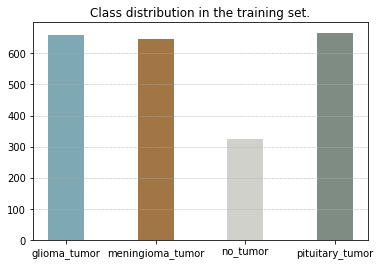

In [102]:
tumours.shuffleData(mode='training')
tumours.getClassDistribution(mode='training', visualize=True)

## Phase1
---

### 1. Convert Images to 2D numpy array and back. [Show examples]

<class 'numpy.ndarray'>
(180, 180, 1)



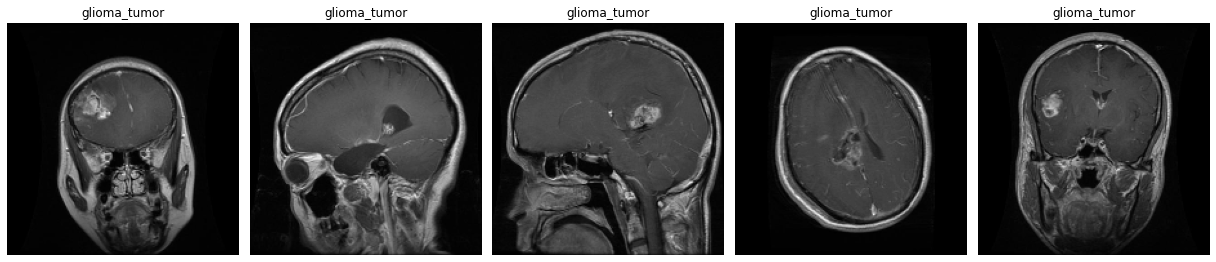

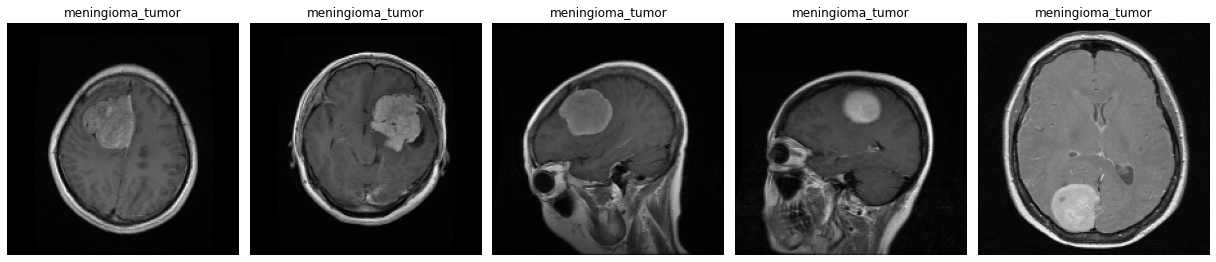

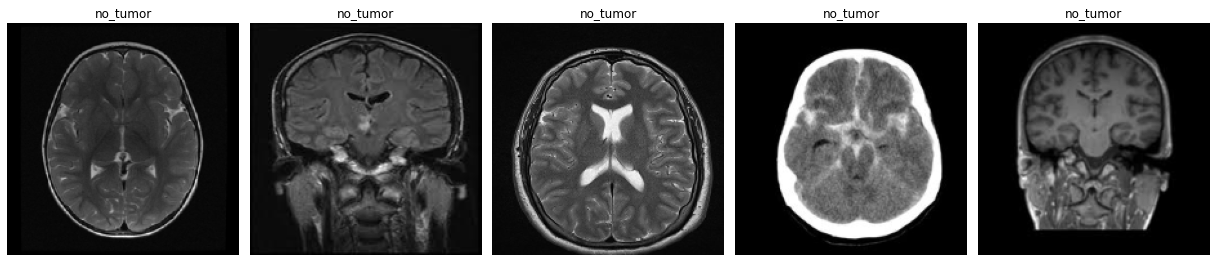

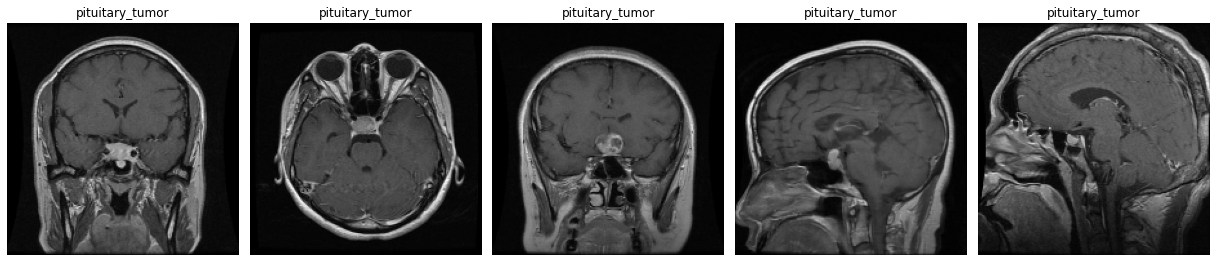

In [117]:
# Conversion to 2D numpy array
img = tumours.getRandomImage()
print(type(img))
print(img.shape)
print()

# And back
for key in tumours.labels:
    figure, axes = pyplot.subplots(1, 5, figsize=(17,17))
    for axis in axes.flatten():
        img = tumours.getRandomImage(mode='training', label=key)
        axis.imshow(img, cmap='gray')
        axis.set_title(key)
        axis.axis('off')
        pyplot.tight_layout()

### 2. Set up a basic CNN network to classify different tumor types. 

In [ ]:
BaseModel = CNNModel()
BaseModel.describe()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Conv2D)              (None, 128, 128, 8)       80        
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 16)        1168      
                                                                 
 pool1 (MaxPooling2D)        (None, 32, 32, 16)        0         
                                                                 
 conv2 (Conv2D)              (None, 16, 16, 32)        4640      
                                                                 
 pool2 (MaxPooling2D)        (None, 8, 8, 32)          0         
                                                                 
 conv3 (Conv2D)              (None, 4, 4, 64)          18496     
                                                                 
 pool3 (MaxPooling2D)        (None, 2, 2, 64)        

In [118]:
%%time
BaseModel.train(
    tumours.x_train,
    tumours.y_train,
    validation_data=(tumours.x_val, tumours.y_val),
    batch_size=32,
    epochs=10,
    showProgress=True
)

Epoch 1/10
71/71 [==============================] - 6s 72ms/step - loss: 1.2104 - accuracy: 0.4495 - val_loss: 1.0843 - val_accuracy: 0.5174
Epoch 2/10
71/71 [==============================] - 5s 74ms/step - loss: 1.0021 - accuracy: 0.5673 - val_loss: 0.9858 - val_accuracy: 0.5987
Epoch 3/10
71/71 [==============================] - 5s 74ms/step - loss: 0.9015 - accuracy: 0.6370 - val_loss: 0.9317 - val_accuracy: 0.6020
Epoch 4/10
71/71 [==============================] - 5s 74ms/step - loss: 0.8437 - accuracy: 0.6551 - val_loss: 0.8773 - val_accuracy: 0.6269
Epoch 5/10
71/71 [==============================] - 5s 74ms/step - loss: 0.8012 - accuracy: 0.6665 - val_loss: 0.8412 - val_accuracy: 0.6766
Epoch 6/10
71/71 [==============================] - 5s 74ms/step - loss: 0.7568 - accuracy: 0.7168 - val_loss: 0.7867 - val_accuracy: 0.7065
Epoch 7/10
71/71 [==============================] - 5s 74ms/step - loss: 0.7062 - accuracy: 0.7530 - val_loss: 0.7590 - val_accuracy: 0.7280
Epoch 8/10
71

### 3. Report key metrics to quantify the performance of your neural network.

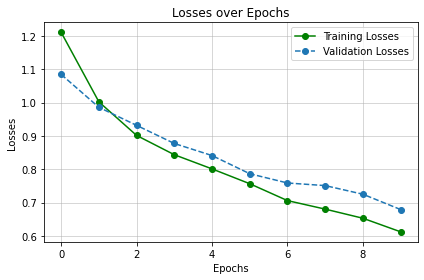

In [119]:
BaseModel.plotLosses()

#### Performance on the validation set.
---

classes  value_count  distribution
0      glioma_tumor          183      0.303483
1  meningioma_tumor          180      0.298507
2          no_tumor           75      0.124378
3   pituitary_tumor          165      0.273632

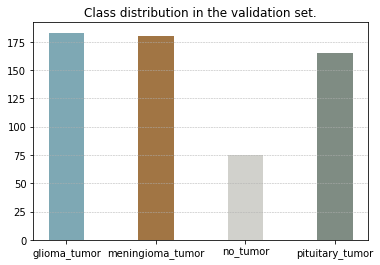

In [123]:
tumours.getClassDistribution(mode='validation', visualize=True)

In [124]:
BaseModel.evaluate()


Confusion Matrix:

             labels  glioma_tumor  meningioma_tumor  no_tumor  pituitary_tumor
0      glioma_tumor           130                49         1                3
1  meningioma_tumor            28               114        25               13
2          no_tumor             1                 7        60                7
3   pituitary_tumor             3                 2         3              157

Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.71      0.75       183
           1       0.66      0.63      0.65       180
           2       0.67      0.80      0.73        75
           3       0.87      0.95      0.91       165

    accuracy                           0.76       603
   macro avg       0.75      0.77      0.76       603
weighted avg       0.76      0.76      0.76       603



#### Performance on test set.
---

classes  value_count  distribution
0      glioma_tumor          100      0.253807
1  meningioma_tumor          115      0.291878
2          no_tumor          105      0.266497
3   pituitary_tumor           74      0.187817

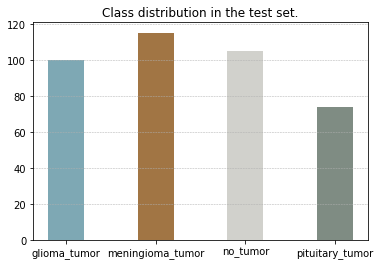

In [120]:
tumours.getClassDistribution(mode='test', visualize=True)

In [122]:
BaseModel.finalTest()


Confusion Matrix:

             labels  glioma_tumor  meningioma_tumor  no_tumor  pituitary_tumor
0      glioma_tumor             9                10        69               12
1  meningioma_tumor             1                10        97                7
2          no_tumor             0                 8        85               12
3   pituitary_tumor             1                13        36               24

Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.09      0.16       100
           1       0.24      0.09      0.13       115
           2       0.30      0.81      0.43       105
           3       0.44      0.32      0.37        74

    accuracy                           0.32       394
   macro avg       0.45      0.33      0.27       394
weighted avg       0.44      0.32      0.26       394



* The base model has a fairly good validation accuracy but the test  
accuracy is really low.

### 4. Set up a hyperparameter tuning mechanism

Set up a HP tuning mechanism to improve your performance metrics.  
Report performance on multiple scenarios tested. Different number  
of neurons/filter sizes? [At least 3 different types of hyperparams    
should be tested with at least 3 different values]

##### Test 0: Batch Size

CPU times: user 4min 59s, sys: 4.79 s, total: 5min 4s
Wall time: 52.5 s


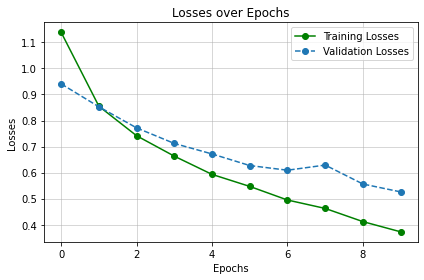

In [128]:
%%time
# Same architecture as the base model
alpha = CNNModel() 
alpha.train(
    tumours.x_train, tumours.y_train,
    epochs=10,
    batch_size=16,
    validation_data=(tumours.x_val, tumours.y_val)
)
alpha.plotLosses()

In [129]:
alpha.evaluate()


Confusion Matrix:

             labels  glioma_tumor  meningioma_tumor  no_tumor  pituitary_tumor
0      glioma_tumor           143                33         3                4
1  meningioma_tumor            32               122        12               14
2          no_tumor             5                13        53                4
3   pituitary_tumor             4                 2         2              157

Classification Report:

              precision    recall  f1-score   support

           0       0.78      0.78      0.78       183
           1       0.72      0.68      0.70       180
           2       0.76      0.71      0.73        75
           3       0.88      0.95      0.91       165

    accuracy                           0.79       603
   macro avg       0.78      0.78      0.78       603
weighted avg       0.78      0.79      0.79       603



* Reducing the batch size by half improved the f1 score by 2%.


Confusion Matrix:

             labels  glioma_tumor  meningioma_tumor  no_tumor  pituitary_tumor
0      glioma_tumor           141                32         0               10
1  meningioma_tumor            14               128        11               27
2          no_tumor             2                10        56                7
3   pituitary_tumor             0                 3         0              162

Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.77      0.83       183
           1       0.74      0.71      0.73       180
           2       0.84      0.75      0.79        75
           3       0.79      0.98      0.87       165

    accuracy                           0.81       603
   macro avg       0.82      0.80      0.80       603
weighted avg       0.81      0.81      0.81       603

CPU times: user 5min 1s, sys: 6.8 s, total: 5min 8s
Wall time: 1min


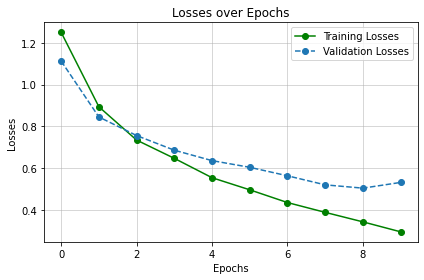

In [130]:
%%time
bravo = CNNModel() 
bravo.train(
    tumours.x_train, tumours.y_train,
    epochs=10,
    batch_size=8,
    validation_data=(tumours.x_val, tumours.y_val)
)
bravo.plotLosses()

bravo.makePrediction(tumours.x_val)
bravo.getConfusionMatrix(tumours.y_val)
bravo.getClassificationReport(tumours.y_val)


Confusion Matrix:

             labels  glioma_tumor  meningioma_tumor  no_tumor  pituitary_tumor
0      glioma_tumor           130                50         0                3
1  meningioma_tumor            20               134        13               13
2          no_tumor             3                24        47                1
3   pituitary_tumor             3                10         0              152

Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.71      0.77       183
           1       0.61      0.74      0.67       180
           2       0.78      0.63      0.70        75
           3       0.90      0.92      0.91       165

    accuracy                           0.77       603
   macro avg       0.78      0.75      0.76       603
weighted avg       0.78      0.77      0.77       603

CPU times: user 5min 3s, sys: 8.57 s, total: 5min 12s
Wall time: 49.5 s


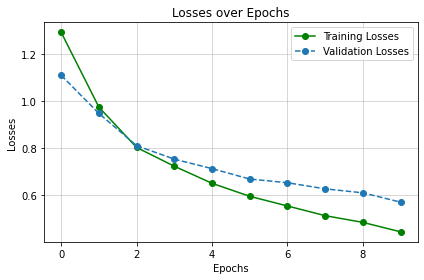

In [135]:
%%time
charlie = CNNModel() 
charlie.train(
    tumours.x_train, tumours.y_train,
    epochs=10,
    batch_size=64,
    validation_data=(tumours.x_val, tumours.y_val)
)
charlie.plotLosses()
charlie.evaluate()

Decrease depth and increase the number of epochs.

Epoch 1/20
36/36 [==============================] - 5s 122ms/step - loss: 1.2262 - accuracy: 0.4693 - val_loss: 1.1171 - val_accuracy: 0.5307
Epoch 2/20
36/36 [==============================] - 5s 142ms/step - loss: 1.0356 - accuracy: 0.5602 - val_loss: 1.0060 - val_accuracy: 0.5589
Epoch 3/20
36/36 [==============================] - 5s 140ms/step - loss: 0.9210 - accuracy: 0.6123 - val_loss: 0.9106 - val_accuracy: 0.5954
Epoch 4/20
36/36 [==============================] - 5s 138ms/step - loss: 0.8415 - accuracy: 0.6409 - val_loss: 0.8419 - val_accuracy: 0.6468
Epoch 5/20
36/36 [==============================] - 5s 137ms/step - loss: 0.7401 - accuracy: 0.7049 - val_loss: 0.7630 - val_accuracy: 0.6882
Epoch 6/20
36/36 [==============================] - 5s 137ms/step - loss: 0.6563 - accuracy: 0.7618 - val_loss: 0.7440 - val_accuracy: 0.7197
Epoch 7/20
36/36 [==============================] - 5s 136ms/step - loss: 0.6185 - accuracy: 0.7724 - val_loss: 0.7215 - val_accuracy: 0.7015
Epoch 

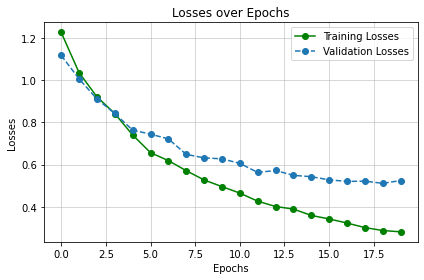

In [137]:
%%time
delta = CNNModel(depth=2) 
delta.train(
    tumours.x_train, tumours.y_train,
    epochs=20,
    batch_size=64,
    validation_data=(tumours.x_val, tumours.y_val),
    showProgress=True
)
delta.plotLosses()
delta.evaluate()

* Increasing the number of epochs seemed to have a positive affect on  
the overall model performance, although the computation time was greater.


Confusion Matrix:

             labels  glioma_tumor  meningioma_tumor  no_tumor  pituitary_tumor
0      glioma_tumor           142                37         0                4
1  meningioma_tumor             9               150        11               10
2          no_tumor             2                10        62                1
3   pituitary_tumor             1                 5         1              158

Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.78      0.84       183
           1       0.74      0.83      0.79       180
           2       0.84      0.83      0.83        75
           3       0.91      0.96      0.93       165

    accuracy                           0.85       603
   macro avg       0.85      0.85      0.85       603
weighted avg       0.86      0.85      0.85       603

CPU times: user 12min 43s, sys: 15.1 s, total: 12min 58s
Wall time: 2min 2s


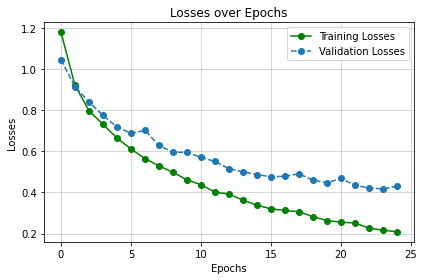

In [138]:
%%time
echo = CNNModel(depth=2) 
echo.train(
    tumours.x_train, tumours.y_train,
    epochs=25,
    batch_size=64,
    validation_data=(tumours.x_val, tumours.y_val),
)
echo.plotLosses()
echo.evaluate()

In [139]:
echo.describe()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Conv2D)              (None, 128, 128, 8)       80        
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 16)        1168      
                                                                 
 pool1 (MaxPooling2D)        (None, 32, 32, 16)        0         
                                                                 
 conv2 (Conv2D)              (None, 16, 16, 32)        4640      
                                                                 
 pool2 (MaxPooling2D)        (None, 8, 8, 32)          0         
                                                                 
 flat3 (Flatten)             (None, 2048)              0         
                                                                 
 dense4 (Dense)              (None, 8)               

##### Test 1: Filters, kernels and strides.

Epoch 1/10
23/23 [==============================] - 9s 398ms/step - loss: 1.3223 - accuracy: 0.3736 - val_loss: 1.1929 - val_accuracy: 0.5041
Epoch 2/10
23/23 [==============================] - 10s 422ms/step - loss: 1.1720 - accuracy: 0.5112 - val_loss: 1.1169 - val_accuracy: 0.5207
Epoch 3/10
23/23 [==============================] - 10s 426ms/step - loss: 1.0818 - accuracy: 0.5271 - val_loss: 1.0754 - val_accuracy: 0.5257
Epoch 4/10
23/23 [==============================] - 9s 413ms/step - loss: 1.0299 - accuracy: 0.5452 - val_loss: 1.0222 - val_accuracy: 0.5423
Epoch 5/10
23/23 [==============================] - 10s 417ms/step - loss: 0.9728 - accuracy: 0.5434 - val_loss: 0.9607 - val_accuracy: 0.5489
Epoch 6/10
23/23 [==============================] - 10s 415ms/step - loss: 0.9213 - accuracy: 0.5584 - val_loss: 0.9402 - val_accuracy: 0.5755
Epoch 7/10
23/23 [==============================] - 10s 424ms/step - loss: 0.8912 - accuracy: 0.6299 - val_loss: 0.8955 - val_accuracy: 0.6534
E

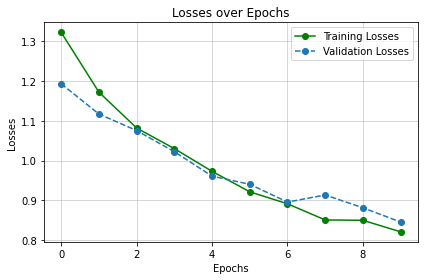

In [141]:
%%time
foxtrot = CNNModel(filters=16) 

foxtrot.train(
    tumours.x_train, tumours.y_train,
    epochs=10,
    batch_size=100,
    validation_data=(tumours.x_val, tumours.y_val),
    showProgress=True
)
foxtrot.plotLosses()
foxtrot.evaluate()

In [144]:
tumours.shuffleData()

Epoch 1/15
71/71 [==============================] - 56s 781ms/step - loss: 1.1955 - accuracy: 0.4477 - val_loss: 1.1225 - val_accuracy: 0.5489
Epoch 2/15
71/71 [==============================] - 55s 772ms/step - loss: 1.0303 - accuracy: 0.5761 - val_loss: 1.0076 - val_accuracy: 0.5920
Epoch 3/15
71/71 [==============================] - 55s 775ms/step - loss: 0.8882 - accuracy: 0.6392 - val_loss: 0.8913 - val_accuracy: 0.6285
Epoch 4/15
71/71 [==============================] - 54s 763ms/step - loss: 0.8010 - accuracy: 0.6811 - val_loss: 0.7885 - val_accuracy: 0.7081
Epoch 5/15
71/71 [==============================] - 55s 771ms/step - loss: 0.6914 - accuracy: 0.7481 - val_loss: 0.7364 - val_accuracy: 0.7181
Epoch 6/15
71/71 [==============================] - 54s 761ms/step - loss: 0.6466 - accuracy: 0.7653 - val_loss: 0.6810 - val_accuracy: 0.7413
Epoch 7/15
71/71 [==============================] - 54s 763ms/step - loss: 0.5674 - accuracy: 0.8019 - val_loss: 0.6084 - val_accuracy: 0.7778

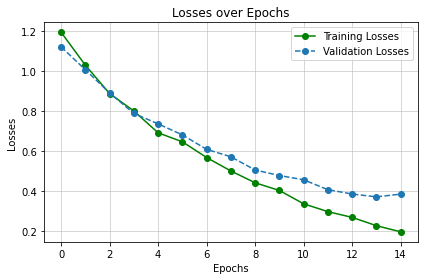

In [145]:
golf = CNNModel(filters=64, strides=2) 

golf.train(
    tumours.x_train, tumours.y_train,
    epochs=15,
    validation_data=(tumours.x_val, tumours.y_val),
    showProgress=True
)
golf.plotLosses()
golf.evaluate()

Epoch 1/10
71/71 [==============================] - 54s 764ms/step - loss: 0.1665 - accuracy: 0.9727 - val_loss: 0.3495 - val_accuracy: 0.8905
Epoch 2/10
71/71 [==============================] - 54s 763ms/step - loss: 0.1568 - accuracy: 0.9713 - val_loss: 0.3368 - val_accuracy: 0.8922
Epoch 3/10
71/71 [==============================] - 54s 765ms/step - loss: 0.1246 - accuracy: 0.9819 - val_loss: 0.3584 - val_accuracy: 0.8789
Epoch 4/10
71/71 [==============================] - 54s 764ms/step - loss: 0.1076 - accuracy: 0.9841 - val_loss: 0.3263 - val_accuracy: 0.8922
Epoch 5/10
71/71 [==============================] - 54s 764ms/step - loss: 0.0990 - accuracy: 0.9859 - val_loss: 0.3496 - val_accuracy: 0.8955
Epoch 6/10
71/71 [==============================] - 54s 763ms/step - loss: 0.0838 - accuracy: 0.9876 - val_loss: 0.3559 - val_accuracy: 0.8939
Epoch 7/10
71/71 [==============================] - 54s 766ms/step - loss: 0.0763 - accuracy: 0.9899 - val_loss: 0.3284 - val_accuracy: 0.8972

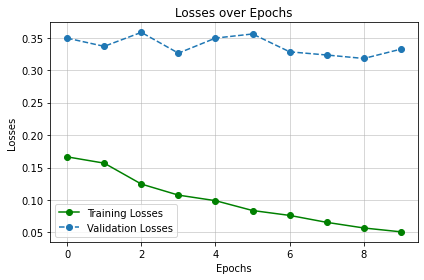

In [146]:
%%time
golf.train(
    tumours.x_train, tumours.y_train,
    epochs=10,
    validation_data=(tumours.x_val, tumours.y_val),
    showProgress=True
)
golf.plotLosses()
golf.evaluate()

In [165]:
golf.finalTest()


Confusion Matrix:

             labels  glioma_tumor  meningioma_tumor  no_tumor  pituitary_tumor
0      glioma_tumor            18                37        38                7
1  meningioma_tumor             1               101        10                3
2          no_tumor             0                 1       103                1
3   pituitary_tumor            12                15        23               24

Classification Report:

              precision    recall  f1-score   support

           0       0.58      0.18      0.27       100
           1       0.66      0.88      0.75       115
           2       0.59      0.98      0.74       105
           3       0.69      0.32      0.44        74

    accuracy                           0.62       394
   macro avg       0.63      0.59      0.55       394
weighted avg       0.63      0.62      0.57       394



In [148]:
hotel = CNNModel(filters=8, kernel_size=5) 
hotel.describe()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Conv2D)              (None, 128, 128, 8)       208       
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 16)        3216      
                                                                 
 pool1 (MaxPooling2D)        (None, 32, 32, 16)        0         
                                                                 
 conv2 (Conv2D)              (None, 16, 16, 32)        12832     
                                                                 
 pool2 (MaxPooling2D)        (None, 8, 8, 32)          0         
                                                                 
 conv3 (Conv2D)              (None, 4, 4, 64)          51264     
                                                                 
 pool3 (MaxPooling2D)        (None, 2, 2, 64)        

Epoch 1/15
71/71 [==============================] - 9s 123ms/step - loss: 1.1621 - accuracy: 0.4905 - val_loss: 1.0103 - val_accuracy: 0.5589
Epoch 2/15
71/71 [==============================] - 11s 156ms/step - loss: 0.9611 - accuracy: 0.5977 - val_loss: 0.8830 - val_accuracy: 0.6567
Epoch 3/15
71/71 [==============================] - 11s 160ms/step - loss: 0.8204 - accuracy: 0.6842 - val_loss: 0.7854 - val_accuracy: 0.7131
Epoch 4/15
71/71 [==============================] - 11s 159ms/step - loss: 0.6877 - accuracy: 0.7658 - val_loss: 0.7012 - val_accuracy: 0.7297
Epoch 5/15
71/71 [==============================] - 11s 157ms/step - loss: 0.6135 - accuracy: 0.7984 - val_loss: 0.6553 - val_accuracy: 0.7512
Epoch 6/15
71/71 [==============================] - 11s 158ms/step - loss: 0.5233 - accuracy: 0.8386 - val_loss: 0.5843 - val_accuracy: 0.7894
Epoch 7/15
71/71 [==============================] - 12s 165ms/step - loss: 0.4584 - accuracy: 0.8708 - val_loss: 0.5037 - val_accuracy: 0.8292


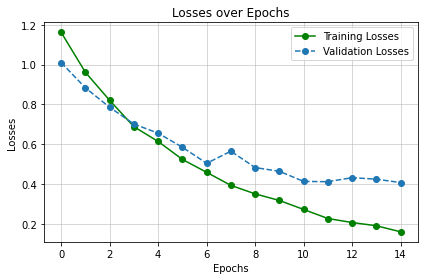

In [149]:
hotel.train(
    tumours.x_train, tumours.y_train,
    epochs=15,
    validation_data=(tumours.x_val, tumours.y_val),
    showProgress=True
)
hotel.plotLosses()
hotel.evaluate()

Epoch 1/15
71/71 [==============================] - 12s 167ms/step - loss: 1.3586 - accuracy: 0.2894 - val_loss: 1.3390 - val_accuracy: 0.2985
Epoch 2/15
71/71 [==============================] - 14s 202ms/step - loss: 1.3516 - accuracy: 0.2770 - val_loss: 1.3394 - val_accuracy: 0.2736
Epoch 3/15
71/71 [==============================] - 14s 200ms/step - loss: 1.3524 - accuracy: 0.2691 - val_loss: 1.3393 - val_accuracy: 0.2985
Epoch 4/15
71/71 [==============================] - 14s 199ms/step - loss: 1.3519 - accuracy: 0.2814 - val_loss: 1.3421 - val_accuracy: 0.2736
Epoch 5/15
71/71 [==============================] - 14s 201ms/step - loss: 1.3512 - accuracy: 0.2964 - val_loss: 1.3389 - val_accuracy: 0.3035
Epoch 6/15
71/71 [==============================] - 14s 200ms/step - loss: 1.3512 - accuracy: 0.2867 - val_loss: 1.3396 - val_accuracy: 0.2736
Epoch 7/15
71/71 [==============================] - 14s 201ms/step - loss: 1.3516 - accuracy: 0.2748 - val_loss: 1.3393 - val_accuracy: 0.2736

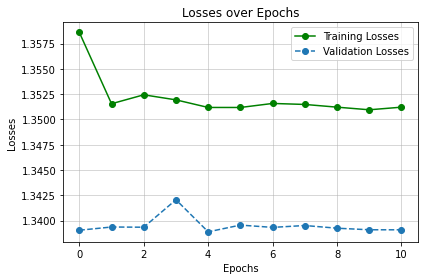

In [156]:
%%time
india = CNNModel(filters=4, kernel_size=7) 
india.train(
    tumours.x_train, tumours.y_train,
    epochs=15,
    validation_data=(tumours.x_val, tumours.y_val),
    showProgress=True
)
india.plotLosses()
india.evaluate()

In [157]:
india.describe()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Conv2D)              (None, 128, 128, 4)       200       
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 8)         1576      
                                                                 
 pool1 (MaxPooling2D)        (None, 32, 32, 8)         0         
                                                                 
 conv2 (Conv2D)              (None, 16, 16, 16)        6288      
                                                                 
 pool2 (MaxPooling2D)        (None, 8, 8, 16)          0         
                                                                 
 conv3 (Conv2D)              (None, 4, 4, 32)          25120     
                                                                 
 pool3 (MaxPooling2D)        (None, 2, 2, 32)        

##### Test 2: Optimizers and Learning Rates

Epoch 1/30
77/77 [==============================] - 40s 517ms/step - loss: 1.3173 - accuracy: 0.3788 - val_loss: 1.1898 - val_accuracy: 0.4756
Epoch 2/30
77/77 [==============================] - 41s 532ms/step - loss: 1.1409 - accuracy: 0.5035 - val_loss: 1.2631 - val_accuracy: 0.4548
Epoch 3/30
77/77 [==============================] - 41s 527ms/step - loss: 1.0174 - accuracy: 0.5433 - val_loss: 1.1692 - val_accuracy: 0.4687
Epoch 4/30
77/77 [==============================] - 41s 529ms/step - loss: 0.9259 - accuracy: 0.5970 - val_loss: 0.9188 - val_accuracy: 0.6450
Epoch 5/30
77/77 [==============================] - 41s 527ms/step - loss: 0.8305 - accuracy: 0.6544 - val_loss: 1.1940 - val_accuracy: 0.4200
Epoch 6/30
77/77 [==============================] - 41s 528ms/step - loss: 0.7749 - accuracy: 0.6667 - val_loss: 0.7974 - val_accuracy: 0.6497
Epoch 7/30
77/77 [==============================] - 41s 532ms/step - loss: 0.7038 - accuracy: 0.7048 - val_loss: 0.8204 - val_accuracy: 0.6288

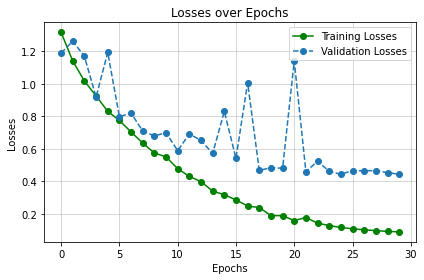

In [159]:
%%time
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.1,
    decay_steps=100,
    decay_rate=0.9)

juliet = CNNModel(filters=16, kernel_size=5, optimizer=SGD(learning_rate=lr_schedule)) 
juliet.train(
    tumours.x_train, tumours.y_train,
    epochs=30,
    validation_data=(tumours.x_val, tumours.y_val),
    showProgress=True
)
juliet.plotLosses()
juliet.evaluate()

* Running the final test on models with good val scores above did not  
seem to produce results anywhere close. So I decided to increase  
the validation ratio to 30%.

Epoch 1/30
63/63 [==============================] - 24s 376ms/step - loss: 1.3563 - accuracy: 0.3006 - val_loss: 1.3371 - val_accuracy: 0.3101
Epoch 2/30
63/63 [==============================] - 23s 372ms/step - loss: 1.3330 - accuracy: 0.3713 - val_loss: 1.2934 - val_accuracy: 0.4100
Epoch 3/30
63/63 [==============================] - 24s 378ms/step - loss: 1.2280 - accuracy: 0.5062 - val_loss: 1.2537 - val_accuracy: 0.4727
Epoch 4/30
63/63 [==============================] - 24s 379ms/step - loss: 1.0868 - accuracy: 0.5306 - val_loss: 1.0815 - val_accuracy: 0.4832
Epoch 5/30
63/63 [==============================] - 23s 370ms/step - loss: 0.9817 - accuracy: 0.5814 - val_loss: 1.0251 - val_accuracy: 0.5203
Epoch 6/30
63/63 [==============================] - 24s 382ms/step - loss: 0.9030 - accuracy: 0.6237 - val_loss: 0.9265 - val_accuracy: 0.5923
Epoch 7/30
63/63 [==============================] - 23s 370ms/step - loss: 0.8046 - accuracy: 0.6685 - val_loss: 0.8841 - val_accuracy: 0.6074

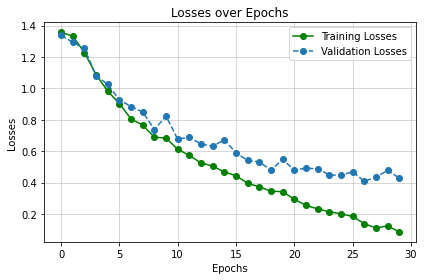

In [162]:
%%time
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.1,
    decay_steps=1000,
    decay_rate=0.9)

kilo = CNNModel(filters=20, kernel_size=3, optimizer=SGD(learning_rate=lr_schedule)) 
kilo.train(
    tumours.x_train, tumours.y_train,
    epochs=30,
    validation_data=(tumours.x_val, tumours.y_val),
    showProgress=True
)
kilo.plotLosses()
kilo.evaluate()

In [163]:
kilo.finalTest()


Confusion Matrix:

             labels  glioma_tumor  meningioma_tumor  no_tumor  pituitary_tumor
0      glioma_tumor            22                34        35                9
1  meningioma_tumor             2               100        10                3
2          no_tumor             3                 5        94                3
3   pituitary_tumor             2                24         1               47

Classification Report:

              precision    recall  f1-score   support

           0       0.76      0.22      0.34       100
           1       0.61      0.87      0.72       115
           2       0.67      0.90      0.77       105
           3       0.76      0.64      0.69        74

    accuracy                           0.67       394
   macro avg       0.70      0.65      0.63       394
weighted avg       0.69      0.67      0.63       394



* Increasing the validation ratio did increase the preformance on the  
test set to a certain degree for analogouse resutls on the validation  
set.

Epoch 1/30
16/16 [==============================] - 27s 2s/step - loss: 1.3555 - accuracy: 0.3071 - val_loss: 1.3473 - val_accuracy: 0.2695
Epoch 2/30
16/16 [==============================] - 26s 2s/step - loss: 1.3120 - accuracy: 0.3863 - val_loss: 1.1961 - val_accuracy: 0.4541
Epoch 3/30
16/16 [==============================] - 26s 2s/step - loss: 1.1874 - accuracy: 0.4559 - val_loss: 1.1116 - val_accuracy: 0.5099
Epoch 4/30
16/16 [==============================] - 26s 2s/step - loss: 1.1005 - accuracy: 0.4813 - val_loss: 1.1183 - val_accuracy: 0.4692
Epoch 5/30
16/16 [==============================] - 26s 2s/step - loss: 0.9783 - accuracy: 0.5565 - val_loss: 1.3355 - val_accuracy: 0.4657
Epoch 6/30
16/16 [==============================] - 26s 2s/step - loss: 0.9466 - accuracy: 0.5809 - val_loss: 0.9994 - val_accuracy: 0.5947
Epoch 7/30
16/16 [==============================] - 26s 2s/step - loss: 0.8778 - accuracy: 0.6207 - val_loss: 0.8582 - val_accuracy: 0.6249
Epoch 8/30
16/16 [==

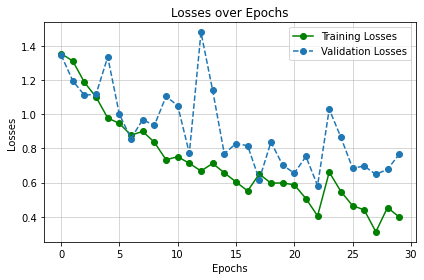

In [170]:
%%time
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.9,
    decay_steps=1000,
    decay_rate=0.9)

lima = CNNModel(filters=24, kernel_size=3,
                optimizer=SGD(learning_rate=lr_schedule)) 
lima.train(
    tumours.x_train, tumours.y_train,
    epochs=30,
    batch_size=32*4,
    validation_data=(tumours.x_val, tumours.y_val),
    showProgress=True
)
lima.plotLosses()
lima.evaluate()

Epoch 1/40
63/63 [==============================] - 16s 250ms/step - loss: 1.2935 - accuracy: 0.3708 - val_loss: 1.2652 - val_accuracy: 0.4518
Epoch 2/40
63/63 [==============================] - 18s 282ms/step - loss: 1.0849 - accuracy: 0.5157 - val_loss: 1.0480 - val_accuracy: 0.5343
Epoch 3/40
63/63 [==============================] - 18s 281ms/step - loss: 0.9443 - accuracy: 0.5998 - val_loss: 0.9628 - val_accuracy: 0.5935
Epoch 4/40
63/63 [==============================] - 18s 280ms/step - loss: 0.8500 - accuracy: 0.6277 - val_loss: 1.0495 - val_accuracy: 0.5157
Epoch 5/40
63/63 [==============================] - 18s 278ms/step - loss: 0.7778 - accuracy: 0.6605 - val_loss: 0.8519 - val_accuracy: 0.6469
Epoch 6/40
63/63 [==============================] - 18s 280ms/step - loss: 0.7300 - accuracy: 0.6819 - val_loss: 0.8128 - val_accuracy: 0.6562
Epoch 7/40
63/63 [==============================] - 18s 280ms/step - loss: 0.6721 - accuracy: 0.7178 - val_loss: 0.8073 - val_accuracy: 0.6655

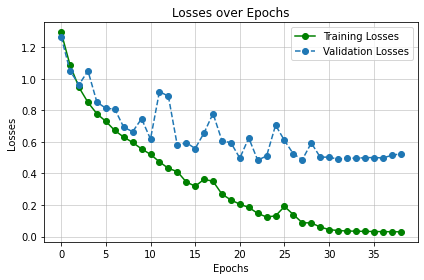

In [171]:
%%time
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.2,
    decay_steps=10000,
    decay_rate=0.8)

mike = CNNModel(filters=16, optimizer=SGD(learning_rate=lr_schedule)) 
mike.train(
    tumours.x_train, tumours.y_train,
    epochs=40,
    validation_data=(tumours.x_val, tumours.y_val),
    showProgress=True
)
mike.plotLosses()
mike.evaluate()

Epoch 1/10
63/63 [==============================] - 8s 129ms/step - loss: 1.3110 - accuracy: 0.3728 - val_loss: 1.1624 - val_accuracy: 0.5052
Epoch 2/10
63/63 [==============================] - 10s 163ms/step - loss: 1.1499 - accuracy: 0.5241 - val_loss: 1.1390 - val_accuracy: 0.5029
Epoch 3/10
63/63 [==============================] - 10s 161ms/step - loss: 1.0877 - accuracy: 0.5441 - val_loss: 1.0888 - val_accuracy: 0.5285
Epoch 4/10
63/63 [==============================] - 10s 162ms/step - loss: 1.0391 - accuracy: 0.5669 - val_loss: 1.0616 - val_accuracy: 0.5412
Epoch 5/10
63/63 [==============================] - 10s 161ms/step - loss: 0.9877 - accuracy: 0.5893 - val_loss: 1.0004 - val_accuracy: 0.5830
Epoch 6/10
63/63 [==============================] - 10s 161ms/step - loss: 0.9282 - accuracy: 0.6227 - val_loss: 0.9480 - val_accuracy: 0.6039
Epoch 7/10
63/63 [==============================] - 10s 161ms/step - loss: 0.8746 - accuracy: 0.6476 - val_loss: 0.8921 - val_accuracy: 0.6504


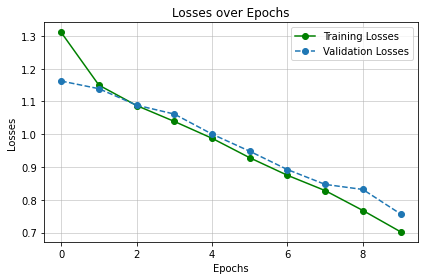

In [173]:
%%time
november = CNNModel(depth=4, optimizer=Adam(learning_rate=0.0008))
november.train(
    tumours.x_train, tumours.y_train,
    validation_data=(tumours.x_val, tumours.y_val),
    epochs=10,
    showProgress=True
)
november.plotLosses()
november.evaluate()

Epoch 1/30
63/63 [==============================] - 10s 154ms/step - loss: 1.3427 - accuracy: 0.3136 - val_loss: 1.3039 - val_accuracy: 0.4774
Epoch 2/30
63/63 [==============================] - 10s 162ms/step - loss: 1.2401 - accuracy: 0.5177 - val_loss: 1.2225 - val_accuracy: 0.4994
Epoch 3/30
63/63 [==============================] - 10s 161ms/step - loss: 1.1917 - accuracy: 0.5326 - val_loss: 1.1882 - val_accuracy: 0.5145
Epoch 4/30
63/63 [==============================] - 10s 161ms/step - loss: 1.1656 - accuracy: 0.5376 - val_loss: 1.1715 - val_accuracy: 0.5203
Epoch 5/30
63/63 [==============================] - 10s 164ms/step - loss: 1.1290 - accuracy: 0.5495 - val_loss: 1.1205 - val_accuracy: 0.5470
Epoch 6/30
63/63 [==============================] - 10s 162ms/step - loss: 1.1087 - accuracy: 0.5495 - val_loss: 1.1092 - val_accuracy: 0.5563
Epoch 7/30
63/63 [==============================] - 10s 161ms/step - loss: 1.0788 - accuracy: 0.5660 - val_loss: 1.0765 - val_accuracy: 0.5575

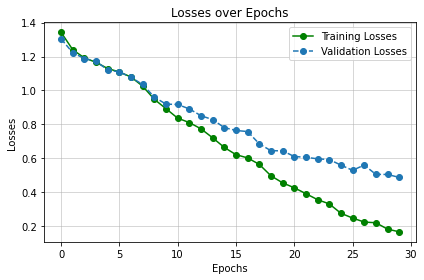

In [182]:
%%time
oscar = CNNModel(depth=4, optimizer=Adam(learning_rate=0.0009))
oscar.train(
    tumours.x_train, tumours.y_train,
    validation_data=(tumours.x_val, tumours.y_val),
    epochs=30,
    showProgress=True
)
oscar.plotLosses()
oscar.evaluate()

In [185]:
oscar.finalTest()


Confusion Matrix:

             labels  glioma_tumor  meningioma_tumor  no_tumor  pituitary_tumor
0      glioma_tumor            22                40        29                9
1  meningioma_tumor             0                92        15                8
2          no_tumor             3                 5        93                4
3   pituitary_tumor             0                38         1               35

Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.22      0.35       100
           1       0.53      0.80      0.63       115
           2       0.67      0.89      0.77       105
           3       0.62      0.47      0.54        74

    accuracy                           0.61       394
   macro avg       0.68      0.59      0.57       394
weighted avg       0.67      0.61      0.58       394



Epoch 1/20
63/63 [==============================] - 40s 636ms/step - loss: 1.1991 - accuracy: 0.4385 - val_loss: 1.1073 - val_accuracy: 0.5447
Epoch 2/20
63/63 [==============================] - 41s 645ms/step - loss: 1.0133 - accuracy: 0.5859 - val_loss: 1.0658 - val_accuracy: 0.5552
Epoch 3/20
63/63 [==============================] - 41s 647ms/step - loss: 0.9236 - accuracy: 0.6242 - val_loss: 0.9786 - val_accuracy: 0.5772
Epoch 4/20
63/63 [==============================] - 40s 636ms/step - loss: 0.8601 - accuracy: 0.6635 - val_loss: 0.8711 - val_accuracy: 0.6678
Epoch 5/20
63/63 [==============================] - 40s 635ms/step - loss: 0.8104 - accuracy: 0.6854 - val_loss: 0.8679 - val_accuracy: 0.6225
Epoch 6/20
63/63 [==============================] - 40s 637ms/step - loss: 0.7629 - accuracy: 0.7068 - val_loss: 0.8219 - val_accuracy: 0.6609
Epoch 7/20
63/63 [==============================] - 40s 638ms/step - loss: 0.7311 - accuracy: 0.7218 - val_loss: 0.7774 - val_accuracy: 0.6911

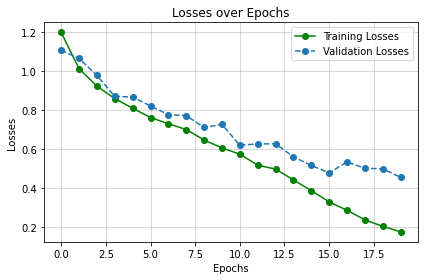

In [187]:
%%time
papa = CNNModel(depth=4, filters=32, optimizer=Adam(learning_rate=0.0009))
papa.train(
    tumours.x_train, tumours.y_train,
    validation_data=(tumours.x_val, tumours.y_val),
    epochs=20,
    showProgress=True
)
papa.plotLosses()
papa.evaluate()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Conv2D)              (None, 180, 180, 8)       136       
                                                                 
 conv1 (Conv2D)              (None, 90, 90, 16)        2064      
                                                                 
 drop1 (Dropout)             (None, 90, 90, 16)        0         
                                                                 
 pool1 (MaxPooling2D)        (None, 45, 45, 16)        0         
                                                                 
 conv2 (Conv2D)              (None, 23, 23, 32)        8224      
                                                                 
 drop2 (Dropout)             (None, 23, 23, 32)        0         
                                                                 
 pool2 (MaxPooling2D)        (None, 11, 11, 32)       

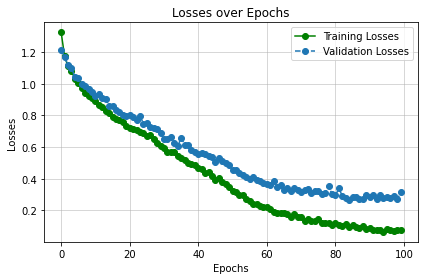

In [10]:
%%time
quebec = CNNModel(
    depth=3,
    kernel_size=4,
    filters=8,
    addDropouts=True,
    optimizer=Adam(learning_rate=0.0008)
)

quebec.describe()

quebec.train(
    tumours.x_train, tumours.y_train,
    validation_data=(tumours.x_val, tumours.y_val),
    epochs=100,
    showProgress=True
)

quebec.plotLosses()
quebec.evaluate()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Conv2D)              (None, 180, 180, 8)       208       
                                                                 
 conv1 (Conv2D)              (None, 90, 90, 16)        3216      
                                                                 
 drop1 (Dropout)             (None, 90, 90, 16)        0         
                                                                 
 pool1 (MaxPooling2D)        (None, 45, 45, 16)        0         
                                                                 
 conv2 (Conv2D)              (None, 23, 23, 32)        12832     
                                                                 
 drop2 (Dropout)             (None, 23, 23, 32)        0         
                                                                 
 pool2 (MaxPooling2D)        (None, 11, 11, 32)        0

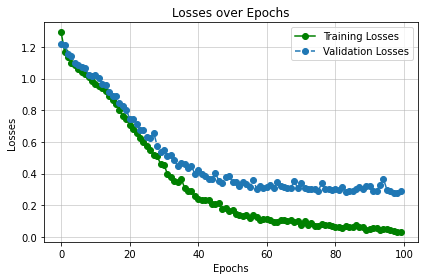

In [9]:
%%time
romeo = CNNModel(
    depth=3,
    kernel_size=5,
    filters=8,
    addDropouts=True,
    optimizer=Adam(learning_rate=0.0008)
)

romeo.describe()

romeo.train(
    tumours.x_train, tumours.y_train,
    validation_data=(tumours.x_val, tumours.y_val),
    batch_size=64,
    epochs=100,
    showProgress=True
)

romeo.plotLosses()
romeo.evaluate()

##### Cross-validation

In [11]:
sierra = CNNModel(
    depth=3,
    kernel_size=5,
    filters=8,
    addDropouts=True,
    optimizer=Adam(learning_rate=0.0008)
)

In [12]:
sierra.describe()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Conv2D)              (None, 180, 180, 8)       208       
                                                                 
 conv1 (Conv2D)              (None, 90, 90, 16)        3216      
                                                                 
 drop1 (Dropout)             (None, 90, 90, 16)        0         
                                                                 
 pool1 (MaxPooling2D)        (None, 45, 45, 16)        0         
                                                                 
 conv2 (Conv2D)              (None, 23, 23, 32)        12832     
                                                                 
 drop2 (Dropout)             (None, 23, 23, 32)        0         
                                                                 
 pool2 (MaxPooling2D)        (None, 11, 11, 32)       

###### Show casing different sets for cross-validation.

In [ ]:
%%time
folds = 5

for i in range(folds):
    tumours = Images(180, validation_ratio=0.2, random_state=None)
    # tumours.shuffleData(mode='training')
    # tumours.shuffleData(mode='validation')
    validation_data_points = tumours.y_val.shape[0]
    training_data_points = tumours.y_train.shape[0]
    print('Starting cross-validation in fold {}'.format(i))
    print('='*35, end='\n'*2)
    print(f'Training on {training_data_points} datapoints and validating in' \
          f'{validation_data_points}')
    print(numpy.argmax(tumours.y_val, axis=1))
    print()
        
    

###### Performing cross validation on 5 folds.

In [13]:
%%time
folds = 5

accuracy__ = numpy.zeros((folds))

for i in range(folds):
    tumours = Images(180, validation_ratio=0.2, random_state=None)
    tumours.shuffleData(mode='training')
    tumours.shuffleData(mode='validation')
    validation_data_points = tumours.y_val.shape[0]
    training_data_points = tumours.y_train.shape[0]
    print('#'*39)
    print(f'# Starting cross-validation in fold {i} #')
    print('#'*39, end='\n'*2)
    print(f'Training on {training_data_points} and validating in ' \
          f'{validation_data_points} datapoints.')
    print()
    
    print('Training in progress ...')
    
    sierra.train(
        tumours.x_train, tumours.y_train,
        validation_data=(tumours.x_val, tumours.y_val),
        batch_size=64,
        epochs=100,
    )

    print('Training complete! fetching performance report...')
    
    accuracy__[i] = max(sierra.getDataPoints(mode='accuracy'))
    sierra.makePrediction(tumours.x_val)
    sierra.getClassificationReport(tumours.y_val)

print(f'Mean accuracy : {numpy.mean(accuracy__)}')

#######################################
# Starting cross-validation in fold 0 #
#######################################

Training on 2296 and validating in 574 datapoints.

Training in progress ...
Training complete! fetching performance report...

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.88      0.93       162
           1       0.86      0.93      0.89       165
           2       0.93      0.90      0.92        92
           3       0.95      1.00      0.97       155

    accuracy                           0.93       574
   macro avg       0.93      0.93      0.93       574
weighted avg       0.93      0.93      0.93       574

#######################################
# Starting cross-validation in fold 1 #
#######################################

Training on 2296 and validating in 574 datapoints.

Training in progress ...
Training complete! fetching performance report...

Classification Report:

              preci

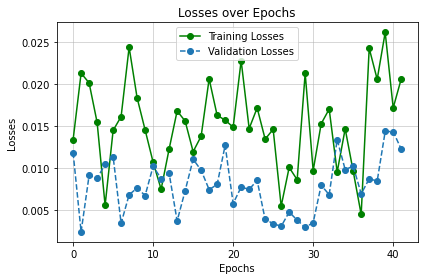

In [14]:
sierra.plotLosses()

In [15]:
sierra.finalTest()


Confusion Matrix:

             labels  glioma_tumor  meningioma_tumor  no_tumor  pituitary_tumor
0      glioma_tumor            18                33        46                3
1  meningioma_tumor             0               115         0                0
2          no_tumor             0                 0       105                0
3   pituitary_tumor             0                15         8               51

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.18      0.31       100
           1       0.71      1.00      0.83       115
           2       0.66      1.00      0.80       105
           3       0.94      0.69      0.80        74

    accuracy                           0.73       394
   macro avg       0.83      0.72      0.68       394
weighted avg       0.81      0.73      0.68       394



###### Performing cross-validation on 3 folds.

In [17]:
tango = CNNModel(
    depth=3,
    kernel_size=5,
    filters=8,
    addDropouts=True,
    optimizer=Adam(learning_rate=0.0008)
)

In [18]:
%%time
folds = 3

accuracy__ = numpy.zeros((folds))

for i in range(folds):
    tumours = Images(180, validation_ratio=0.3333, random_state=None)
    tumours.shuffleData(mode='training')
    tumours.shuffleData(mode='validation')
    # Datapoint counts
    validation_data_points = tumours.y_val.shape[0]
    training_data_points   = tumours.y_train.shape[0]
    print('#'*39)
    print(f'# Starting cross-validation in fold {i} #')
    print('#'*39, end='\n'*2)
    print(f'Training on {training_data_points} and validating in ' \
          f'{validation_data_points} datapoints.')
    print()
    
    print('Training in progress ...')
    
    tango.train(
        tumours.x_train, tumours.y_train,
        validation_data=(tumours.x_val, tumours.y_val),
        batch_size=64,
        epochs=100,
    )

    print('Training complete! fetching performance report...')
    
    accuracy__[i] = max(tango.getDataPoints(mode='accuracy'))
    tango.makePrediction(tumours.x_val)
    tango.getClassificationReport(tumours.y_val)

print(f'Mean accuracy : {numpy.mean(accuracy__)}')

#######################################
# Starting cross-validation in fold 0 #
#######################################

Training on 1913 and validating in 957 datapoints.

Training in progress ...
Training complete! fetching performance report...

Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.93      0.91       274
           1       0.89      0.85      0.87       275
           2       0.91      0.82      0.86       115
           3       0.94      0.98      0.96       293

    accuracy                           0.91       957
   macro avg       0.91      0.90      0.90       957
weighted avg       0.91      0.91      0.91       957

#######################################
# Starting cross-validation in fold 1 #
#######################################

Training on 1913 and validating in 957 datapoints.

Training in progress ...
Training complete! fetching performance report...

Classification Report:

              preci

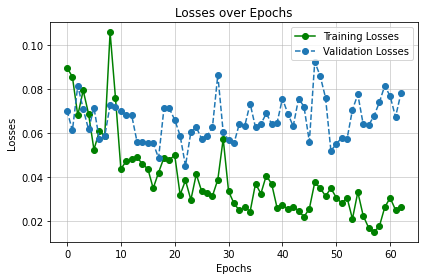

In [19]:
tango.plotLosses()

In [21]:
tango.finalTest()


Confusion Matrix:

             labels  glioma_tumor  meningioma_tumor  no_tumor  pituitary_tumor
0      glioma_tumor            19                51        24                6
1  meningioma_tumor             0               113         1                1
2          no_tumor             0                 3       101                1
3   pituitary_tumor             2                10        12               50

Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.19      0.31       100
           1       0.64      0.98      0.77       115
           2       0.73      0.96      0.83       105
           3       0.86      0.68      0.76        74

    accuracy                           0.72       394
   macro avg       0.78      0.70      0.67       394
weighted avg       0.77      0.72      0.67       394



* If your model isn't generalizing over the training, the test and the  
validation sets performing a cross-validation check definitely seems  
to help.

##### Test 3: Experimenting 

In [29]:
uniform = CNNModel(
    depth=4,
    kernel_size=3,
    filters=16,
    strides=2,
    optimizer=Adam()
)

uniform.describe()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Conv2D)              (None, 180, 180, 16)      160       
                                                                 
 conv1 (Conv2D)              (None, 90, 90, 32)        4640      
                                                                 
 pool1 (MaxPooling2D)        (None, 45, 45, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 23, 23, 64)        18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 11, 11, 64)        0         
                                                                 
 conv3 (Conv2D)              (None, 6, 6, 128)         73856     
                                                                 
 pool3 (MaxPooling2D)        (None, 3, 3, 128)        

Epoch 1/50
60/60 [==============================] - 10s 159ms/step - loss: 1.3704 - accuracy: 0.3586 - val_loss: 1.3035 - val_accuracy: 0.5016
Epoch 2/50
60/60 [==============================] - 9s 154ms/step - loss: 1.2844 - accuracy: 0.4997 - val_loss: 1.2774 - val_accuracy: 0.4932
Epoch 3/50
60/60 [==============================] - 9s 154ms/step - loss: 1.2507 - accuracy: 0.5060 - val_loss: 1.2361 - val_accuracy: 0.5235
Epoch 4/50
60/60 [==============================] - 9s 154ms/step - loss: 1.2384 - accuracy: 0.4997 - val_loss: 1.1853 - val_accuracy: 0.5057
Epoch 5/50
60/60 [==============================] - 9s 155ms/step - loss: 1.1295 - accuracy: 0.5233 - val_loss: 1.1085 - val_accuracy: 0.5329
Epoch 6/50
60/60 [==============================] - 9s 156ms/step - loss: 1.0813 - accuracy: 0.5588 - val_loss: 1.0849 - val_accuracy: 0.5632
Epoch 7/50
60/60 [==============================] - 9s 155ms/step - loss: 1.0521 - accuracy: 0.5766 - val_loss: 1.0729 - val_accuracy: 0.5528
Epoch

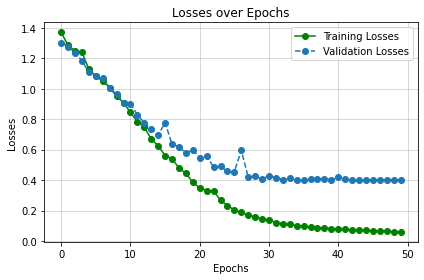

In [30]:
uniform.train(
    tumours.x_train, tumours.y_train,
    validation_data=(tumours.x_val, tumours.y_val),
    epochs=50,
    showProgress=True
)

uniform.plotLosses()
uniform.evaluate()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Conv2D)              (None, 180, 180, 32)      160       
                                                                 
 conv1 (Conv2D)              (None, 90, 90, 64)        8256      
                                                                 
 pool1 (MaxPooling2D)        (None, 45, 45, 64)        0         
                                                                 
 conv2 (Conv2D)              (None, 23, 23, 128)       32896     
                                                                 
 pool2 (MaxPooling2D)        (None, 11, 11, 128)       0         
                                                                 
 conv3 (Conv2D)              (None, 6, 6, 256)         131328    
                                                                 
 pool3 (MaxPooling2D)        (None, 3, 3, 256)        

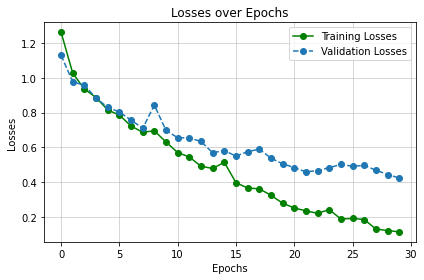

In [12]:
victor = CNNModel(
    depth=4,
    kernel_size=2,
    filters=32,
    optimizer=Adam()
)

victor.describe()
victor.train(
    tumours.x_train, tumours.y_train,
    validation_data=(tumours.x_val, tumours.y_val),
    epochs=30,
    showProgress=True
)

victor.plotLosses()
victor.evaluate()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Conv2D)              (None, 180, 180, 36)      936       
                                                                 
 conv1 (Conv2D)              (None, 90, 90, 72)        64872     
                                                                 
 drop1 (Dropout)             (None, 90, 90, 72)        0         
                                                                 
 pool1 (MaxPooling2D)        (None, 45, 45, 72)        0         
                                                                 
 conv2 (Conv2D)              (None, 23, 23, 144)       259344    
                                                                 
 drop2 (Dropout)             (None, 23, 23, 144)       0         
                                                                 
 pool2 (MaxPooling2D)        (None, 11, 11, 144)      

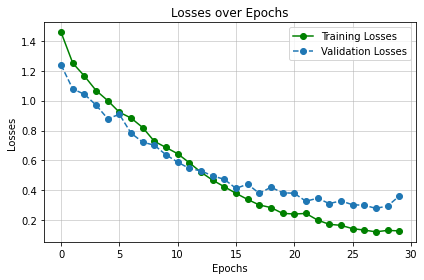

In [10]:
whisky = CNNModel(
    depth=3,
    kernel_size=5,
    filters=36,
    addDropouts=True,
    optimizer=Adam()
)

whisky.describe()
whisky.train(
    tumours.x_train, tumours.y_train,
    class_weight= {0:2, 1:1, 2: 1, 3:1},
    validation_data=(tumours.x_val, tumours.y_val),
    epochs=30,
    showProgress=True
)

whisky.plotLosses()
whisky.evaluate()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Conv2D)              (None, 180, 180, 36)      936       
                                                                 
 conv1 (Conv2D)              (None, 90, 90, 72)        64872     
                                                                 
 drop1 (Dropout)             (None, 90, 90, 72)        0         
                                                                 
 pool1 (MaxPooling2D)        (None, 45, 45, 72)        0         
                                                                 
 conv2 (Conv2D)              (None, 23, 23, 144)       259344    
                                                                 
 drop2 (Dropout)             (None, 23, 23, 144)       0         
                                                                 
 pool2 (MaxPooling2D)        (None, 11, 11, 144)      

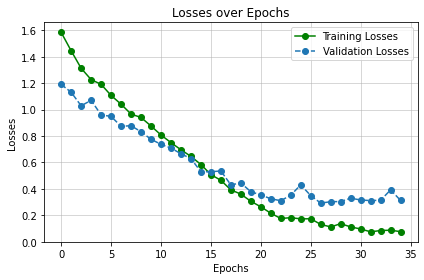

In [23]:
xray = CNNModel(
    depth=3,
    kernel_size=5,
    filters=36,
    addDropouts=True,
    optimizer=Adam()
)

xray.describe()
xray.train(
    tumours.x_train, tumours.y_train,
    class_weight= {0:2, 1:1, 2: 1, 3:1.5},
    validation_data=(tumours.x_val, tumours.y_val),
    epochs=35,
    showProgress=True
)

xray.plotLosses()
xray.evaluate()

In [7]:
yankee = CNNModel(
    depth=3,
    kernel_size=5,
    filters=36,
    addDropouts=True,
    optimizer=Adam()
)

yankee.describe()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Conv2D)              (None, 180, 180, 36)      936       
                                                                 
 conv1 (Conv2D)              (None, 90, 90, 72)        64872     
                                                                 
 drop1 (Dropout)             (None, 90, 90, 72)        0         
                                                                 
 pool1 (MaxPooling2D)        (None, 45, 45, 72)        0         
                                                                 
 conv2 (Conv2D)              (None, 23, 23, 144)       259344    
                                                                 
 drop2 (Dropout)             (None, 23, 23, 144)       0         
                                                                 
 pool2 (MaxPooling2D)        (None, 11, 11, 144)       0

In [8]:
%%time
folds = 4

accuracy__ = numpy.zeros((folds))

for i in range(folds):
    tumours = Images(180, validation_ratio=0.25, random_state=None)
    tumours.shuffleData(mode='training')
    tumours.shuffleData(mode='validation')
    # Datapoint counts
    validation_data_points = tumours.y_val.shape[0]
    training_data_points   = tumours.y_train.shape[0]
    print('#'*39)
    print(f'# Starting cross-validation in fold {i} #')
    print('#'*39, end='\n'*2)
    print(f'Training on {training_data_points} and validating in ' \
          f'{validation_data_points} datapoints.')
    print()
    
    print('Training in progress ...')
    yankee.train(
        tumours.x_train, tumours.y_train,
        class_weight= {0:2, 1:1, 2: 1, 3:1.5},
        validation_data=(tumours.x_val, tumours.y_val),
        epochs=40,
    )

    print('Training complete! fetching performance report...')
    accuracy__[i] = max(yankee.getDataPoints(mode='accuracy'))
    yankee.makePrediction(tumours.x_val)
    yankee.getClassificationReport(tumours.y_val)

print(f'Mean accuracy : {numpy.mean(accuracy__)}')
yankee.finalTest()

#######################################
# Starting cross-validation in fold 0 #
#######################################

Training on 2152 and validating in 718 datapoints.

Training in progress ...
Training complete! fetching performance report...

Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       201
           1       0.89      0.88      0.88       189
           2       0.89      0.87      0.88       102
           3       0.96      0.99      0.97       226

    accuracy                           0.93       718
   macro avg       0.92      0.92      0.92       718
weighted avg       0.93      0.93      0.93       718

#######################################
# Starting cross-validation in fold 1 #
#######################################

Training on 2152 and validating in 718 datapoints.

Training in progress ...
Training complete! fetching performance report...

Classification Report:

              preci

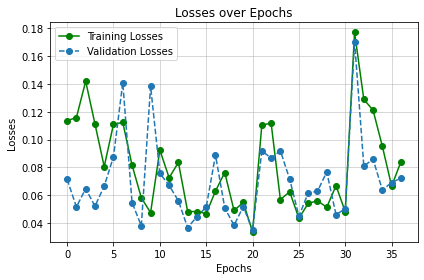

In [9]:
yankee.plotLosses()

In [71]:
%%time
zulu = CNNModel(
    depth=3,
    kernel_size=4,
    filters=52,
    optimizer=Adam(learning_rate=0.00009),
)
zulu.describe()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Conv2D)              (None, 180, 180, 52)      884       
                                                                 
 conv1 (Conv2D)              (None, 90, 90, 104)       86632     
                                                                 
 pool1 (MaxPooling2D)        (None, 45, 45, 104)       0         
                                                                 
 conv2 (Conv2D)              (None, 23, 23, 208)       346320    
                                                                 
 pool2 (MaxPooling2D)        (None, 11, 11, 208)       0         
                                                                 
 conv3 (Conv2D)              (None, 6, 6, 416)         1384864   
                                                                 
 pool3 (MaxPooling2D)        (None, 3, 3, 416)        

In [72]:
# Weight Balancing
total_samples = len(tumours.y_train)
total_classes = len(Images.classes)

class_weights = {
    value : total_samples / (tumours.class_frequencies[value] * total_classes)
    for value in tumours.labels.values()
}                     

print(class_weights)

{0: 0.8842429577464789, 1: 0.896875, 2: 1.756118881118881, 3: 0.8441176470588235}


Epoch 1/25
63/63 [==============================] - 112s 2s/step - loss: 1.3573 - accuracy: 0.3972 - val_loss: 1.2453 - val_accuracy: 0.5122
Epoch 2/25
63/63 [==============================] - 119s 2s/step - loss: 1.1804 - accuracy: 0.5470 - val_loss: 1.1645 - val_accuracy: 0.5134
Epoch 3/25
63/63 [==============================] - 114s 2s/step - loss: 1.1043 - accuracy: 0.5998 - val_loss: 1.0732 - val_accuracy: 0.5981
Epoch 4/25
63/63 [==============================] - 113s 2s/step - loss: 1.0604 - accuracy: 0.6501 - val_loss: 1.0490 - val_accuracy: 0.6063
Epoch 5/25
63/63 [==============================] - 113s 2s/step - loss: 1.0306 - accuracy: 0.6834 - val_loss: 1.0237 - val_accuracy: 0.6574
Epoch 6/25
63/63 [==============================] - 113s 2s/step - loss: 1.0362 - accuracy: 0.6680 - val_loss: 1.0354 - val_accuracy: 0.6771
Epoch 7/25
63/63 [==============================] - 113s 2s/step - loss: 1.0072 - accuracy: 0.6954 - val_loss: 1.0263 - val_accuracy: 0.6574
Epoch 8/25
63

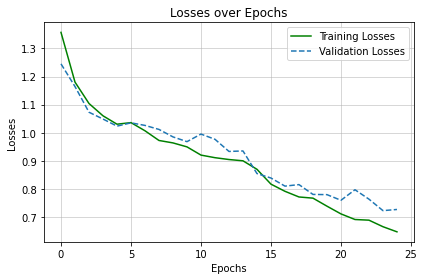

In [73]:
%%time
zulu.train(
    tumours.x_train, tumours.y_train,
    validation_data=(tumours.x_val, tumours.y_val),
    epochs=25,
    class_weight=class_weights,
    showProgress=True
)
zulu.plotLosses()
zulu.evaluate()

### 5. Are you overfitting? Verify. 

* As seen in the plots and the training info in the above section 1.4 the  
following models seem to be overfitting:
    
    1. india

### 6. Can you apply additional techniques to improve the performance of your CNN? Dropout? Data-augmentation, etc.. 

* Adding droputs seemed to reduce overfitting to a certain degree.
* Cross validating helped the most becuase the amount of data was less.


#### 7. Extra credits for nice plots and great analytics!  training_history.history.keys()

In [45]:
BaseModel.history.keys()

dict_keys(['loss', 'accuracy'])

## Phase 2
---

### 1. Extract filters of your CNN from different layers. Convert them into images. What do they mean? 

* Inspection of the filters and the  feature map outputs of the convolution  
layers allow us to understand what features are exactly being detected  
for a given input image.

###################################
# Filters of convolutional layers #
###################################



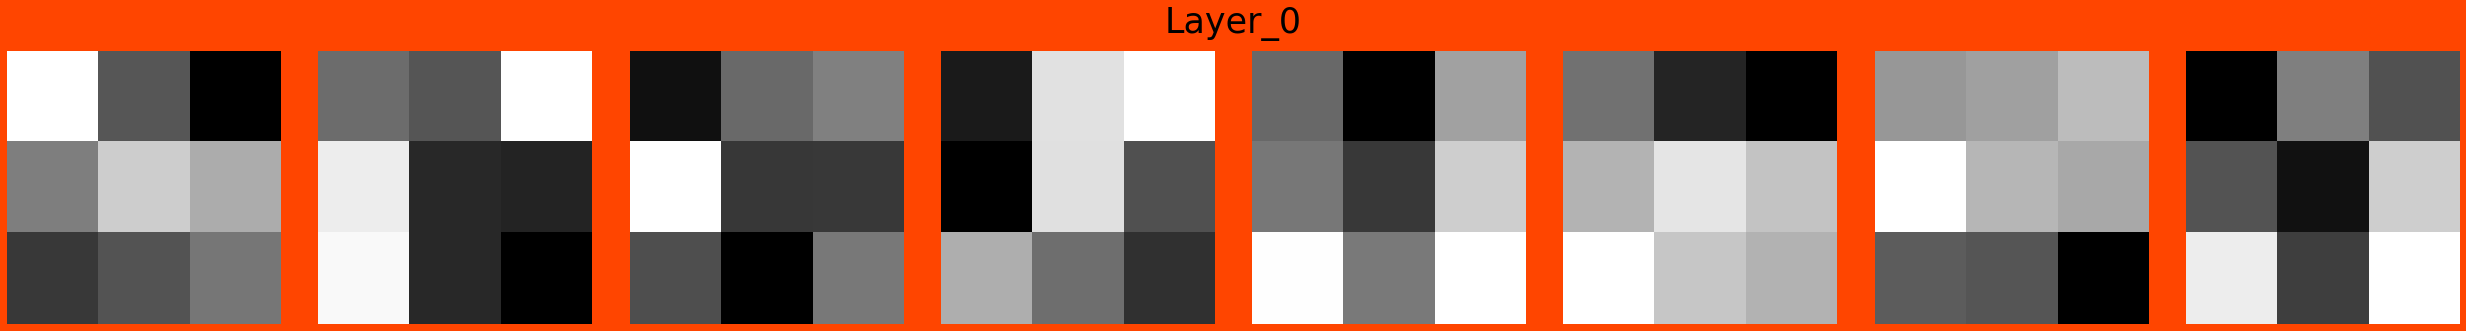

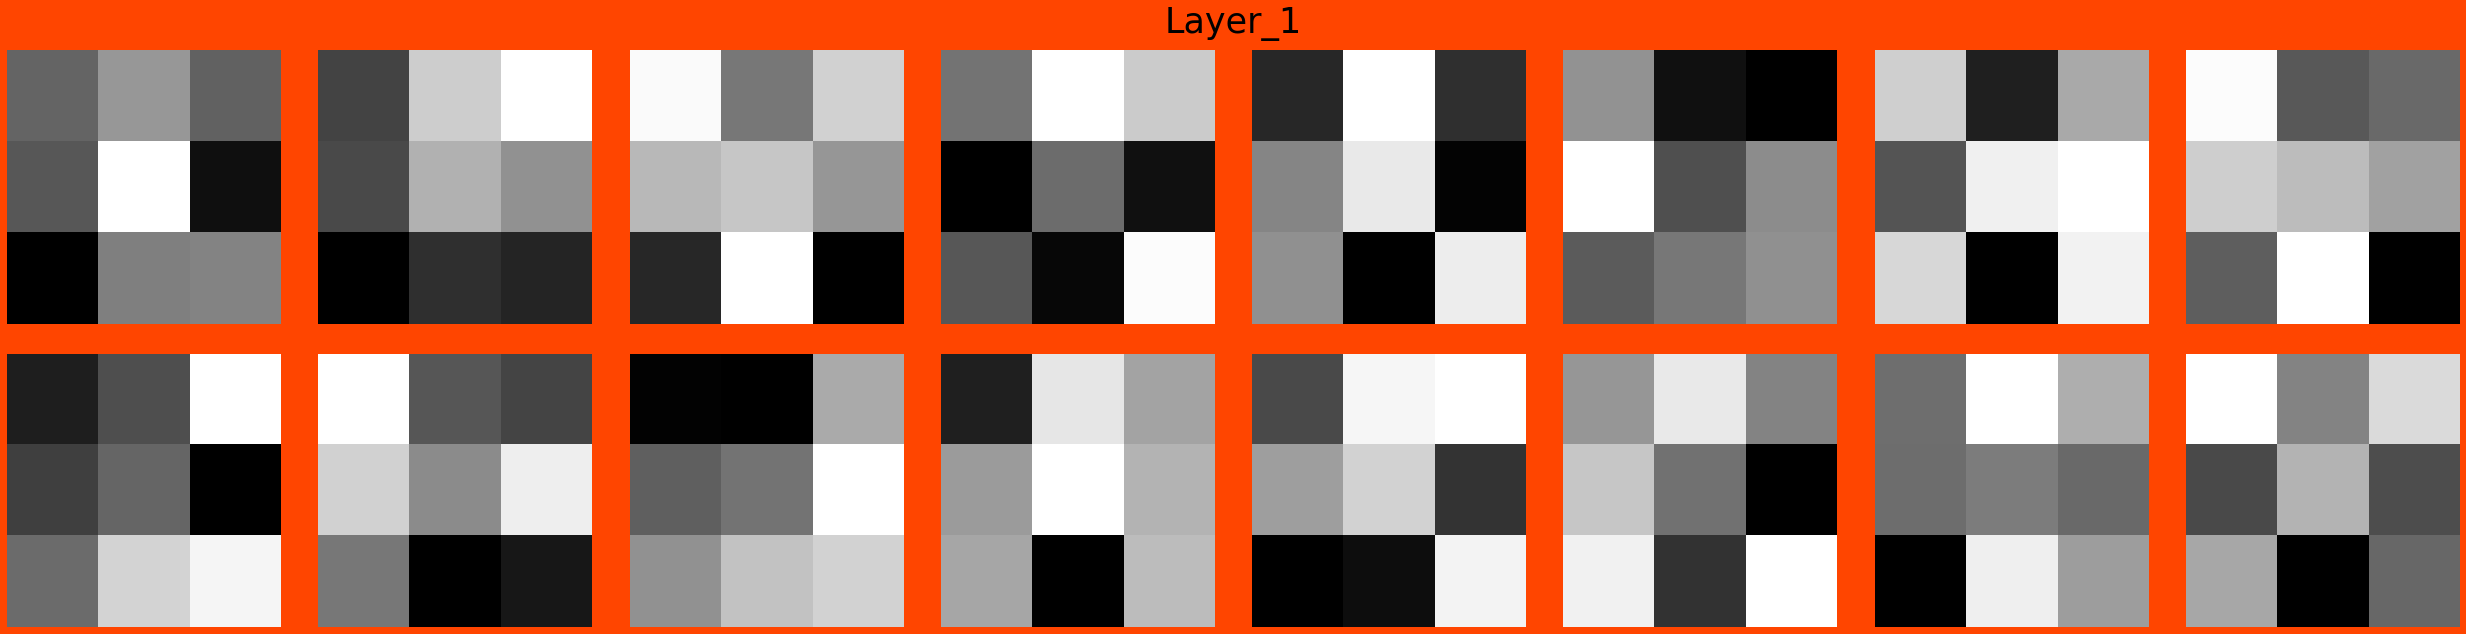

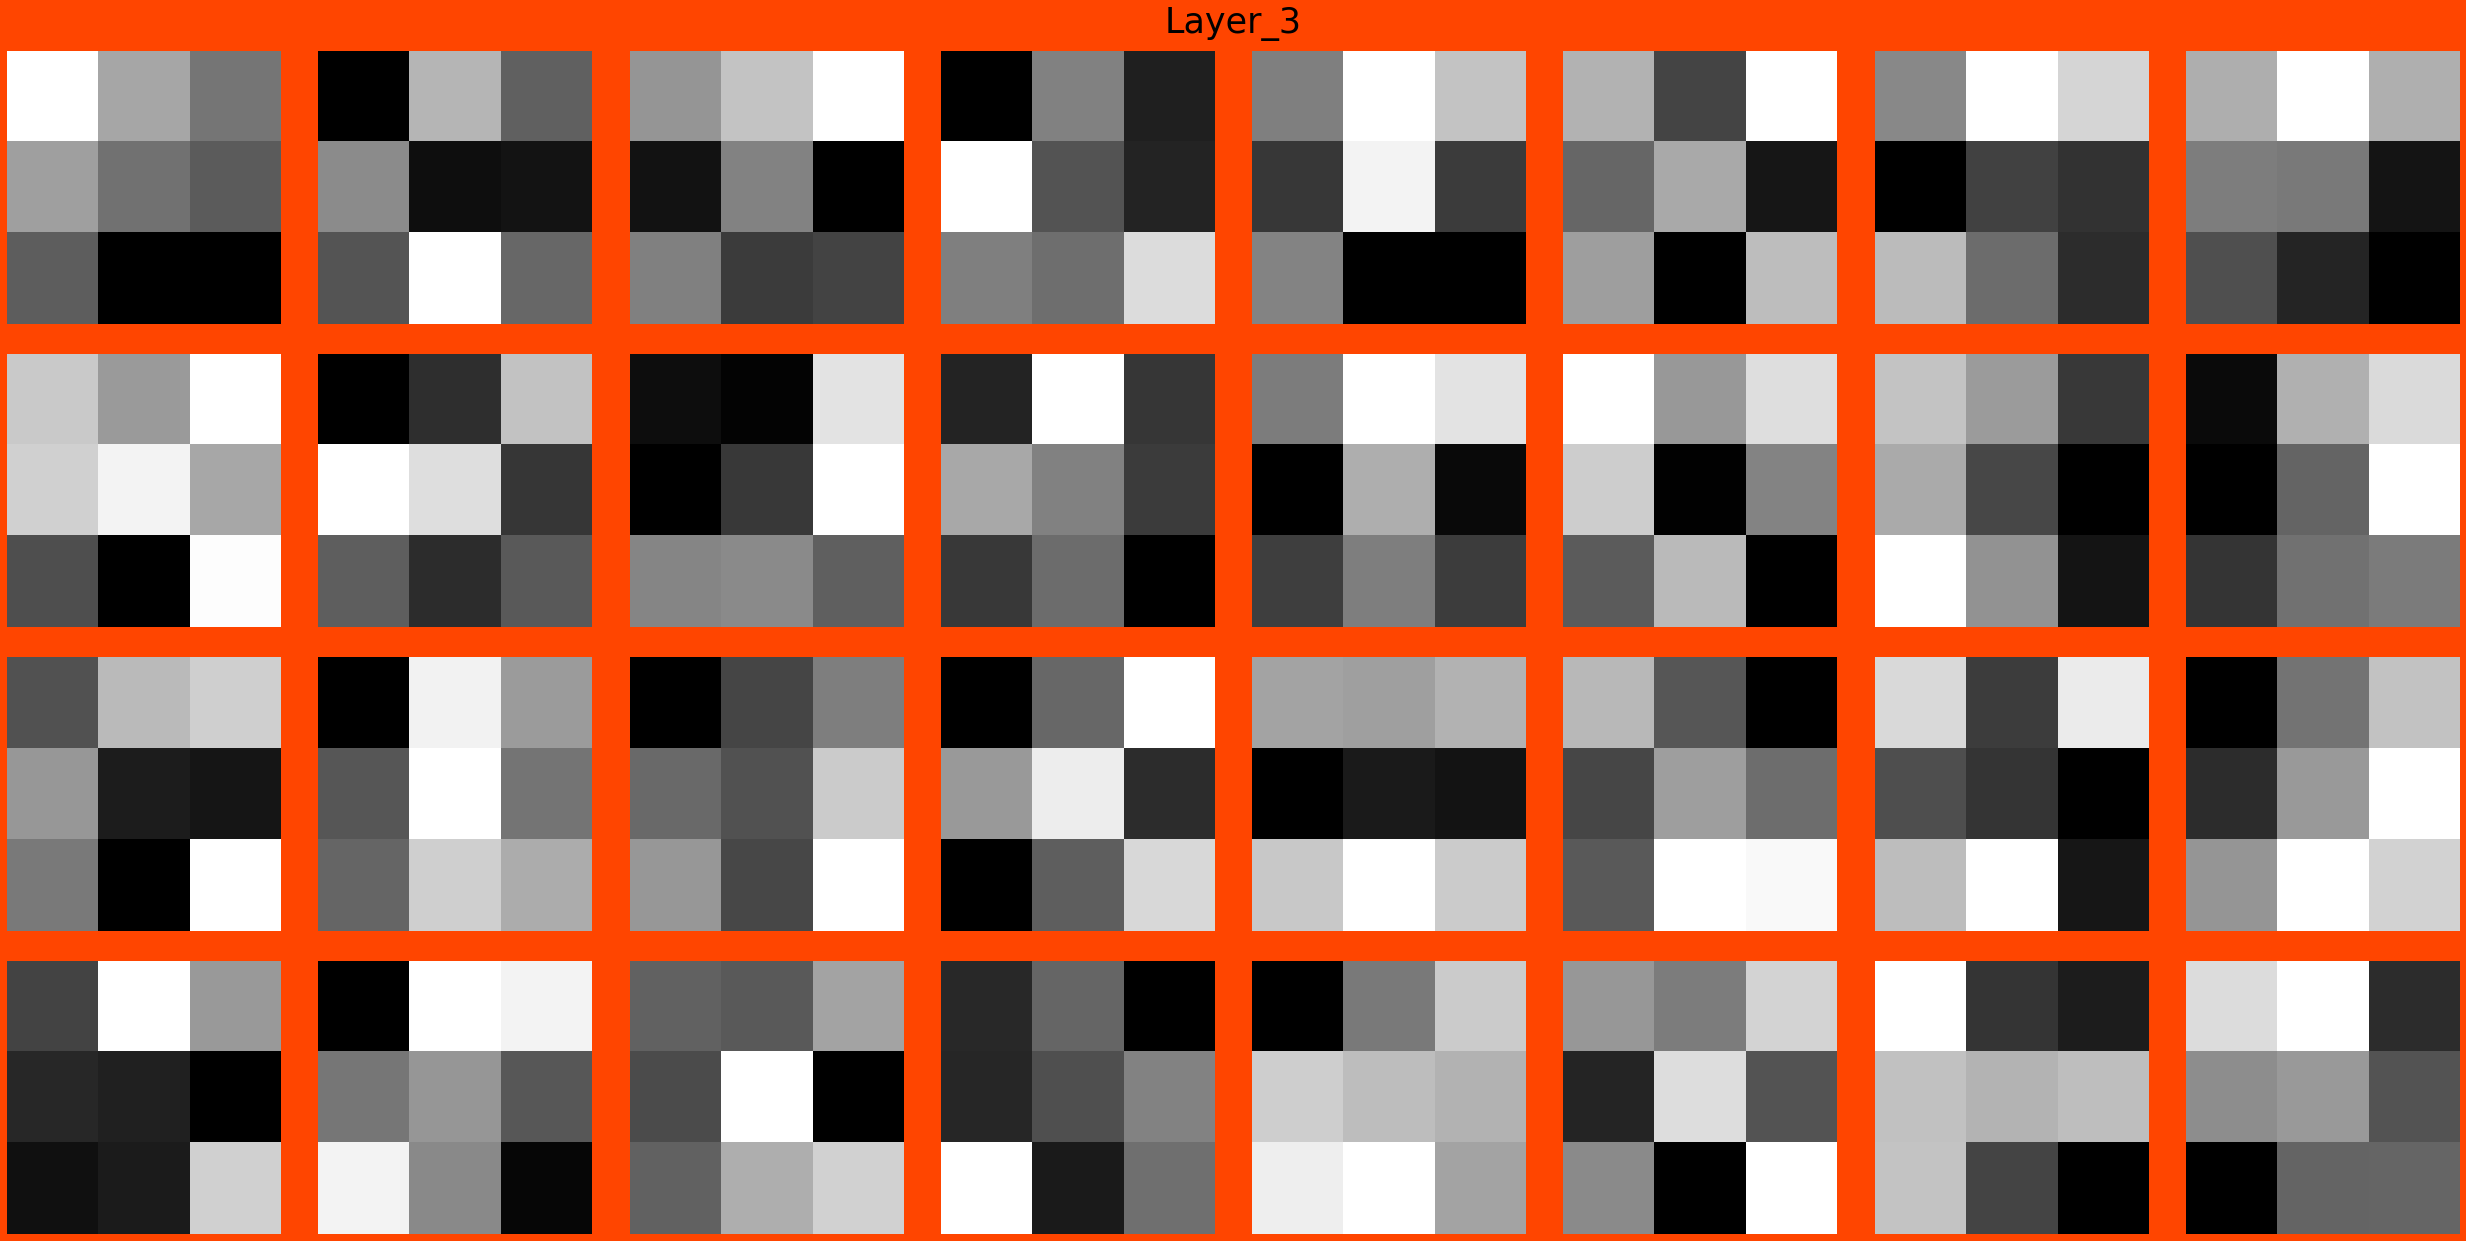

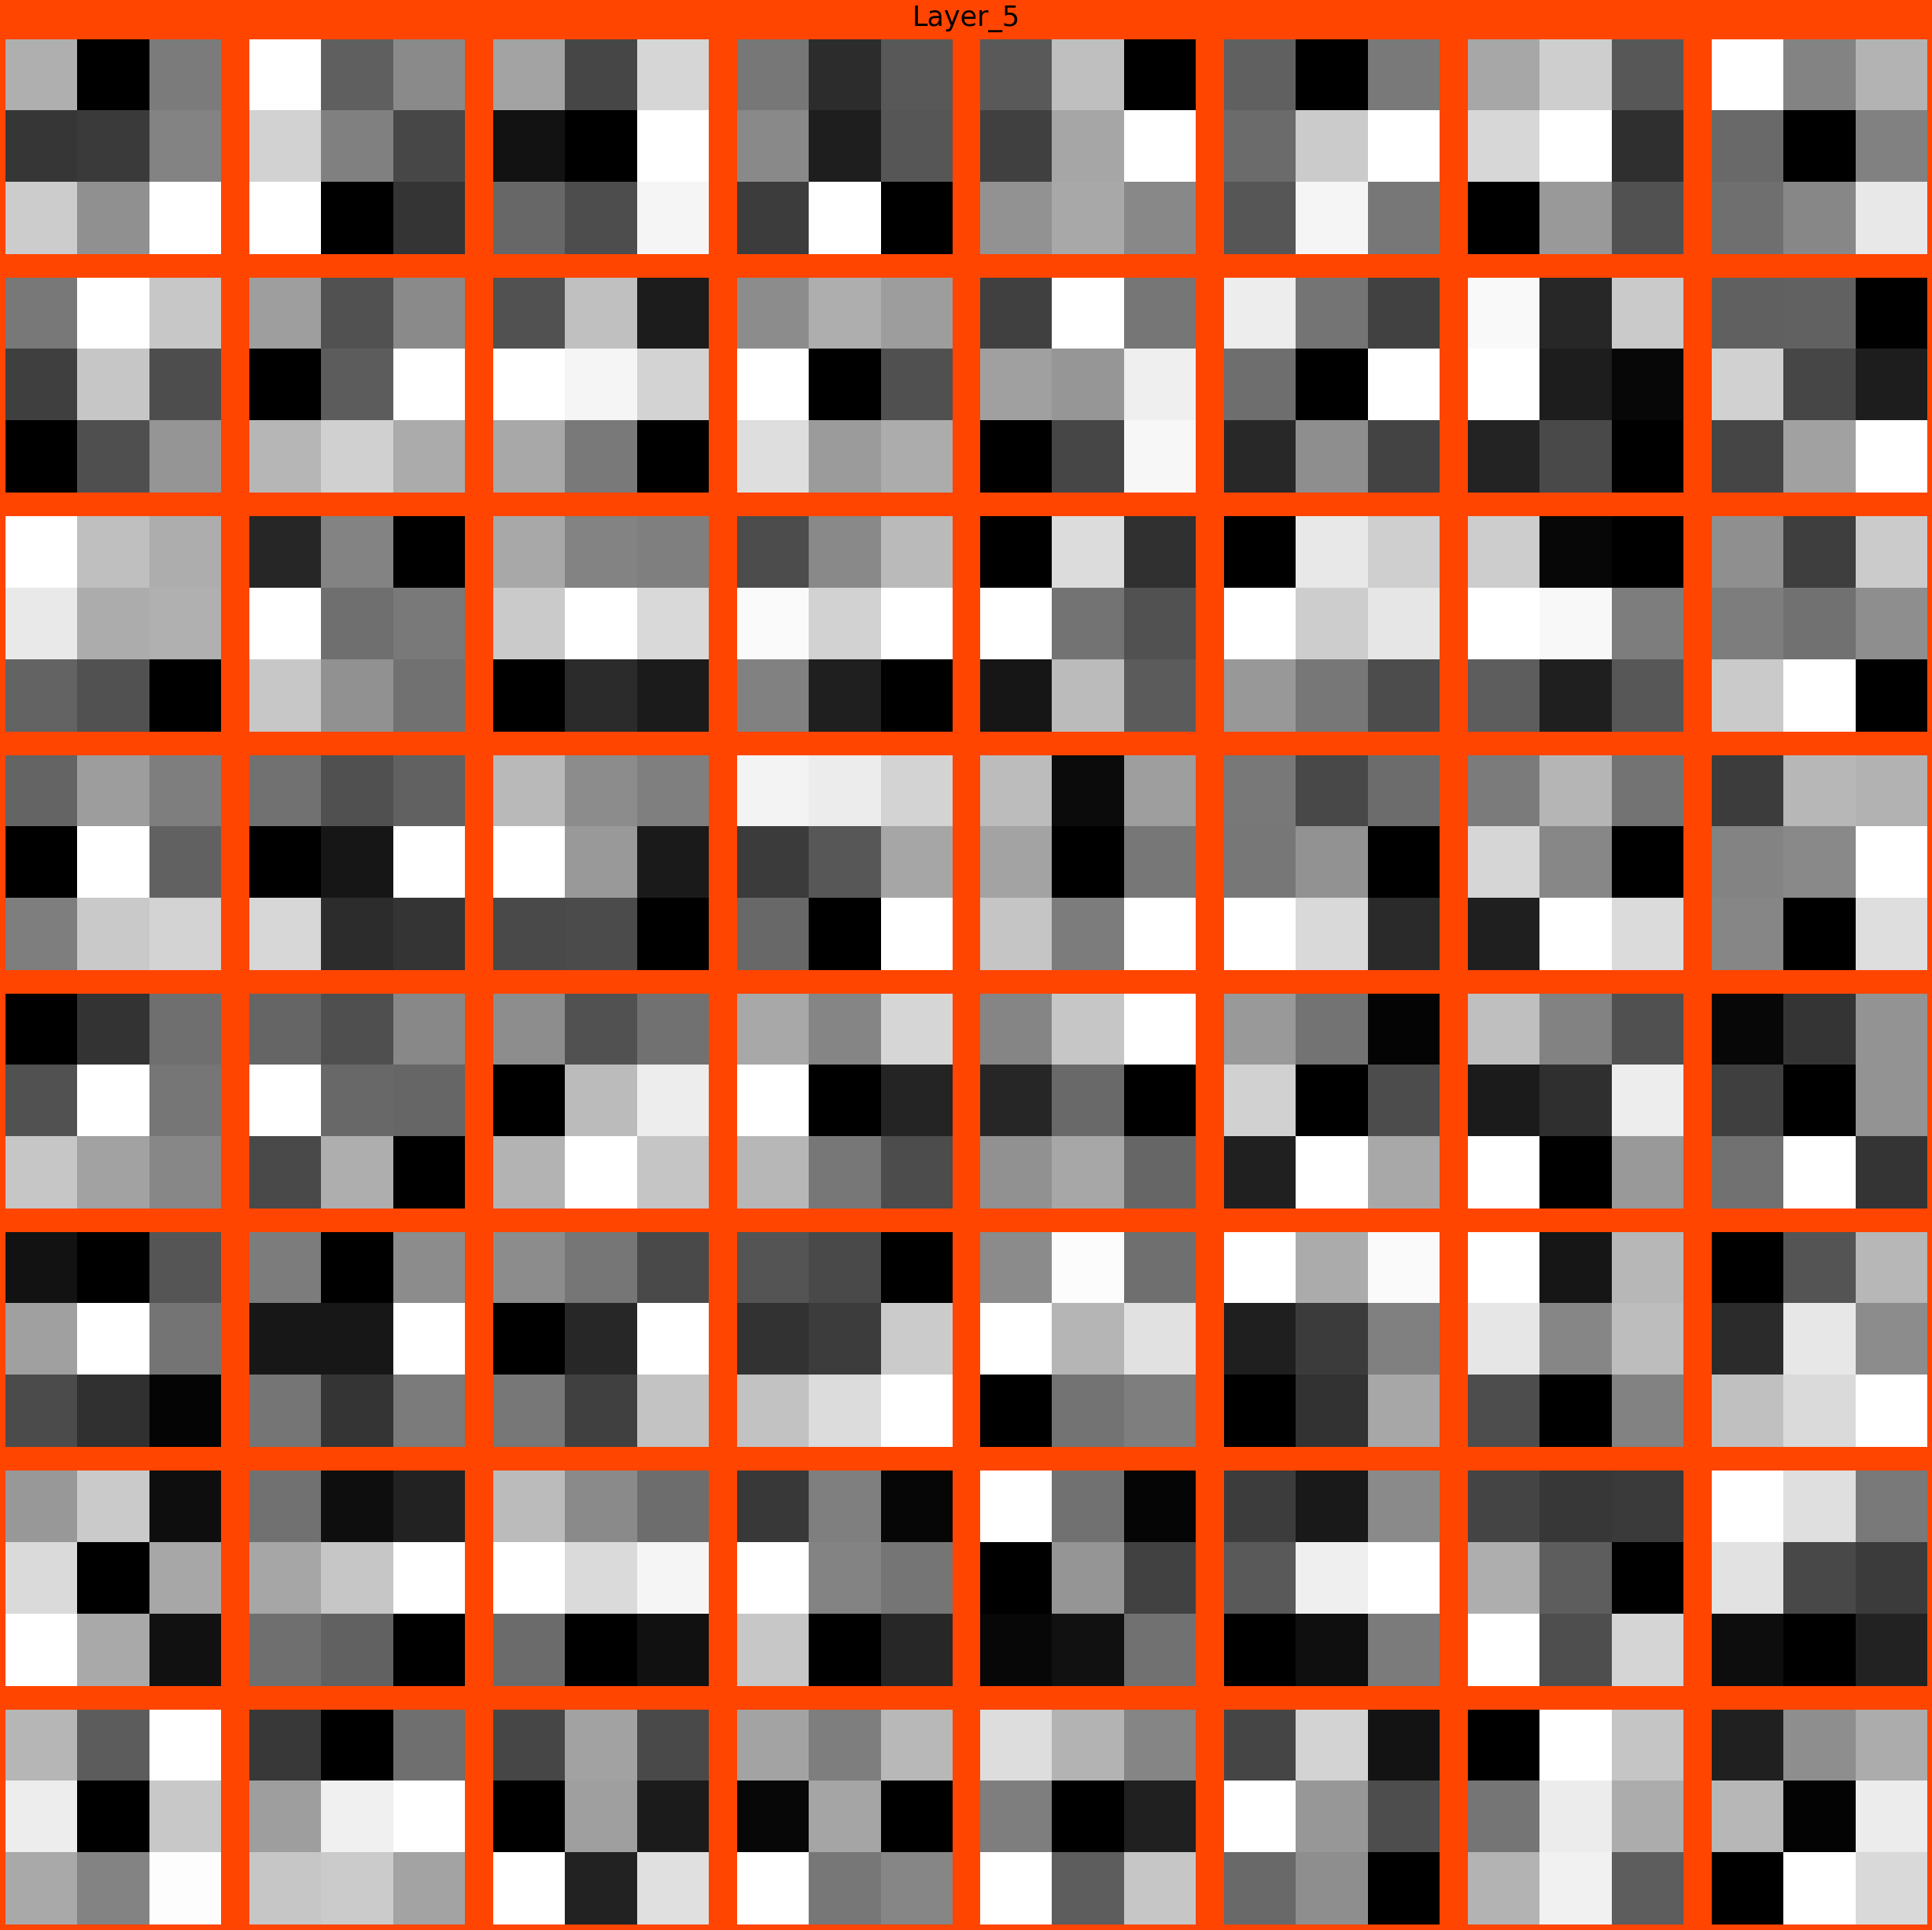

In [149]:
BaseModel.extractFilters()

* We can see that each layer has a different array of filters. This means  
each layer is looking for a different feature in the image. The features  
are traced by the brighter pixels in the filtres, for example the second  
last column in the last row is looking for a feature that somewhat looks   
like a straing line.

* Looking at just the filters is not that intuitive, however, visualizing  
the result of applying these filters to the input might give some ideas.

meningioma_tumor


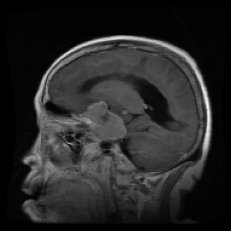

In [152]:
# Here's a random input
img =  tumours.getRandomImage(printLabel=True)
imshow_(img)

####################################
# Features of convolutional layers #
####################################



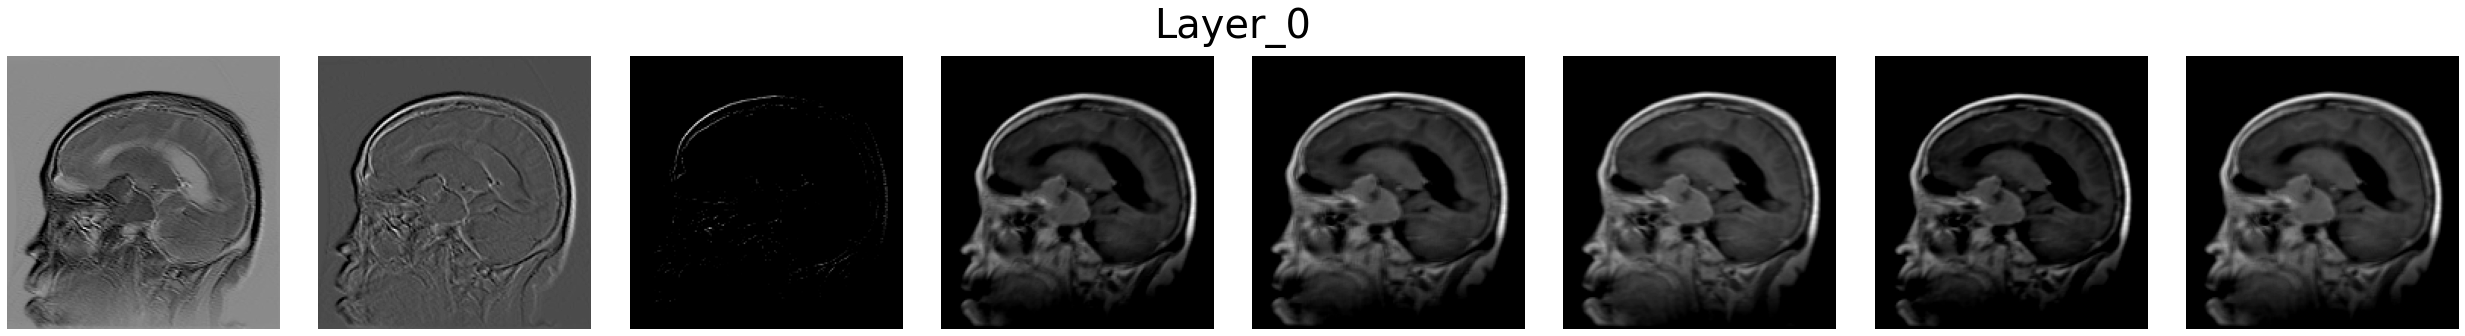

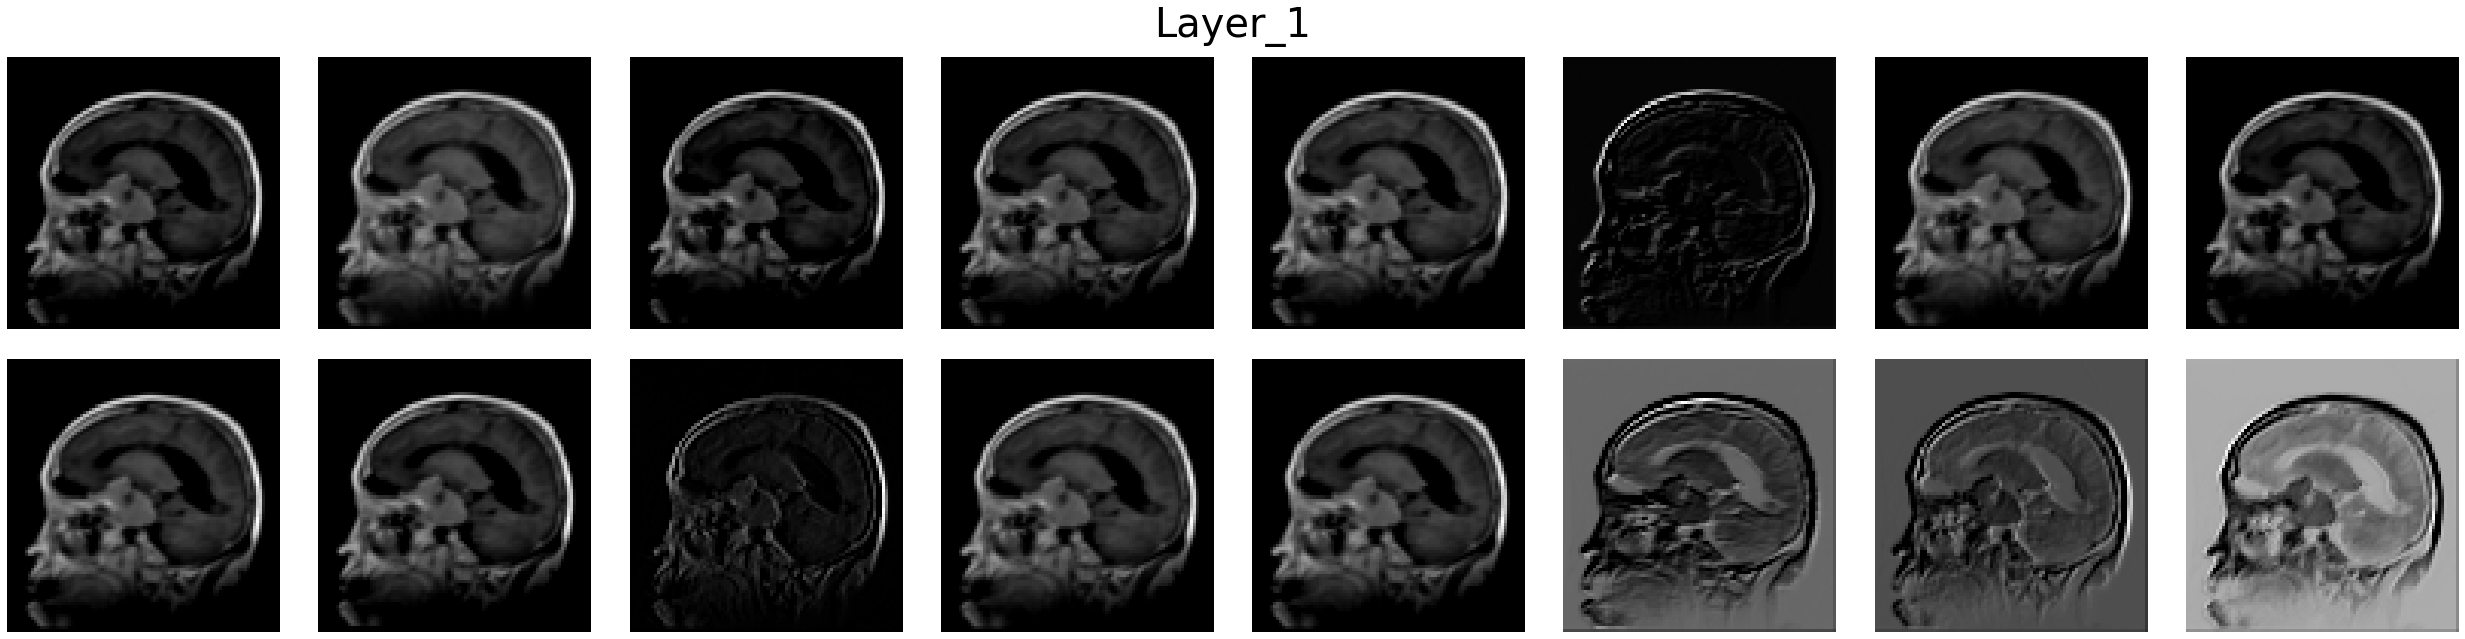

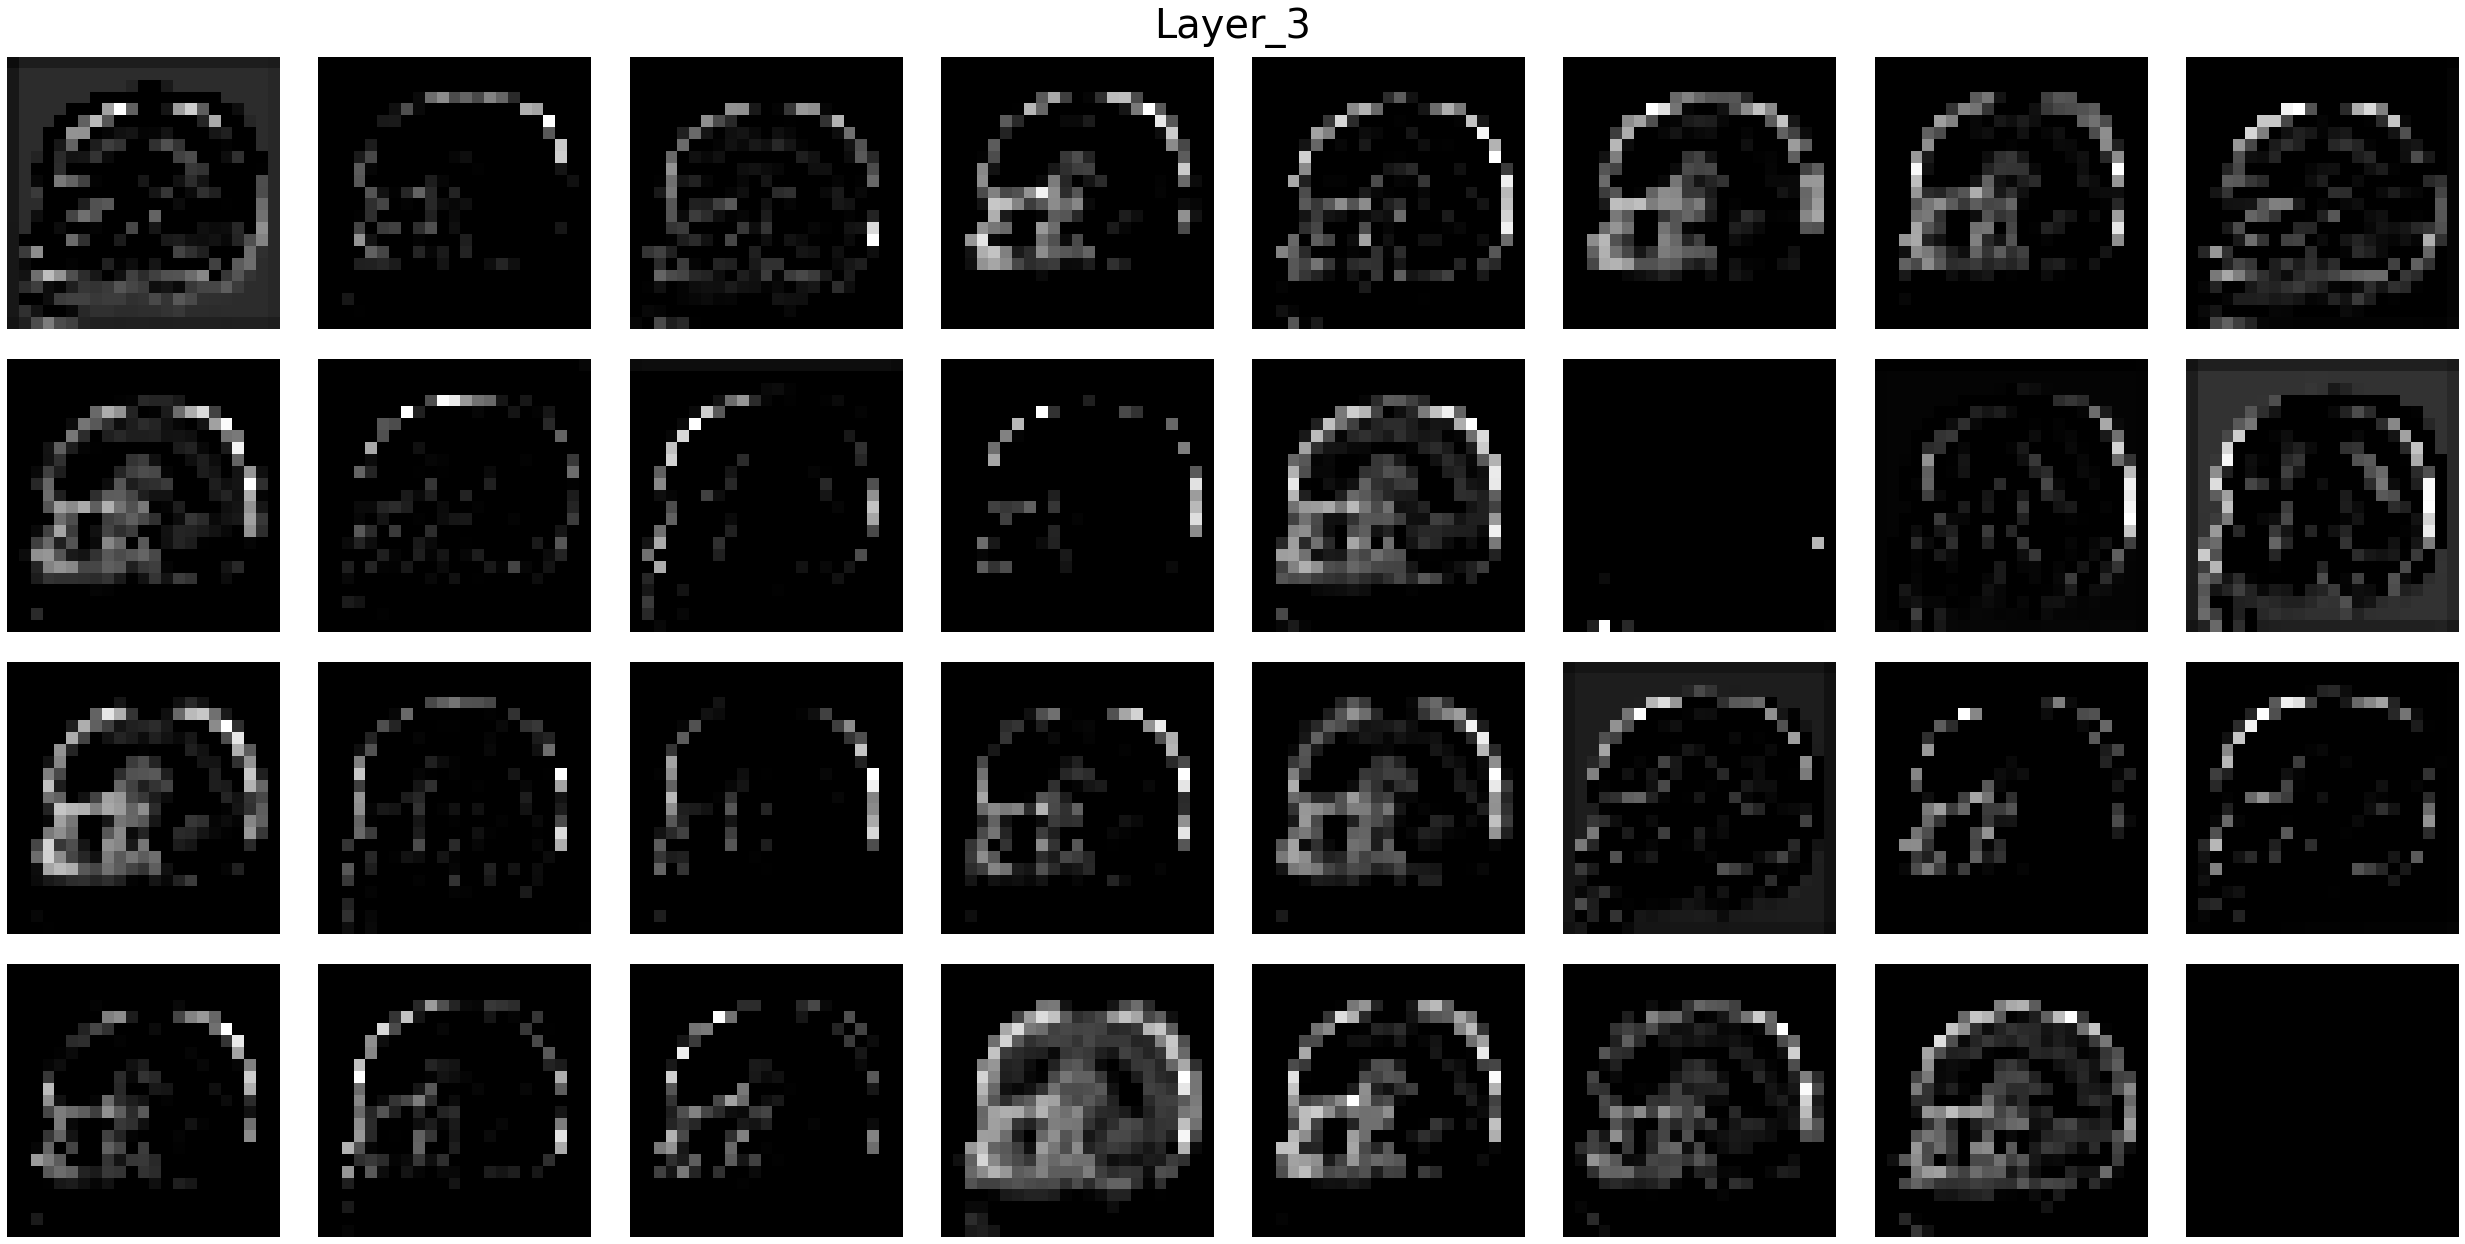

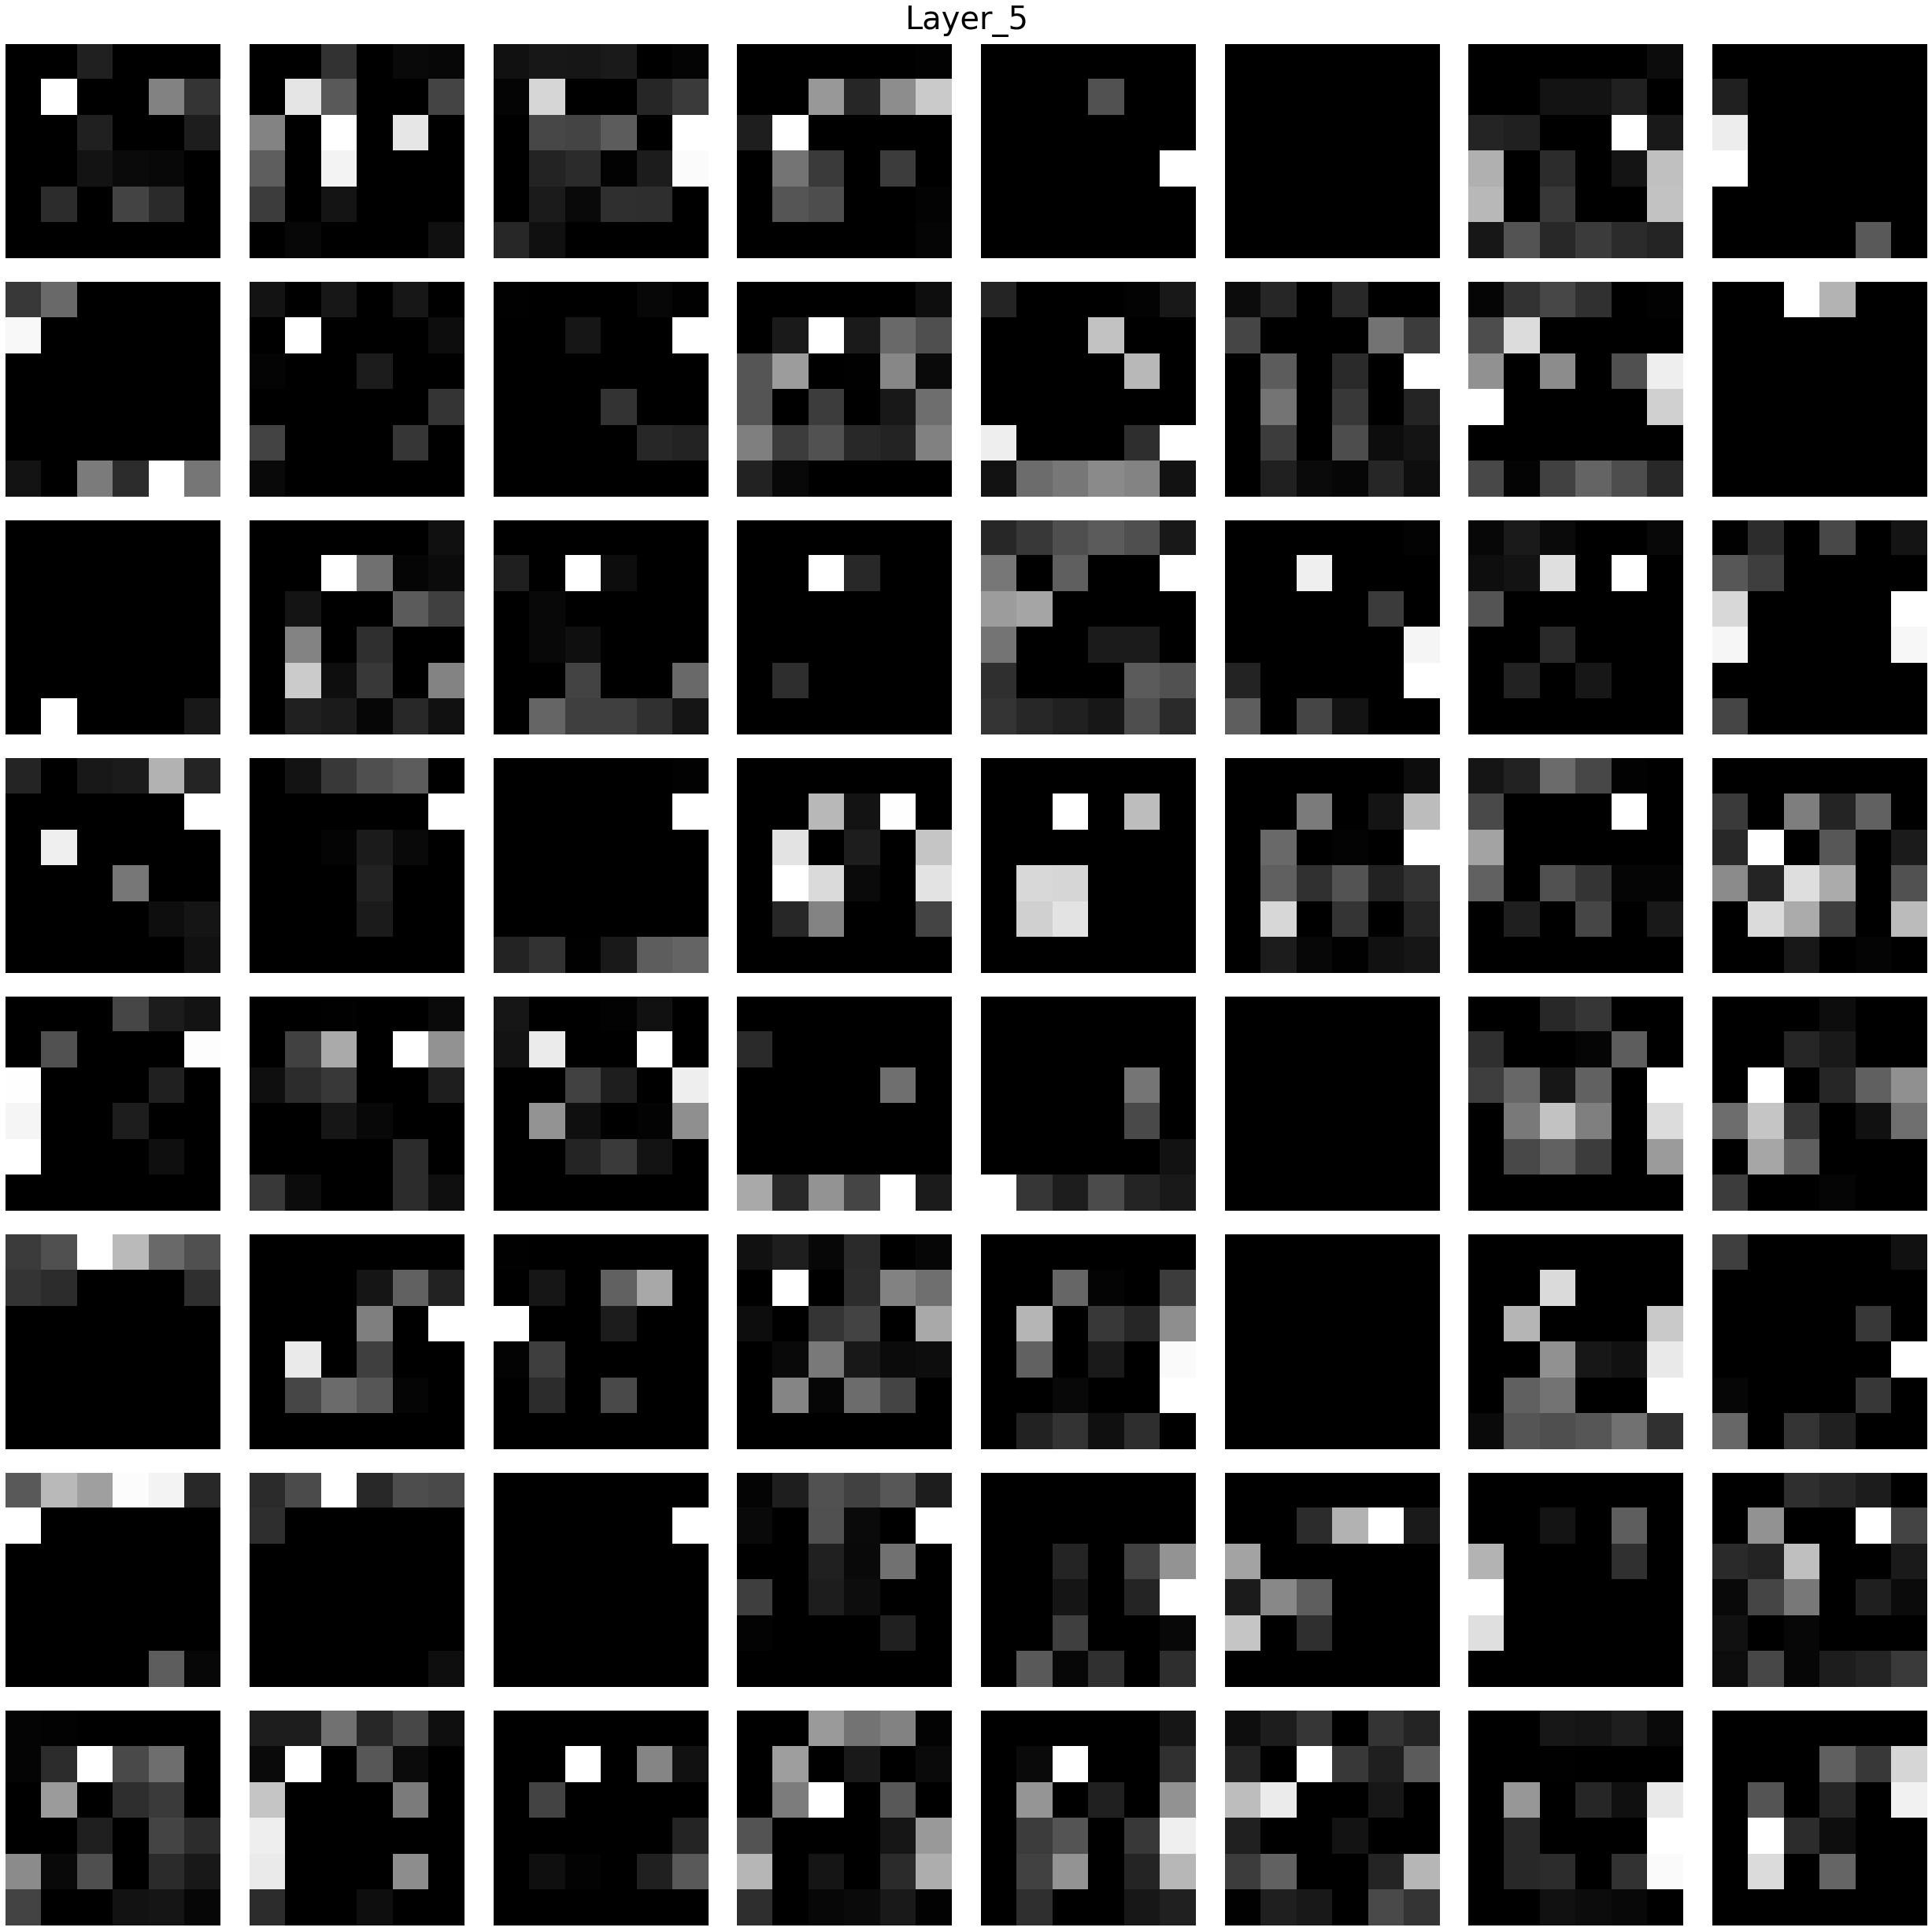

In [153]:
BaseModel.showFeatureMaps(layer='conv', image=img)

##############################
# Features of pooling layers #
##############################



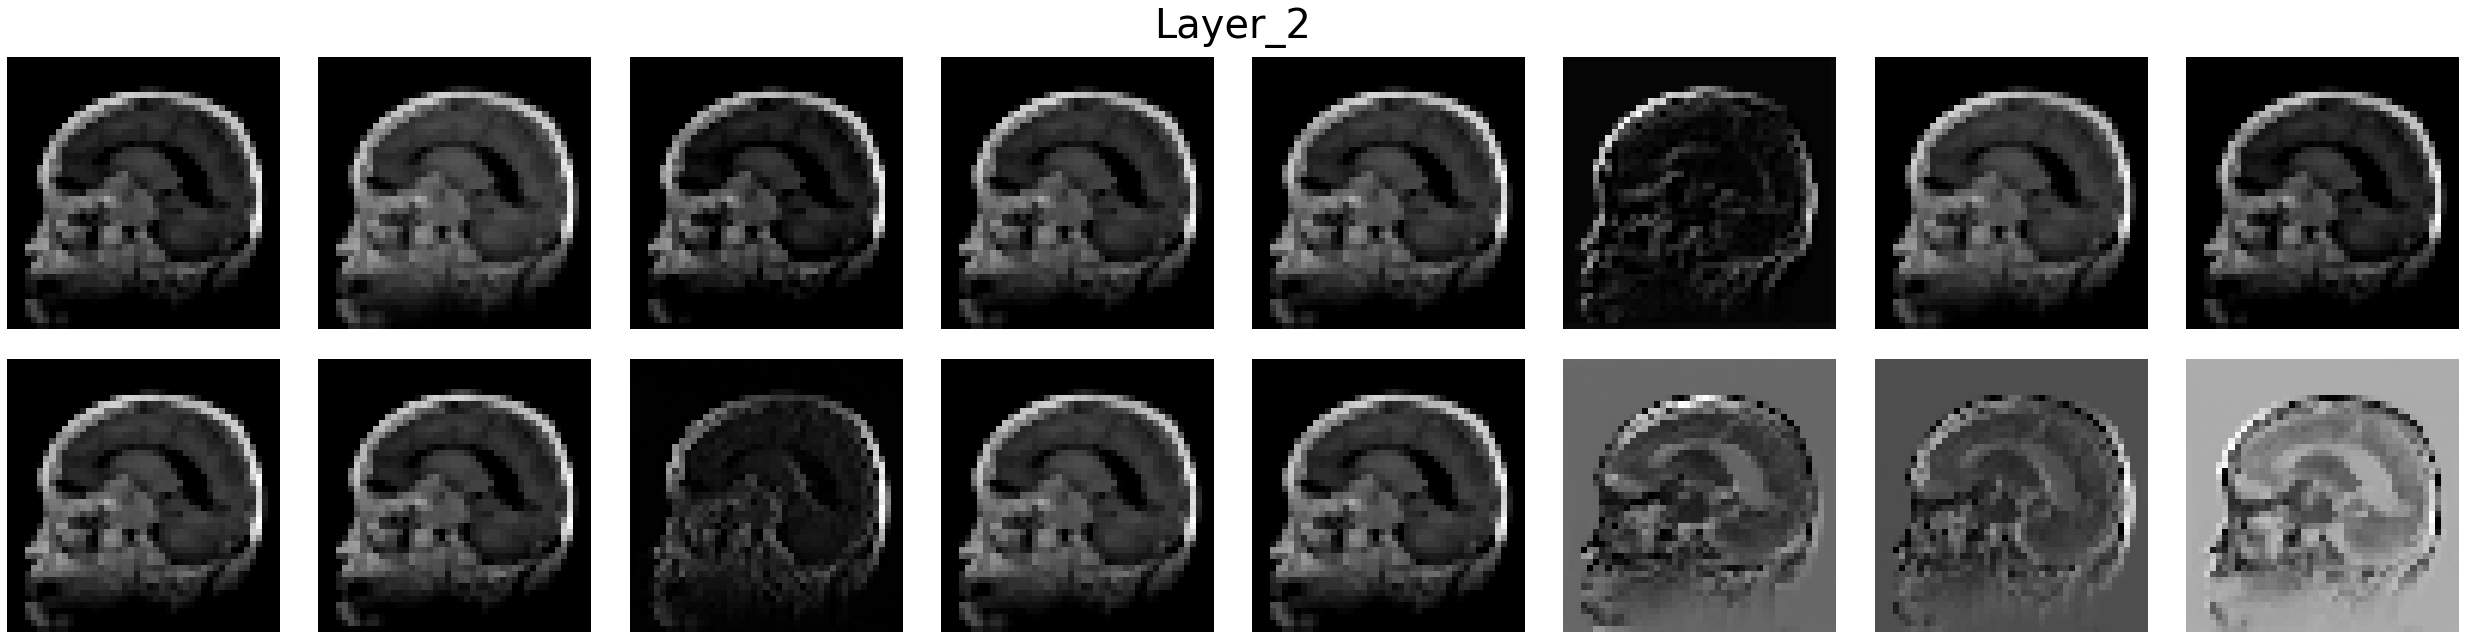

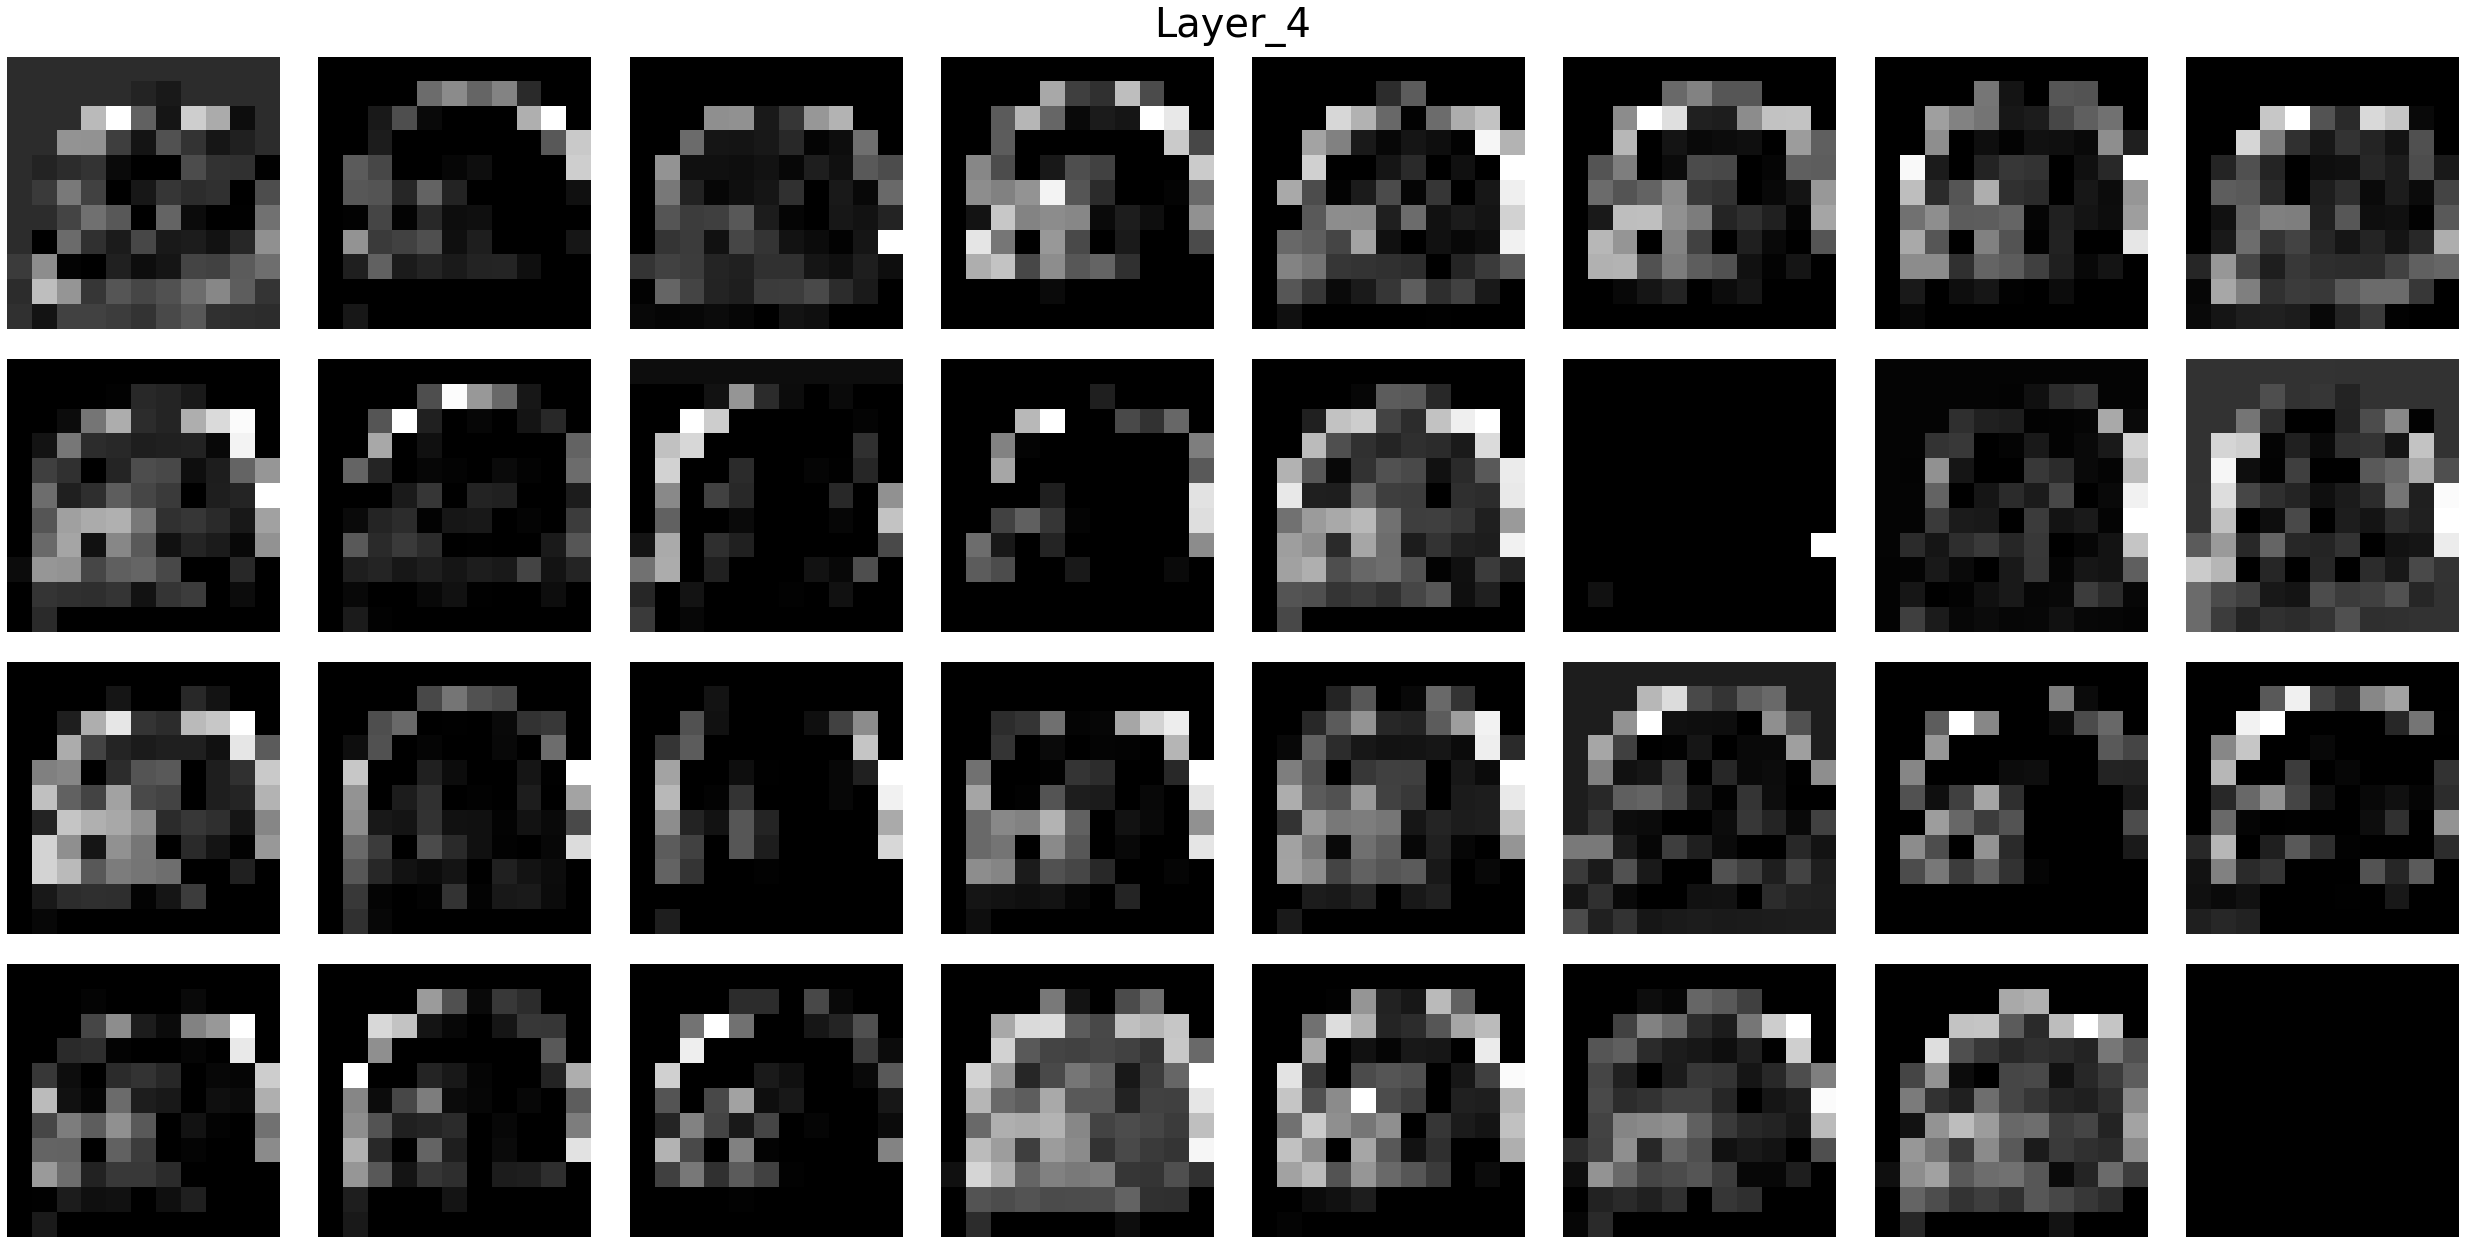

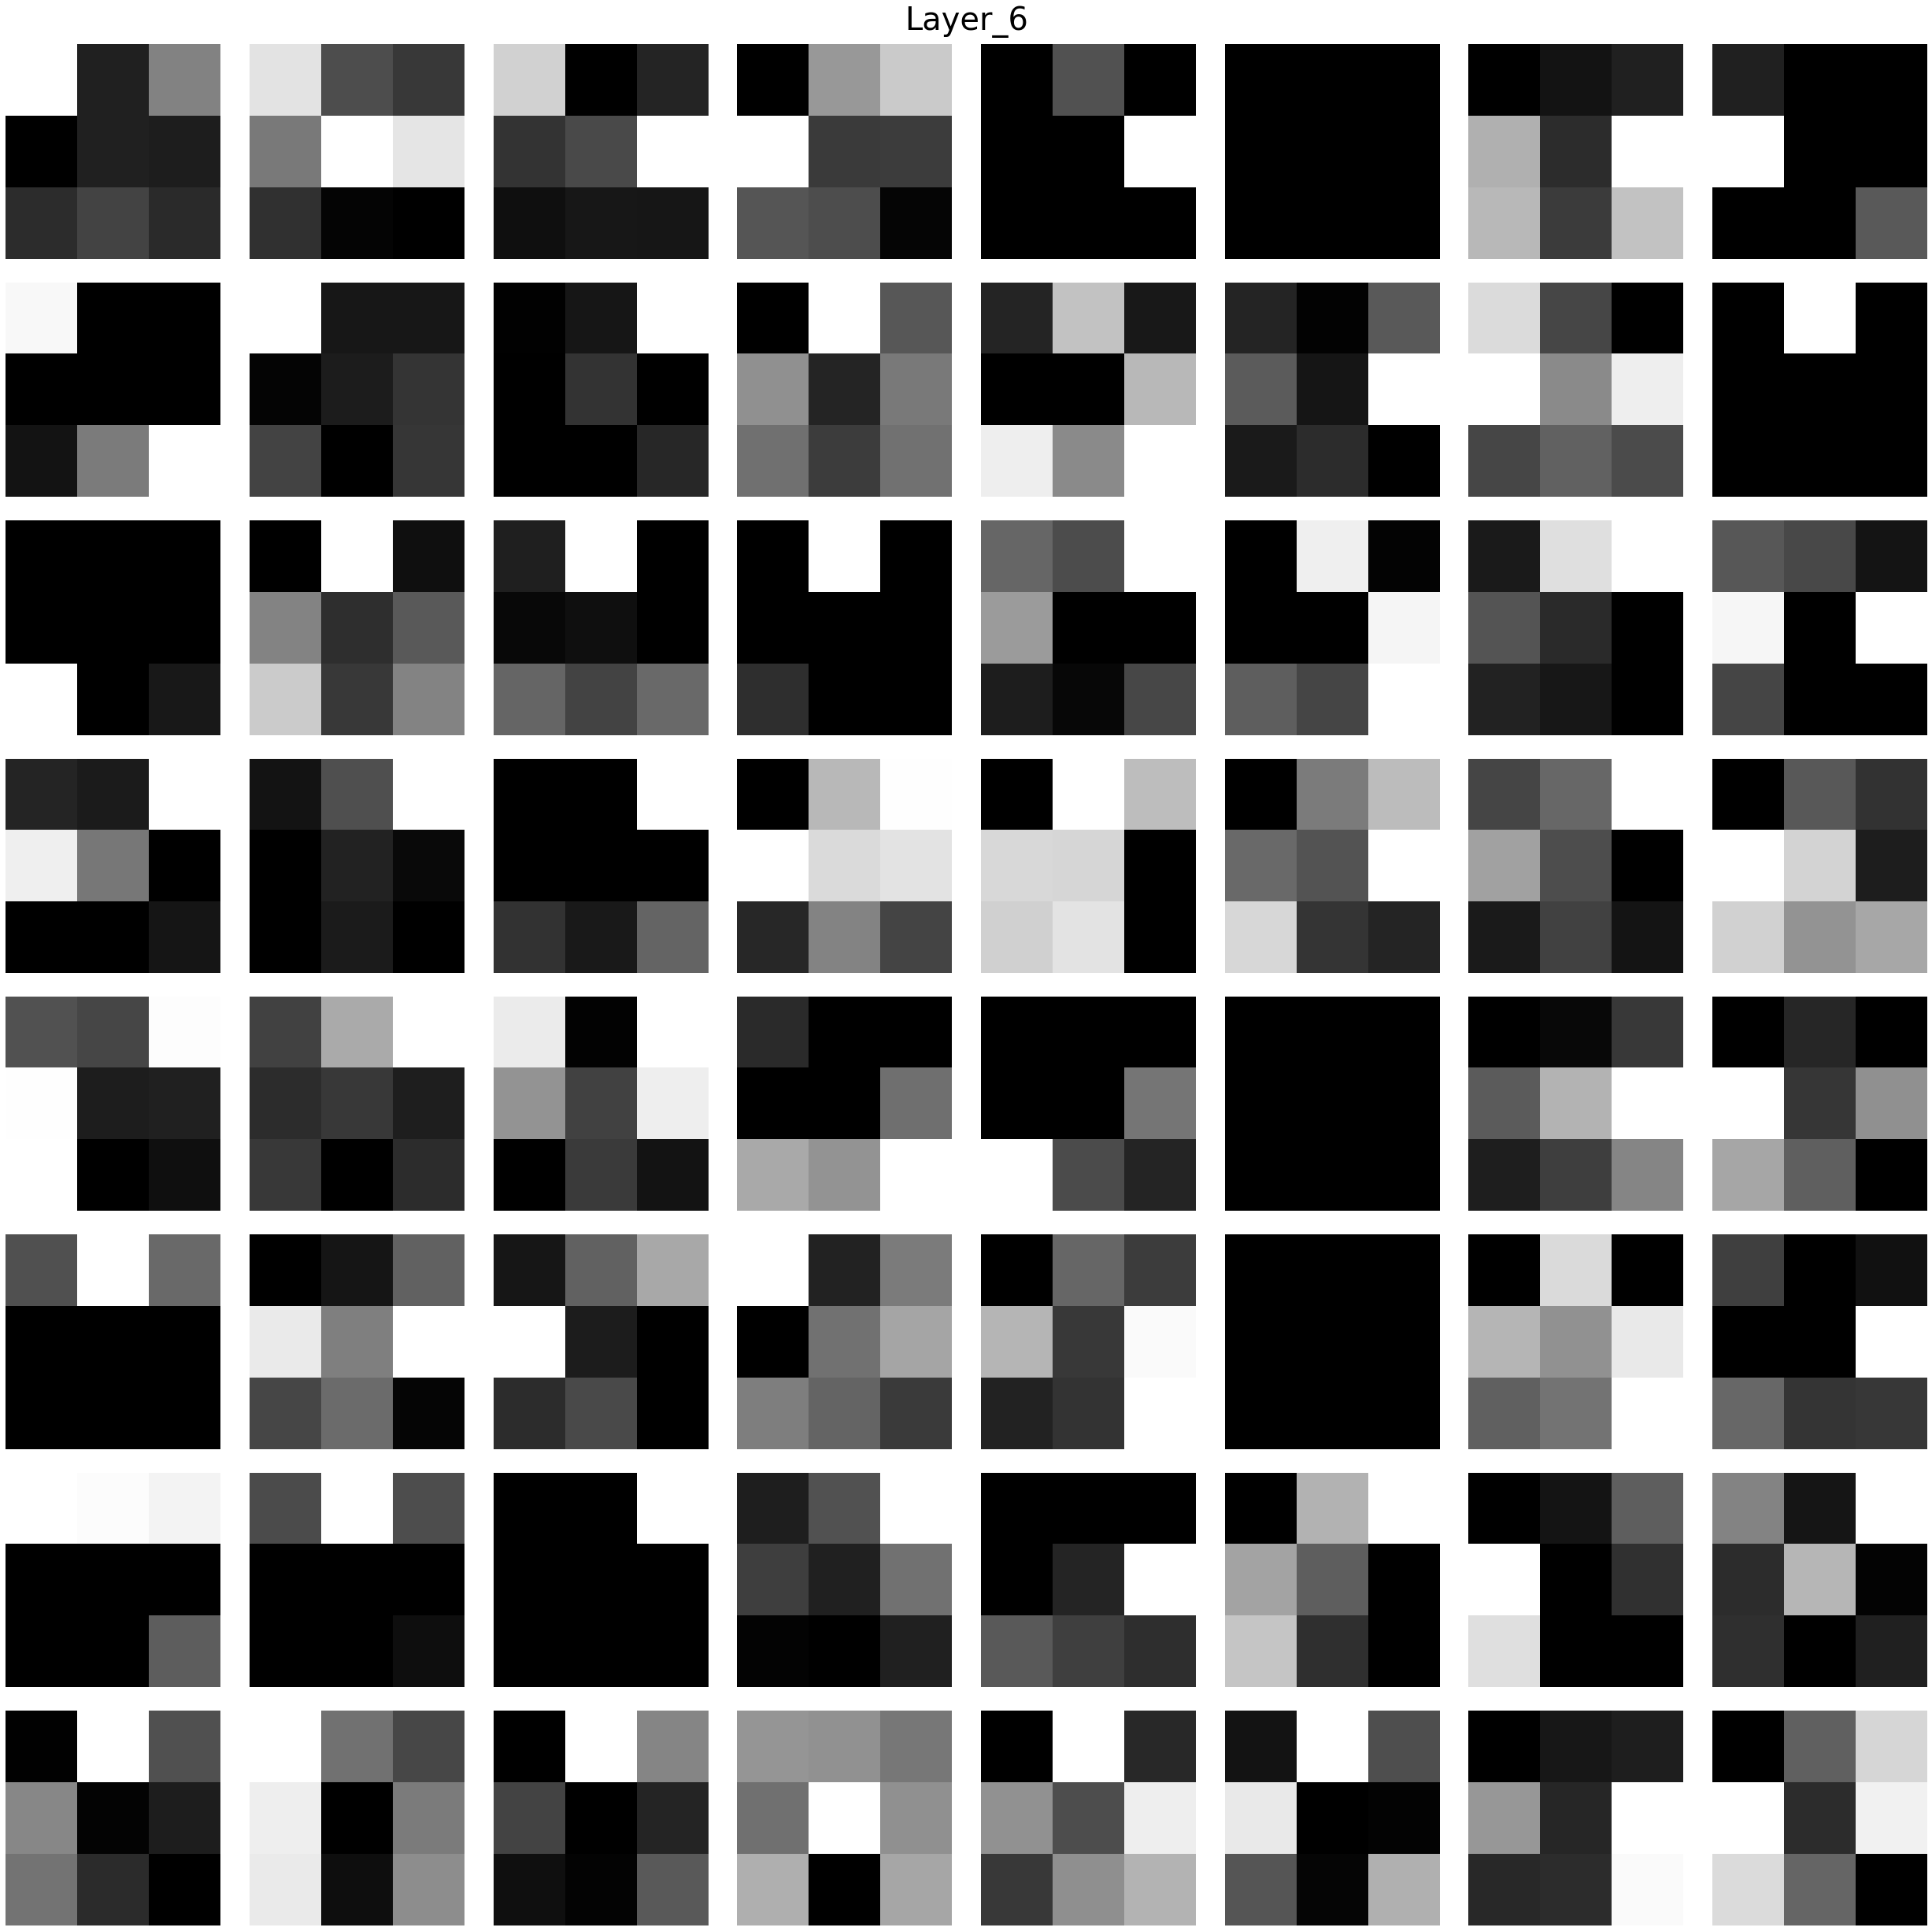

In [154]:
BaseModel.showFeatureMaps(layer='pool', image=img)

#### What's going on under the hood?

We can basically see two processes happening at the same time. 

1. The resoultion of the feature maps goes down. This is due to downsampling   
of the MaxPooling2D layers. A lower resolution means less valid positions  
on which the convolutional kernel can be played. Naturally, this results  
in the feature maps getting more blocky as seen in the results of layer_3  
and even more blocky in the results of layer_5 because there are fewer  
pixels.

2. The semantics of the activations become more abstract. If we consider  
each convolutional layer to be a pattern detector, for example the first  
layer may only detect patterns within a 3x3 map of the image. As the  
image gets downsampled, the patterns become abstract. 


### Visualizing feature maps for correct predictions

In [160]:
BaseModel.getConfusionMatrix(tumours.y_val)


Confusion Matrix:

             labels  glioma_tumor  meningioma_tumor  no_tumor  pituitary_tumor
0      glioma_tumor           206                46         1                5
1  meningioma_tumor            28               181        45                8
2          no_tumor             8                10        87                4
3   pituitary_tumor             8                 1         3              220


694 correct predictions made.


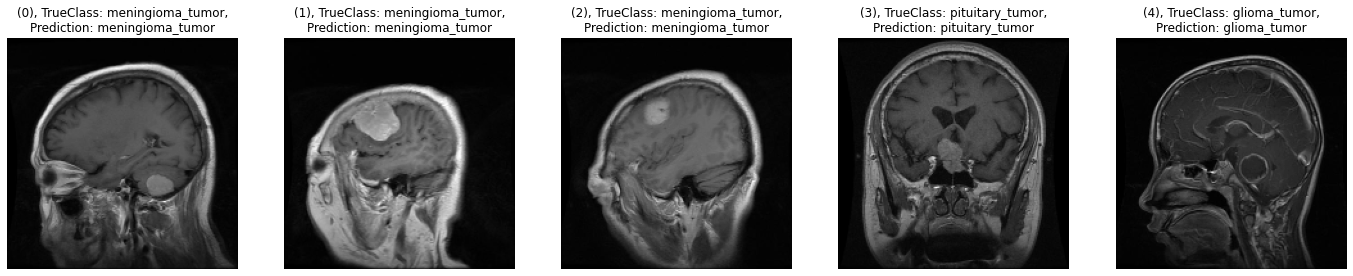

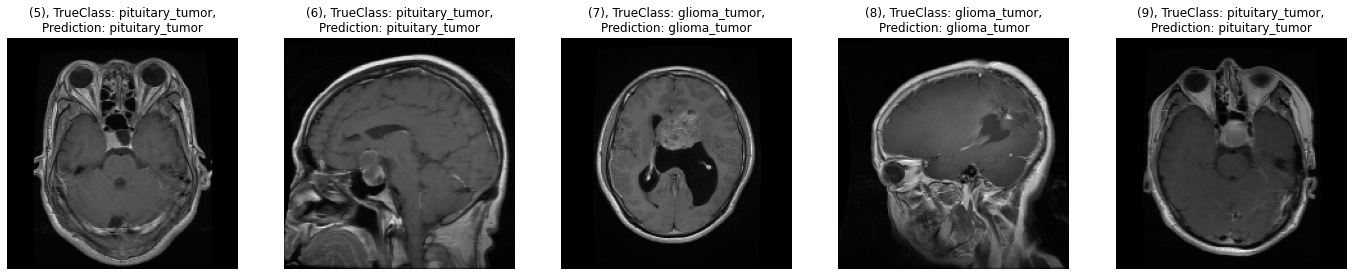

In [157]:
BaseModel.showPredictions(tumours.x_val, tumours.y_val, display_mode=1, max_out=10)

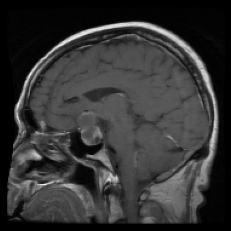

In [158]:
img = BaseModel.truePredictions[6][0]
imshow_(img)

##############################
# Features of pooling layers #
##############################



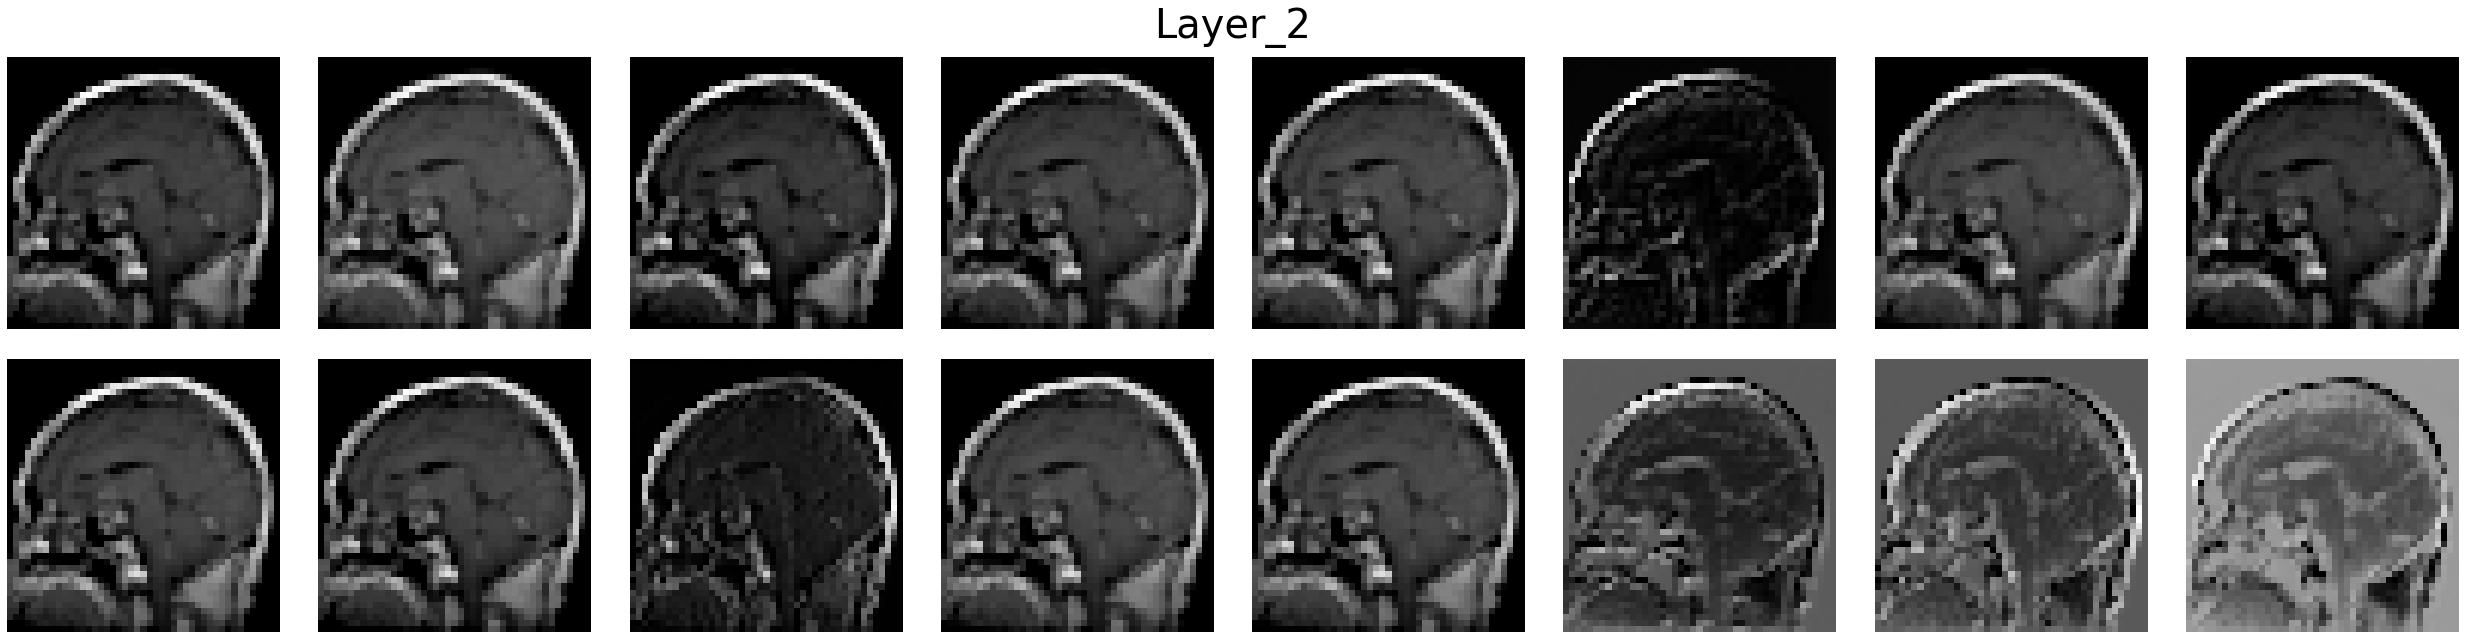

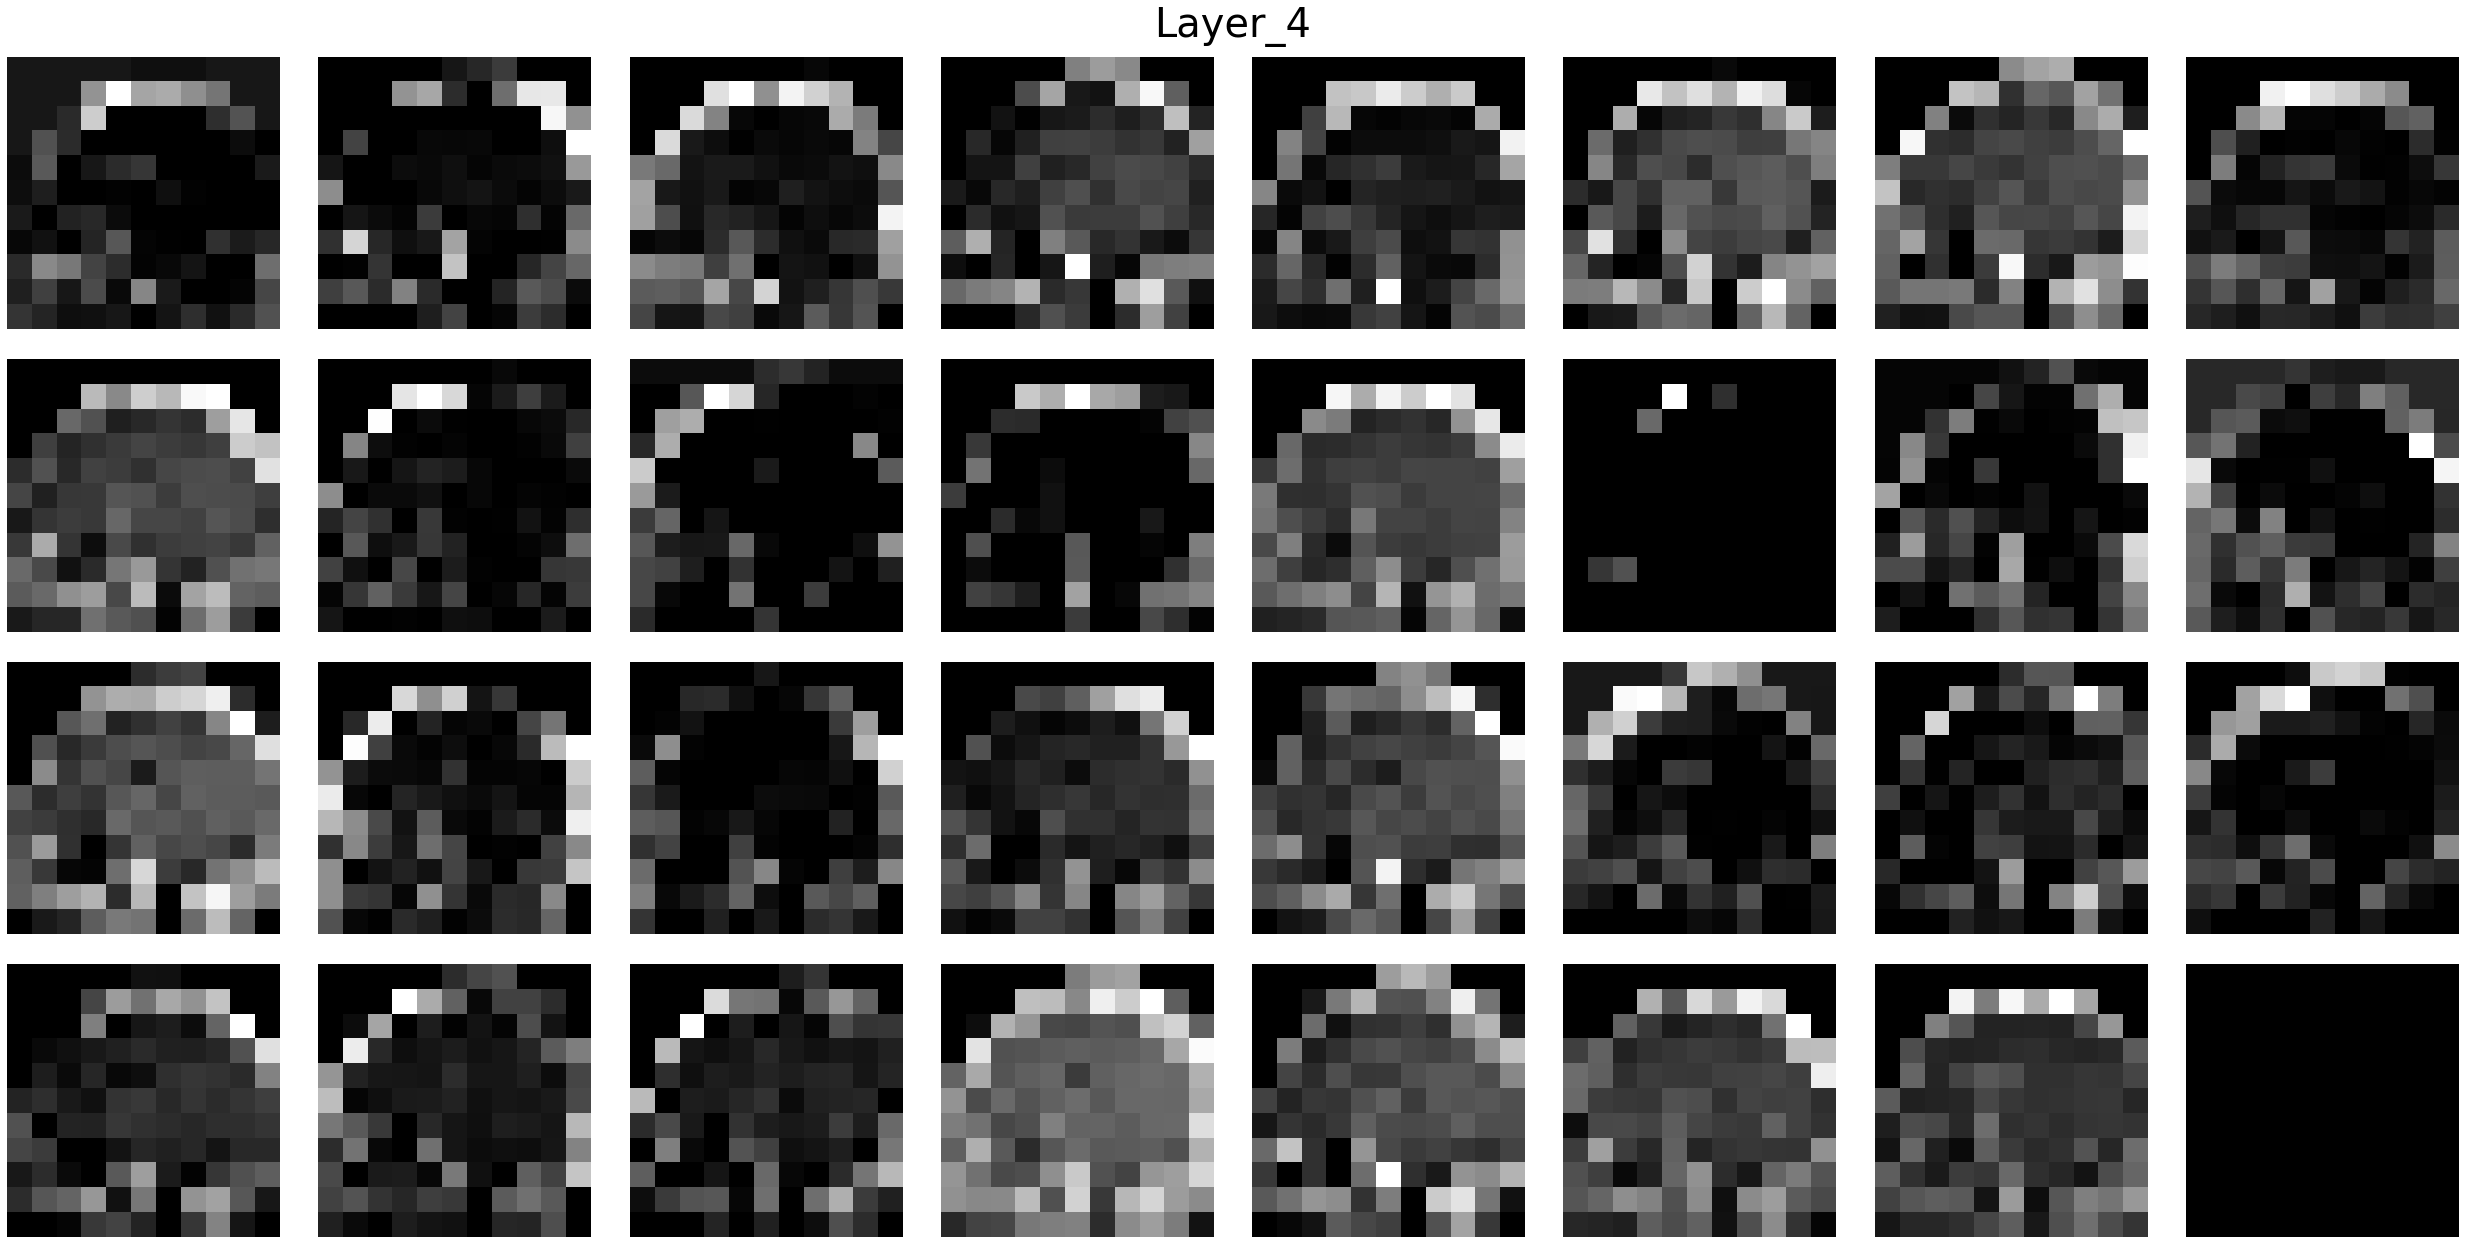

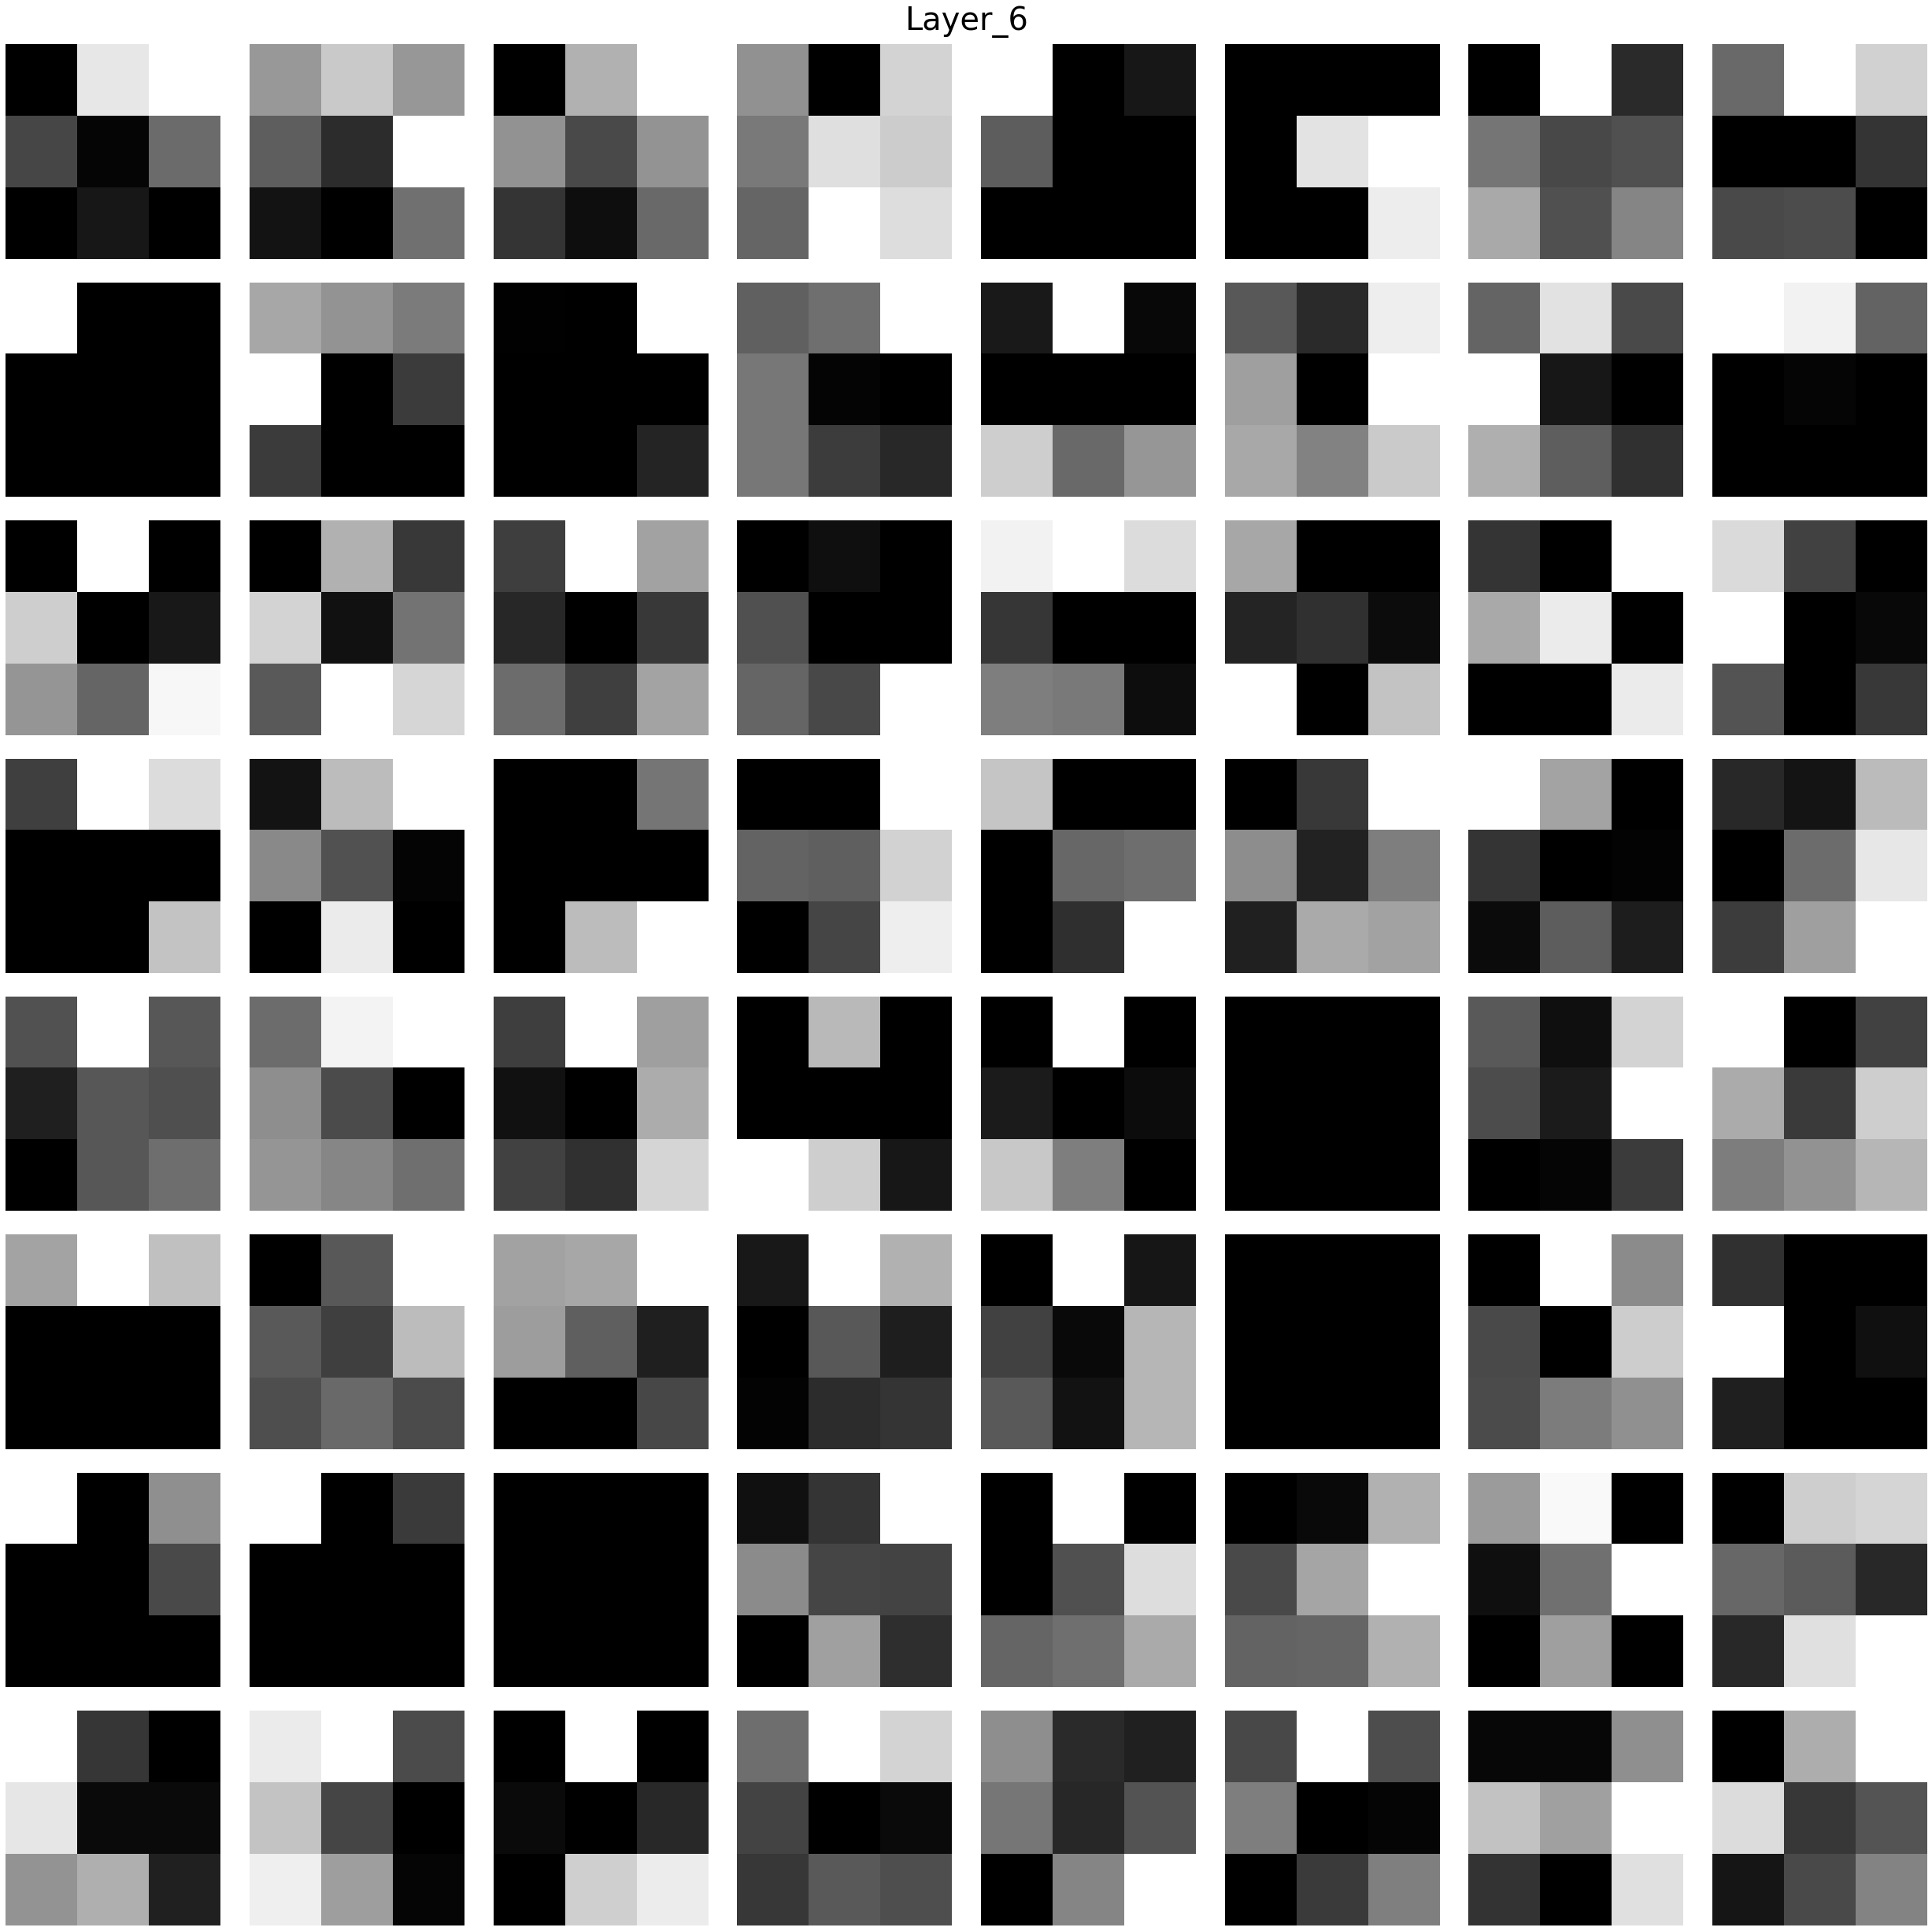

In [159]:
BaseModel.showFeatureMaps(layer='pool', image=img)

### Visualizing feature maps for incorrect predictions

167 incorrect predictions made.


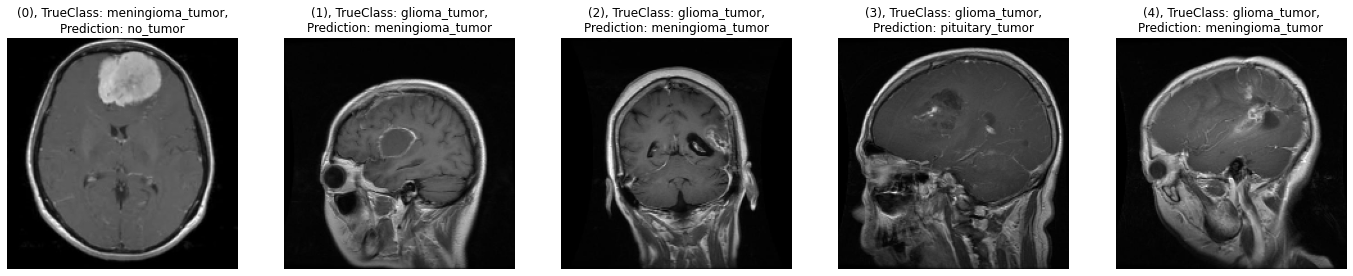

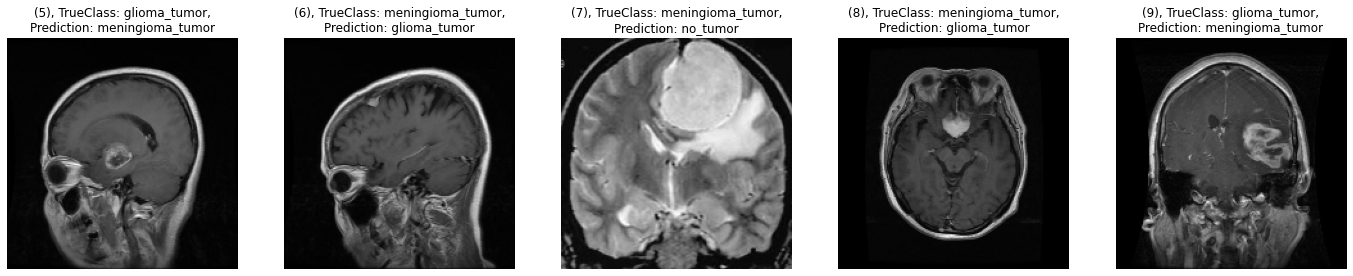

In [177]:
BaseModel.showPredictions(tumours.x_val, tumours.y_val, display_mode=0, max_out=10)

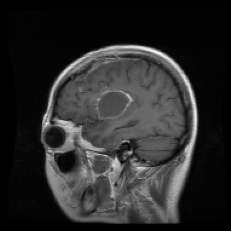

In [191]:
img = BaseModel.falsePredictions[1][0]
imshow_(img)

####################################
# Features of convolutional layers #
####################################



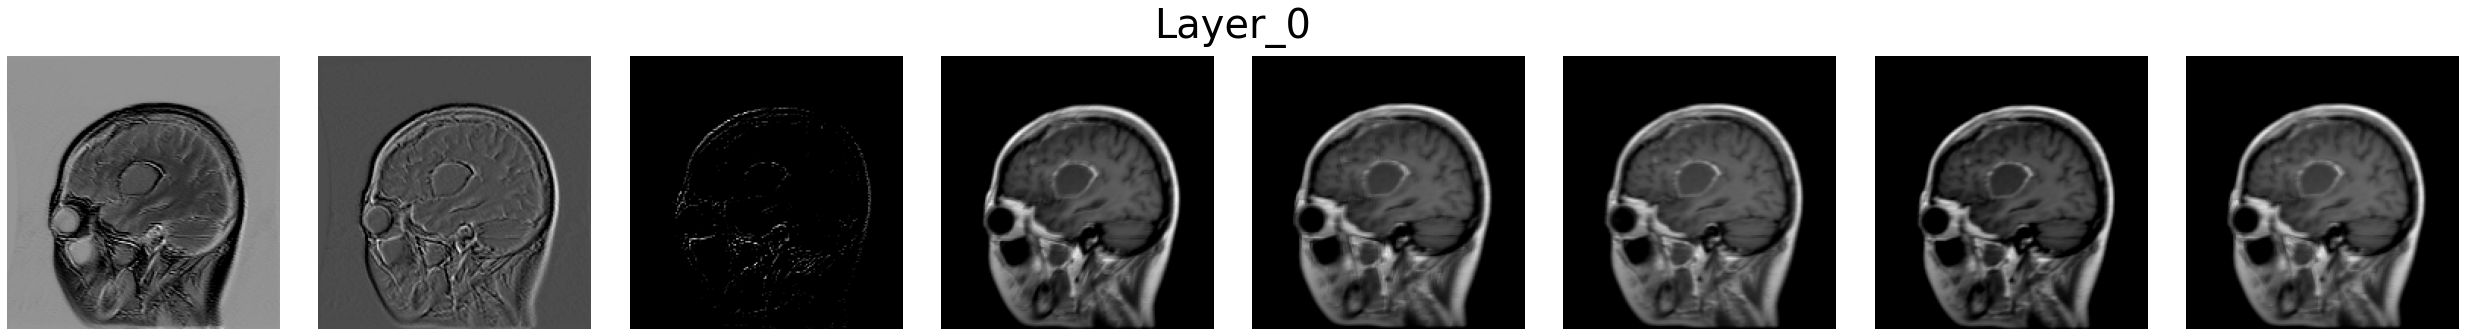

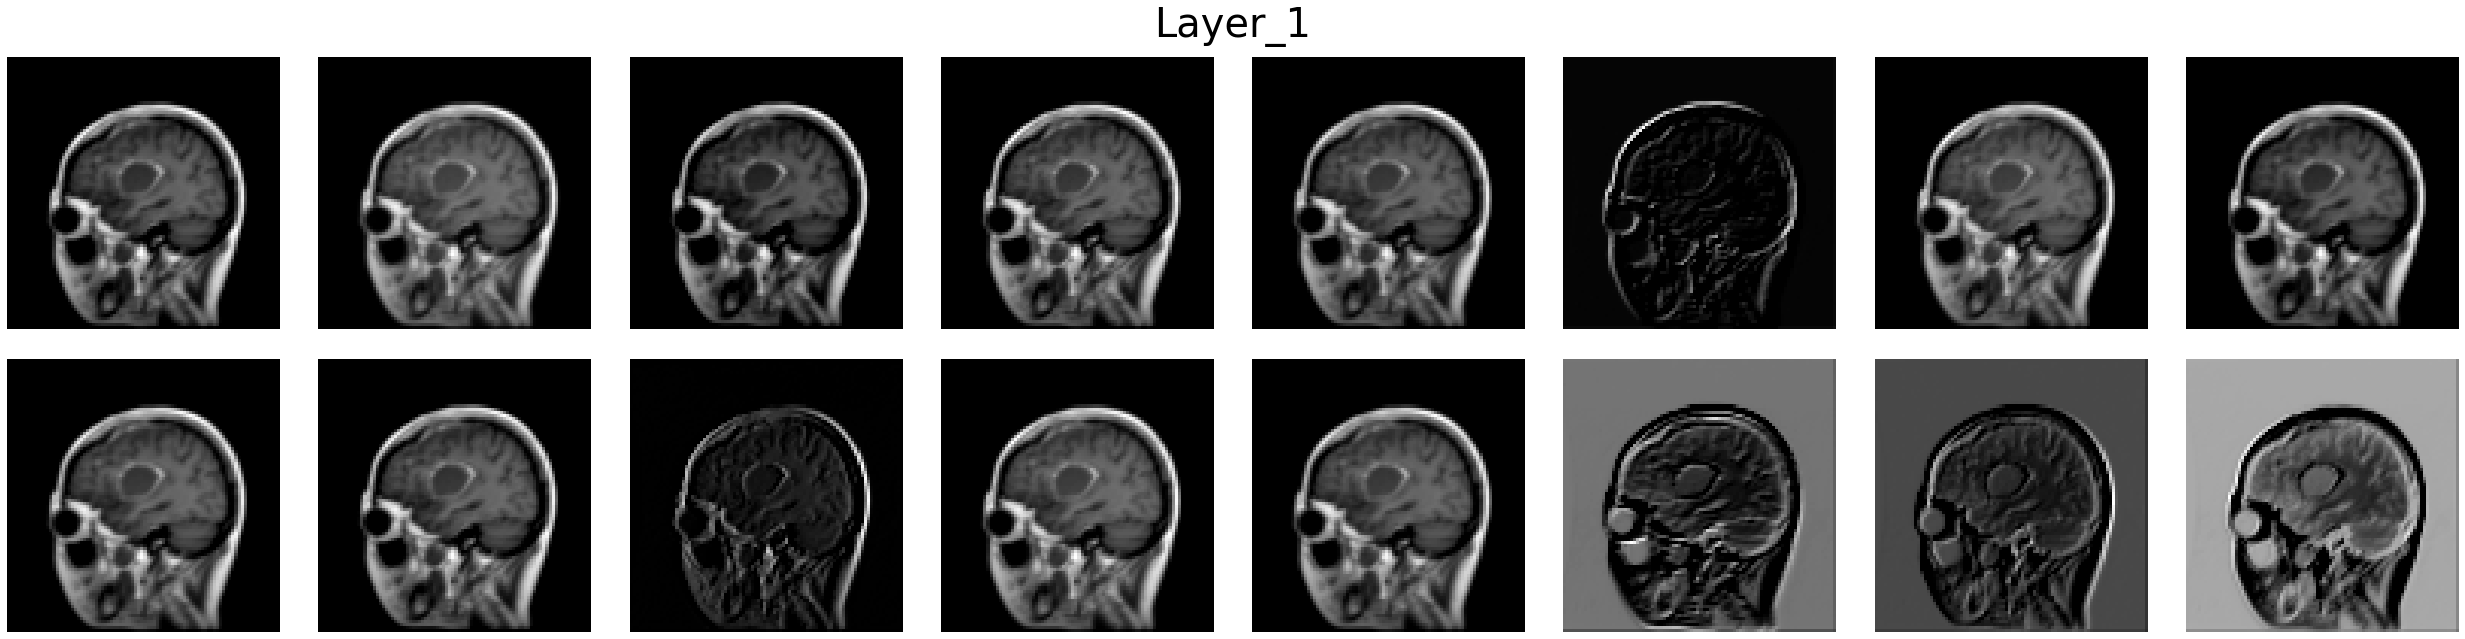

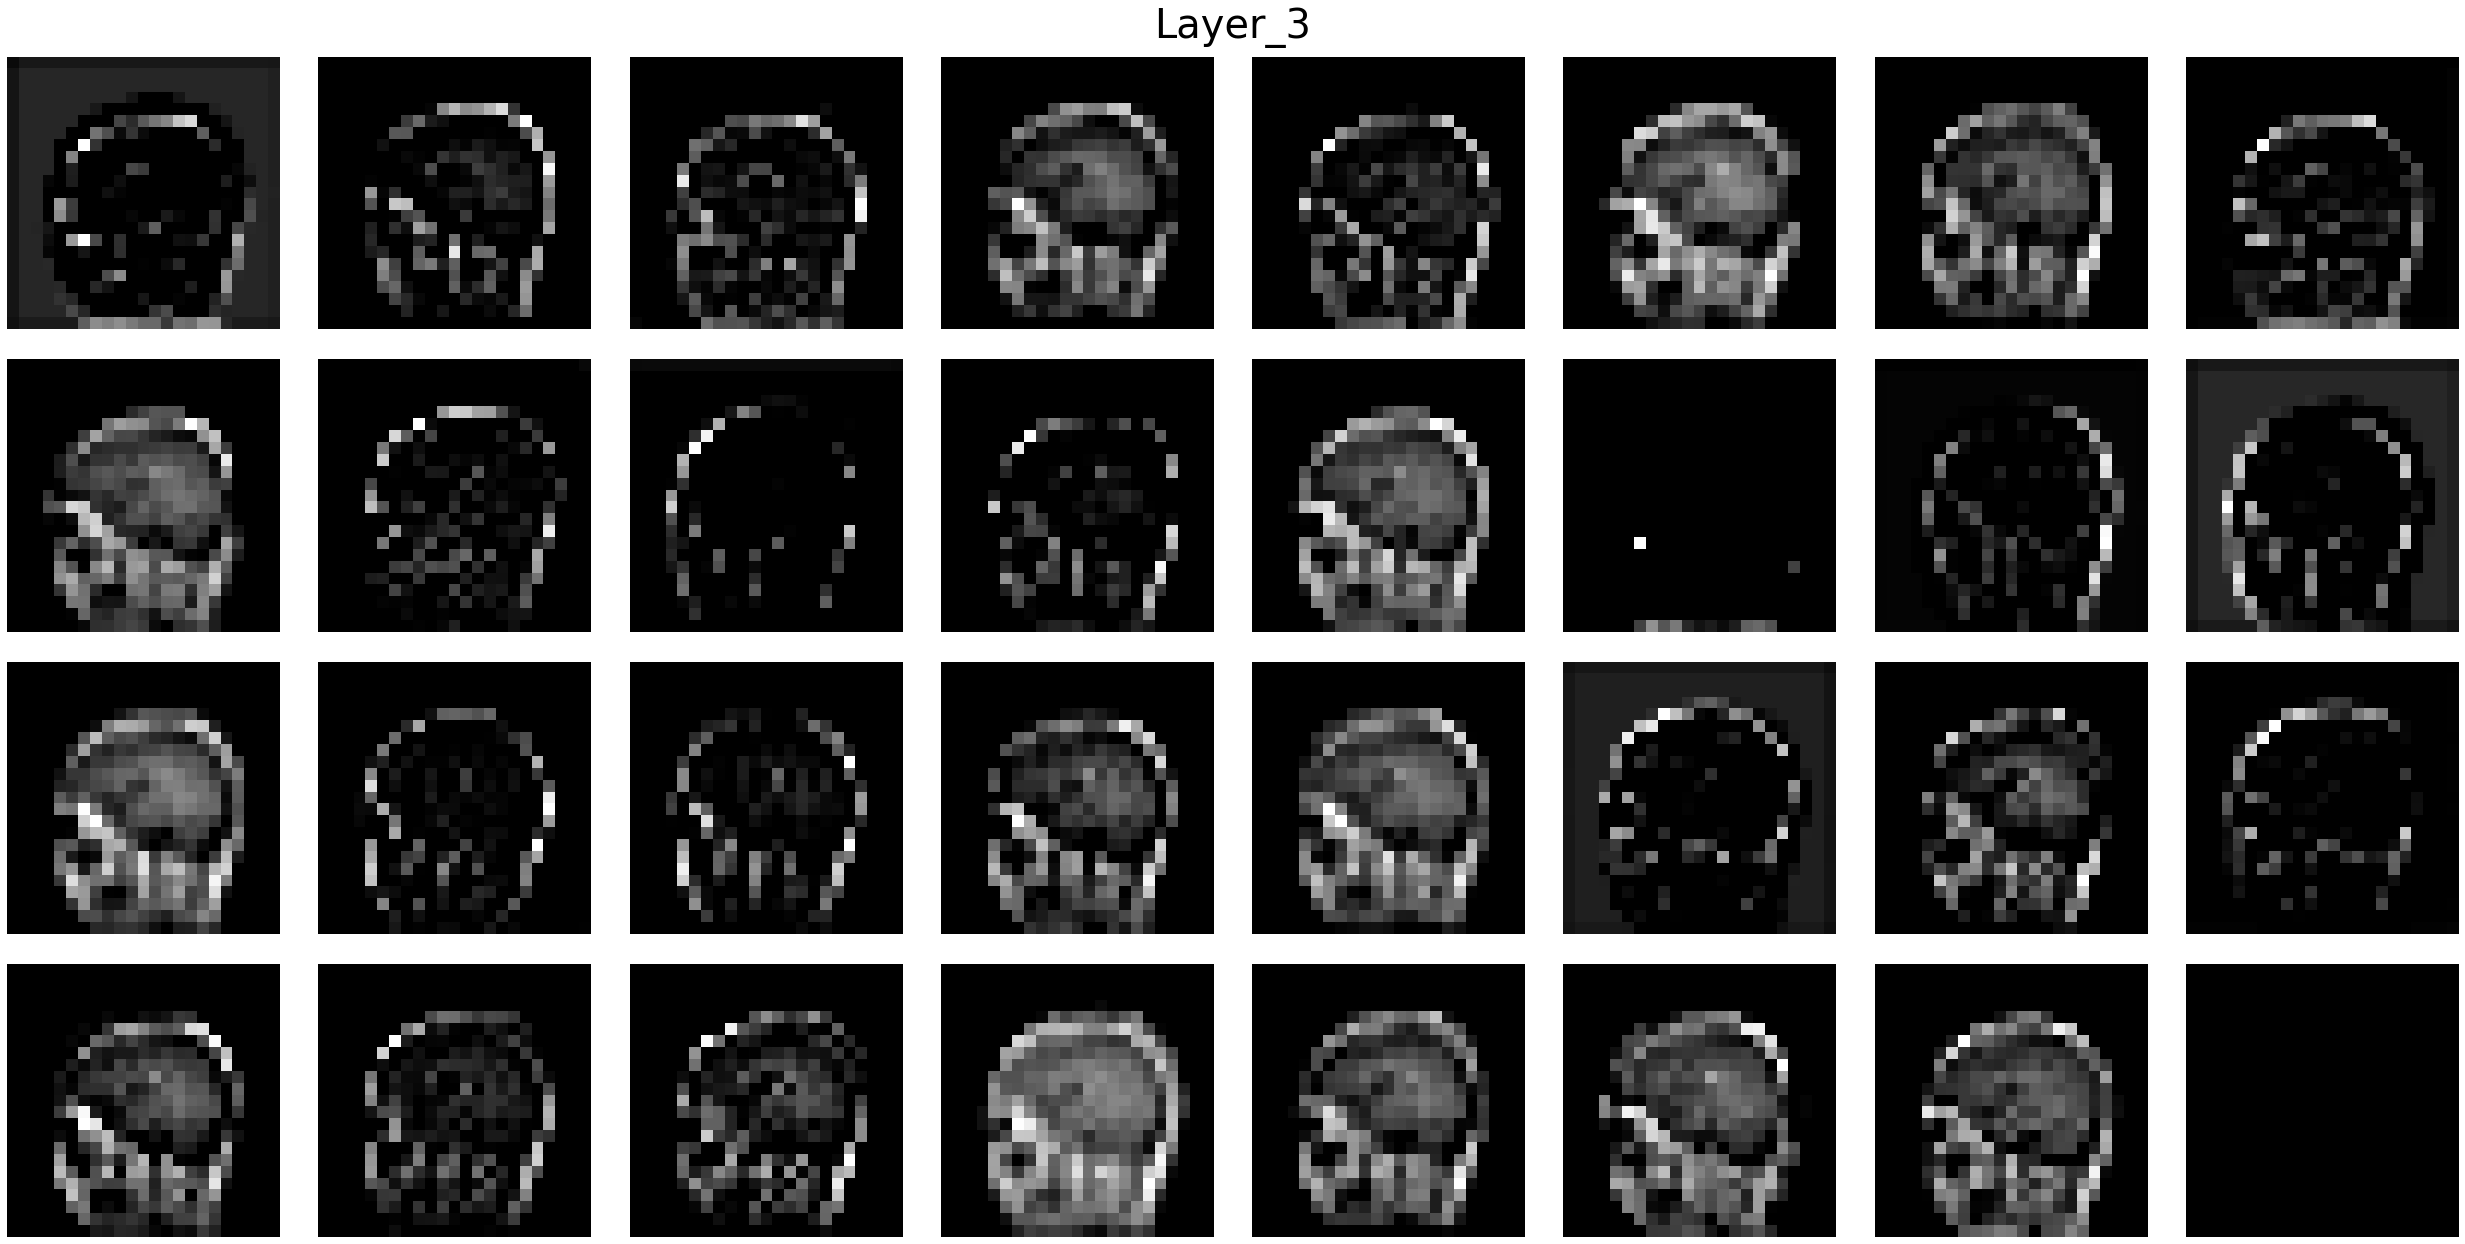

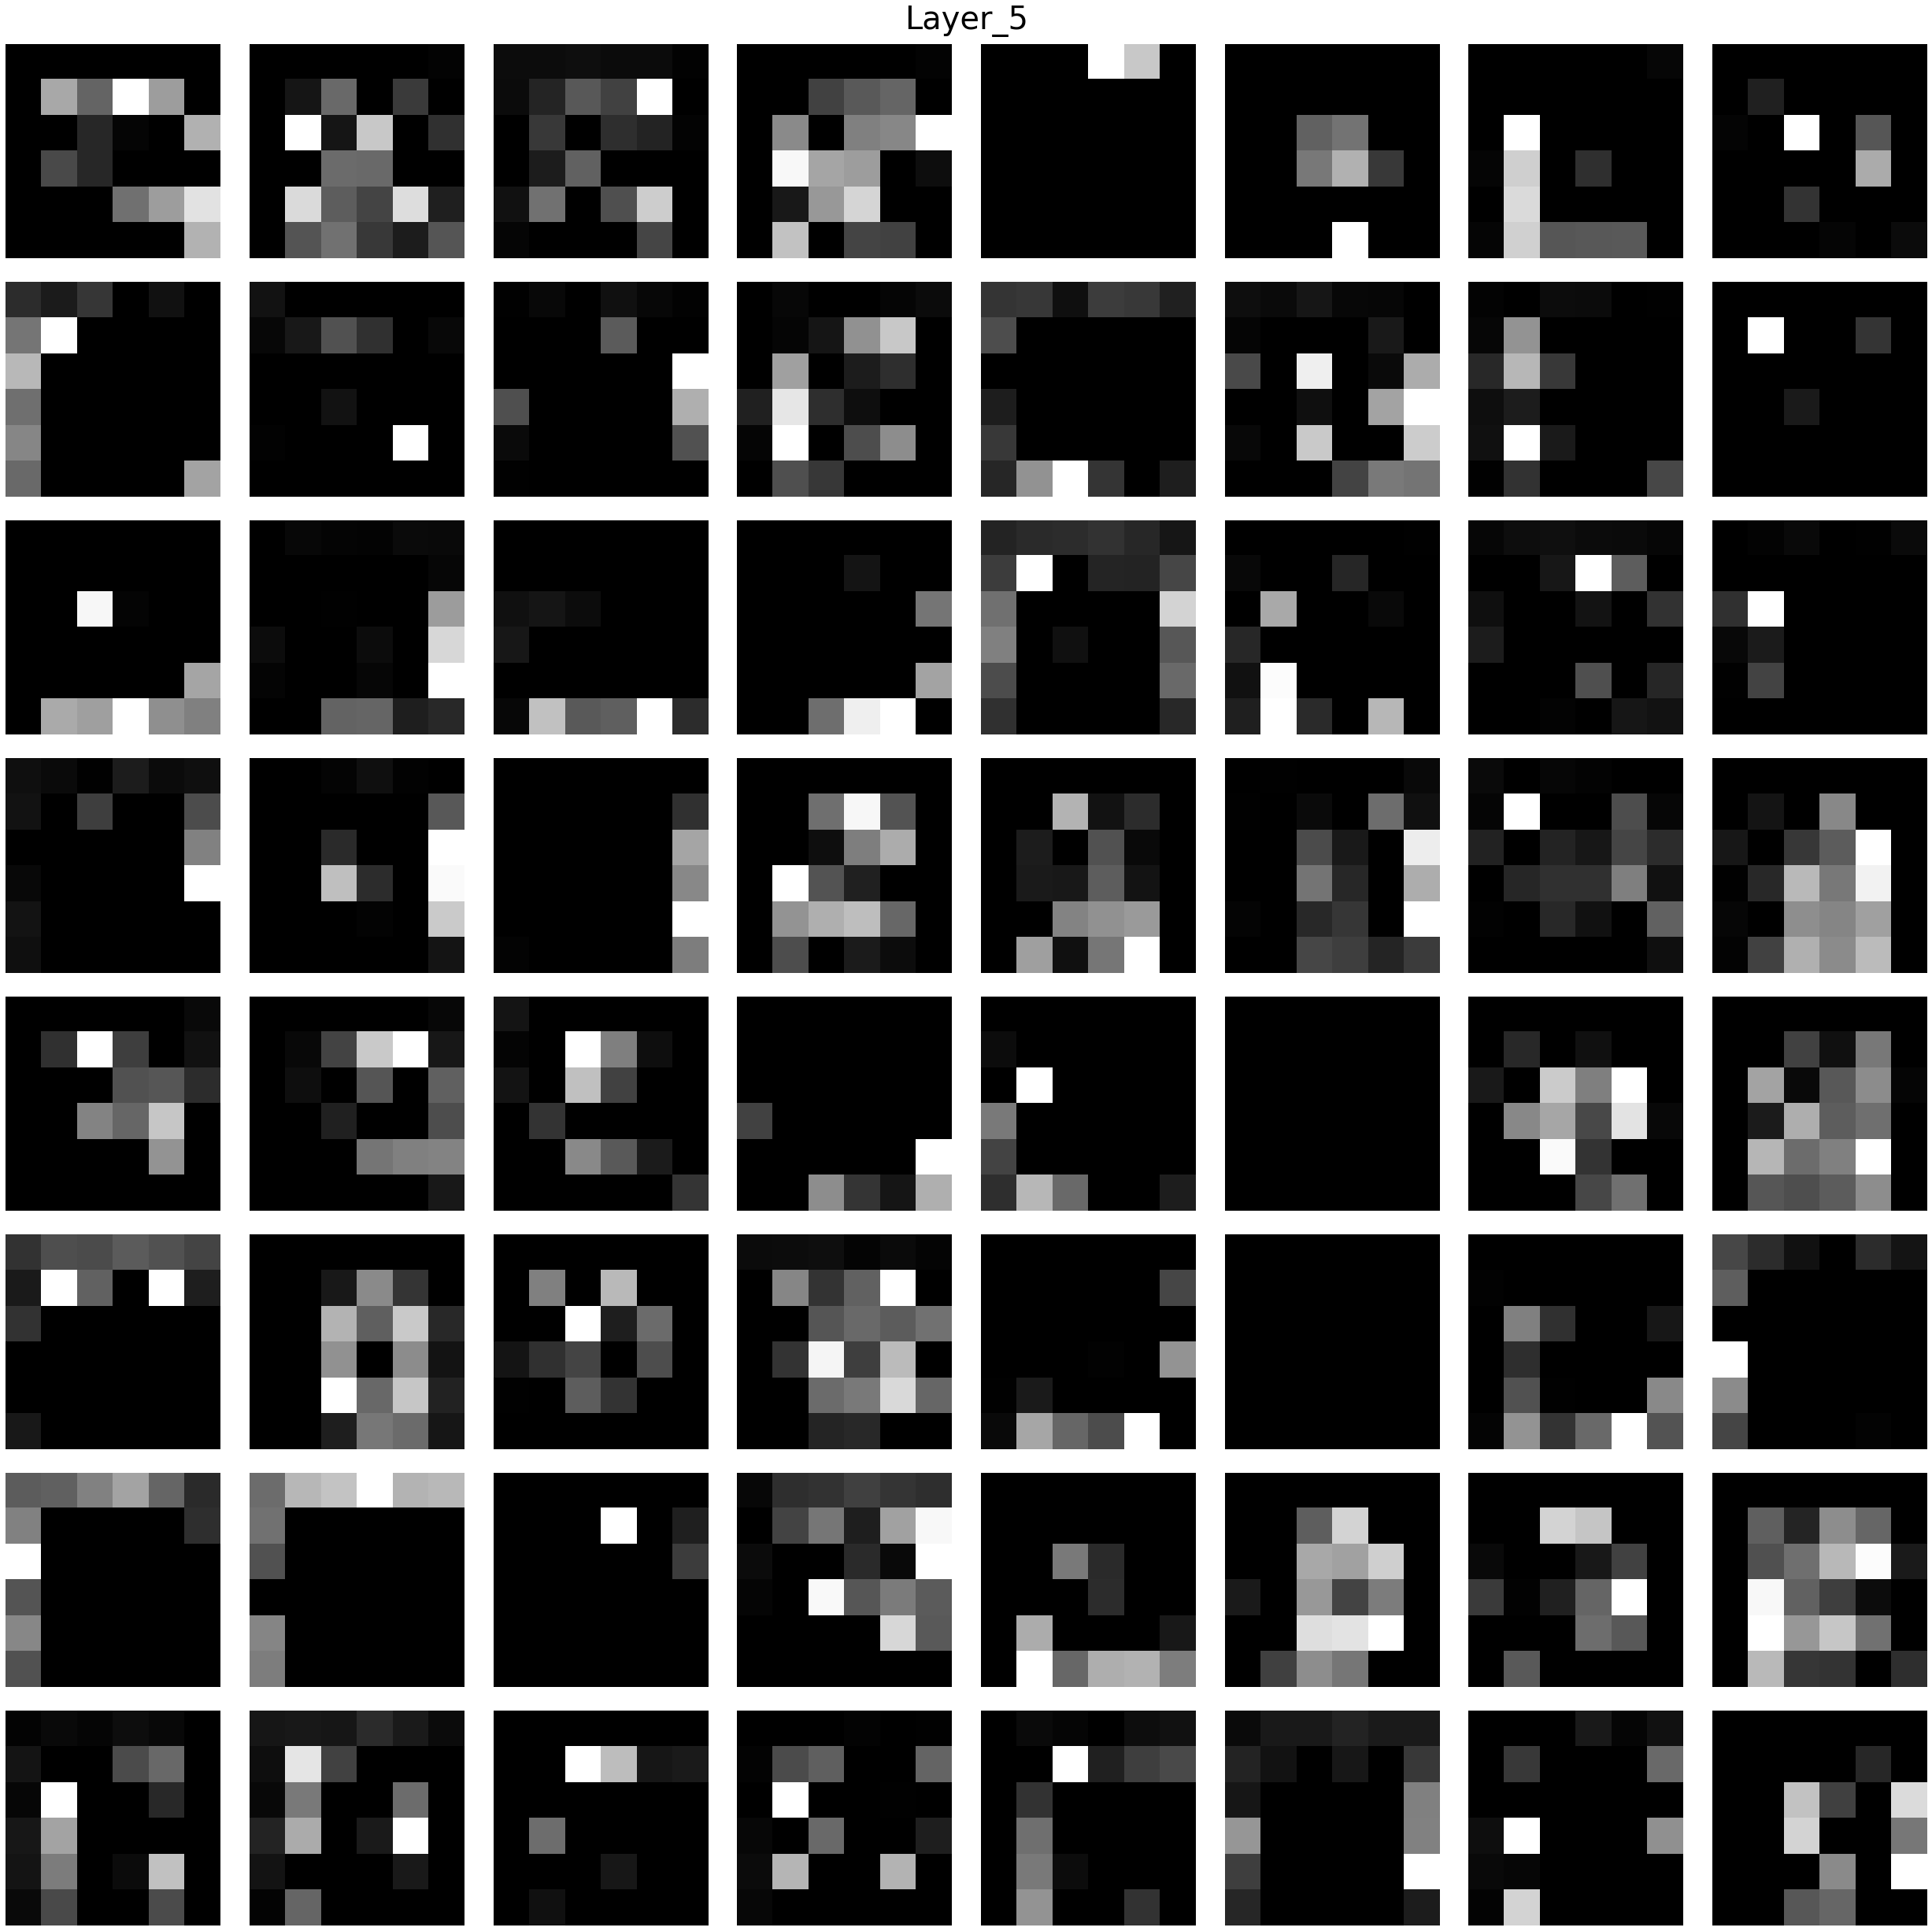

In [179]:
BaseModel.showFeatureMaps(layer='conv', image=img)

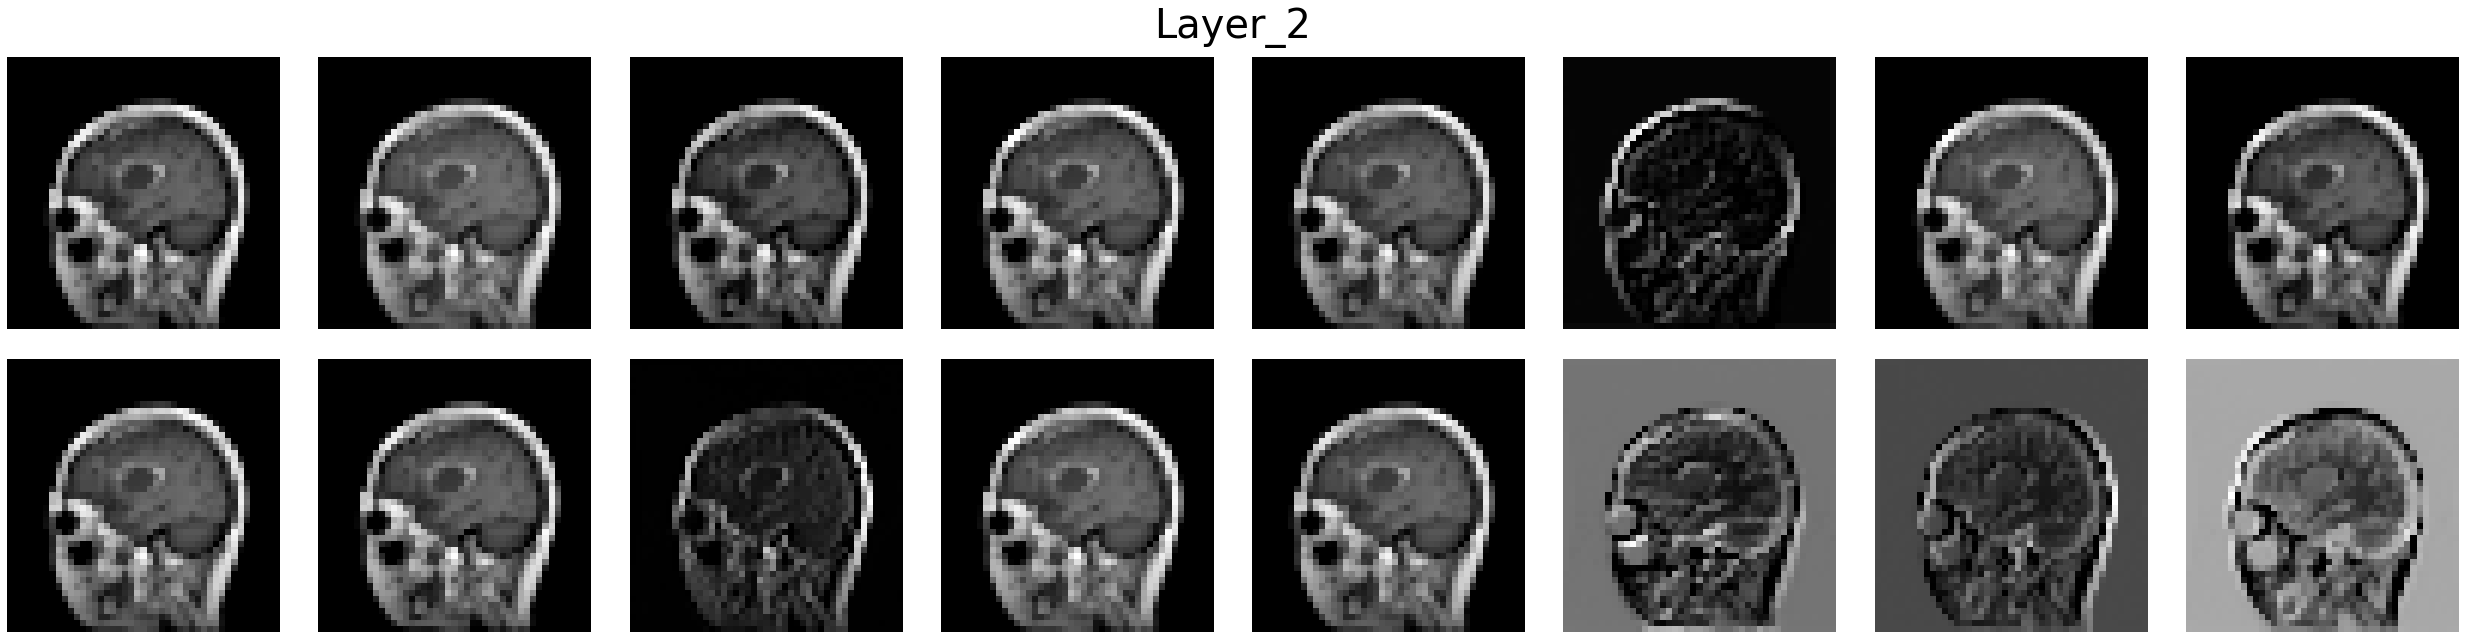

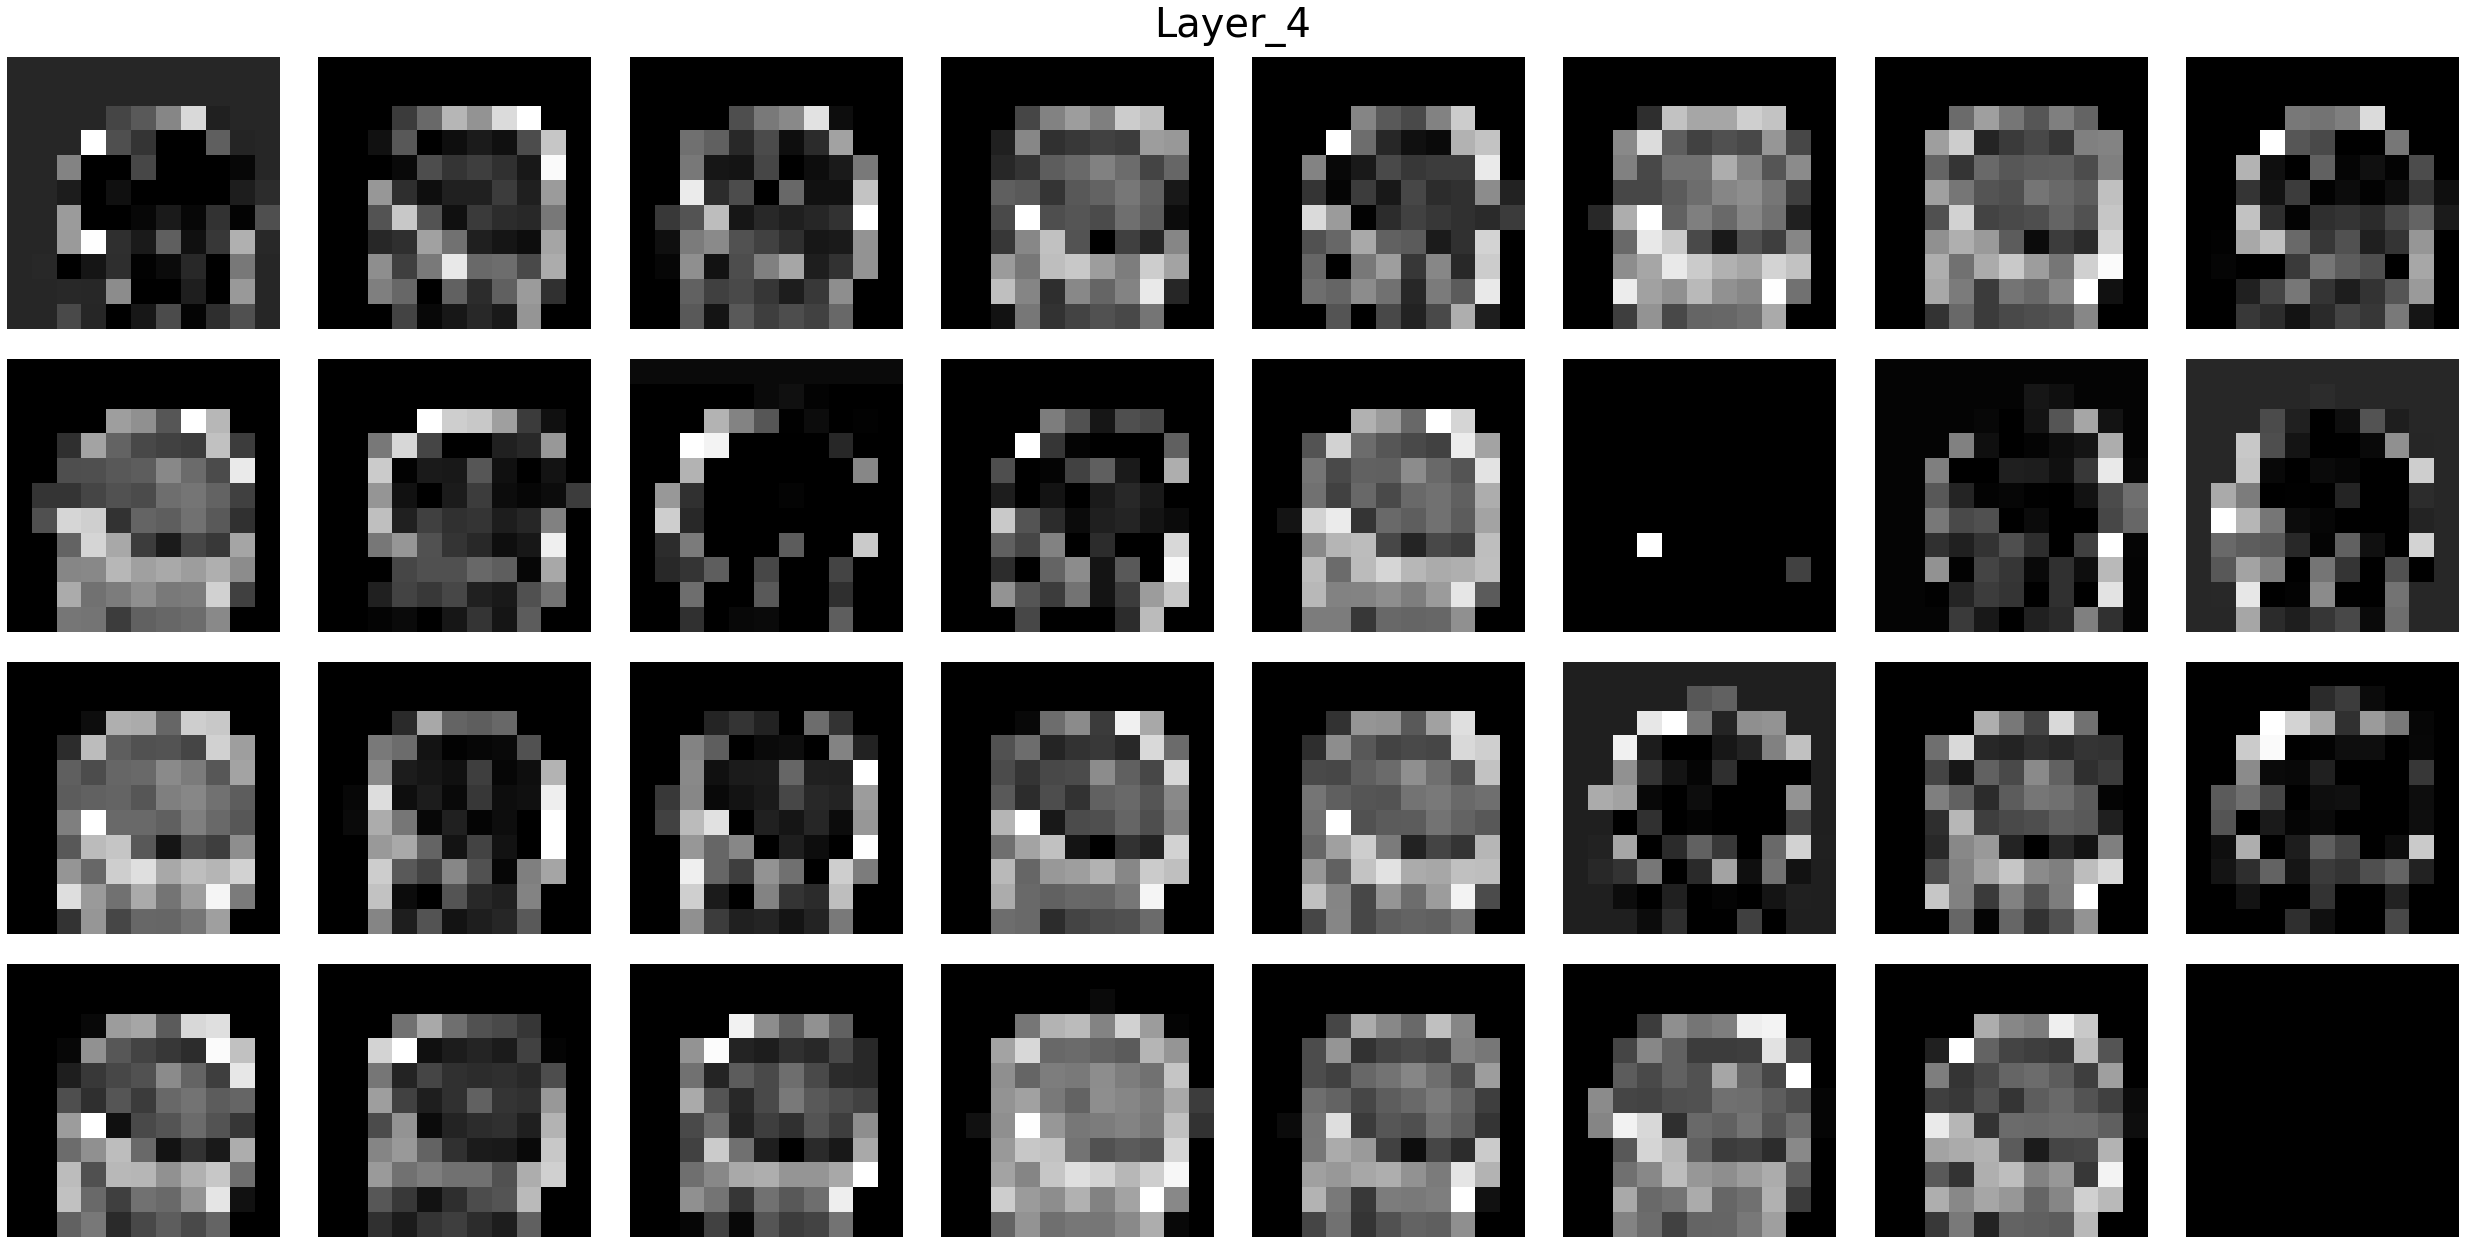

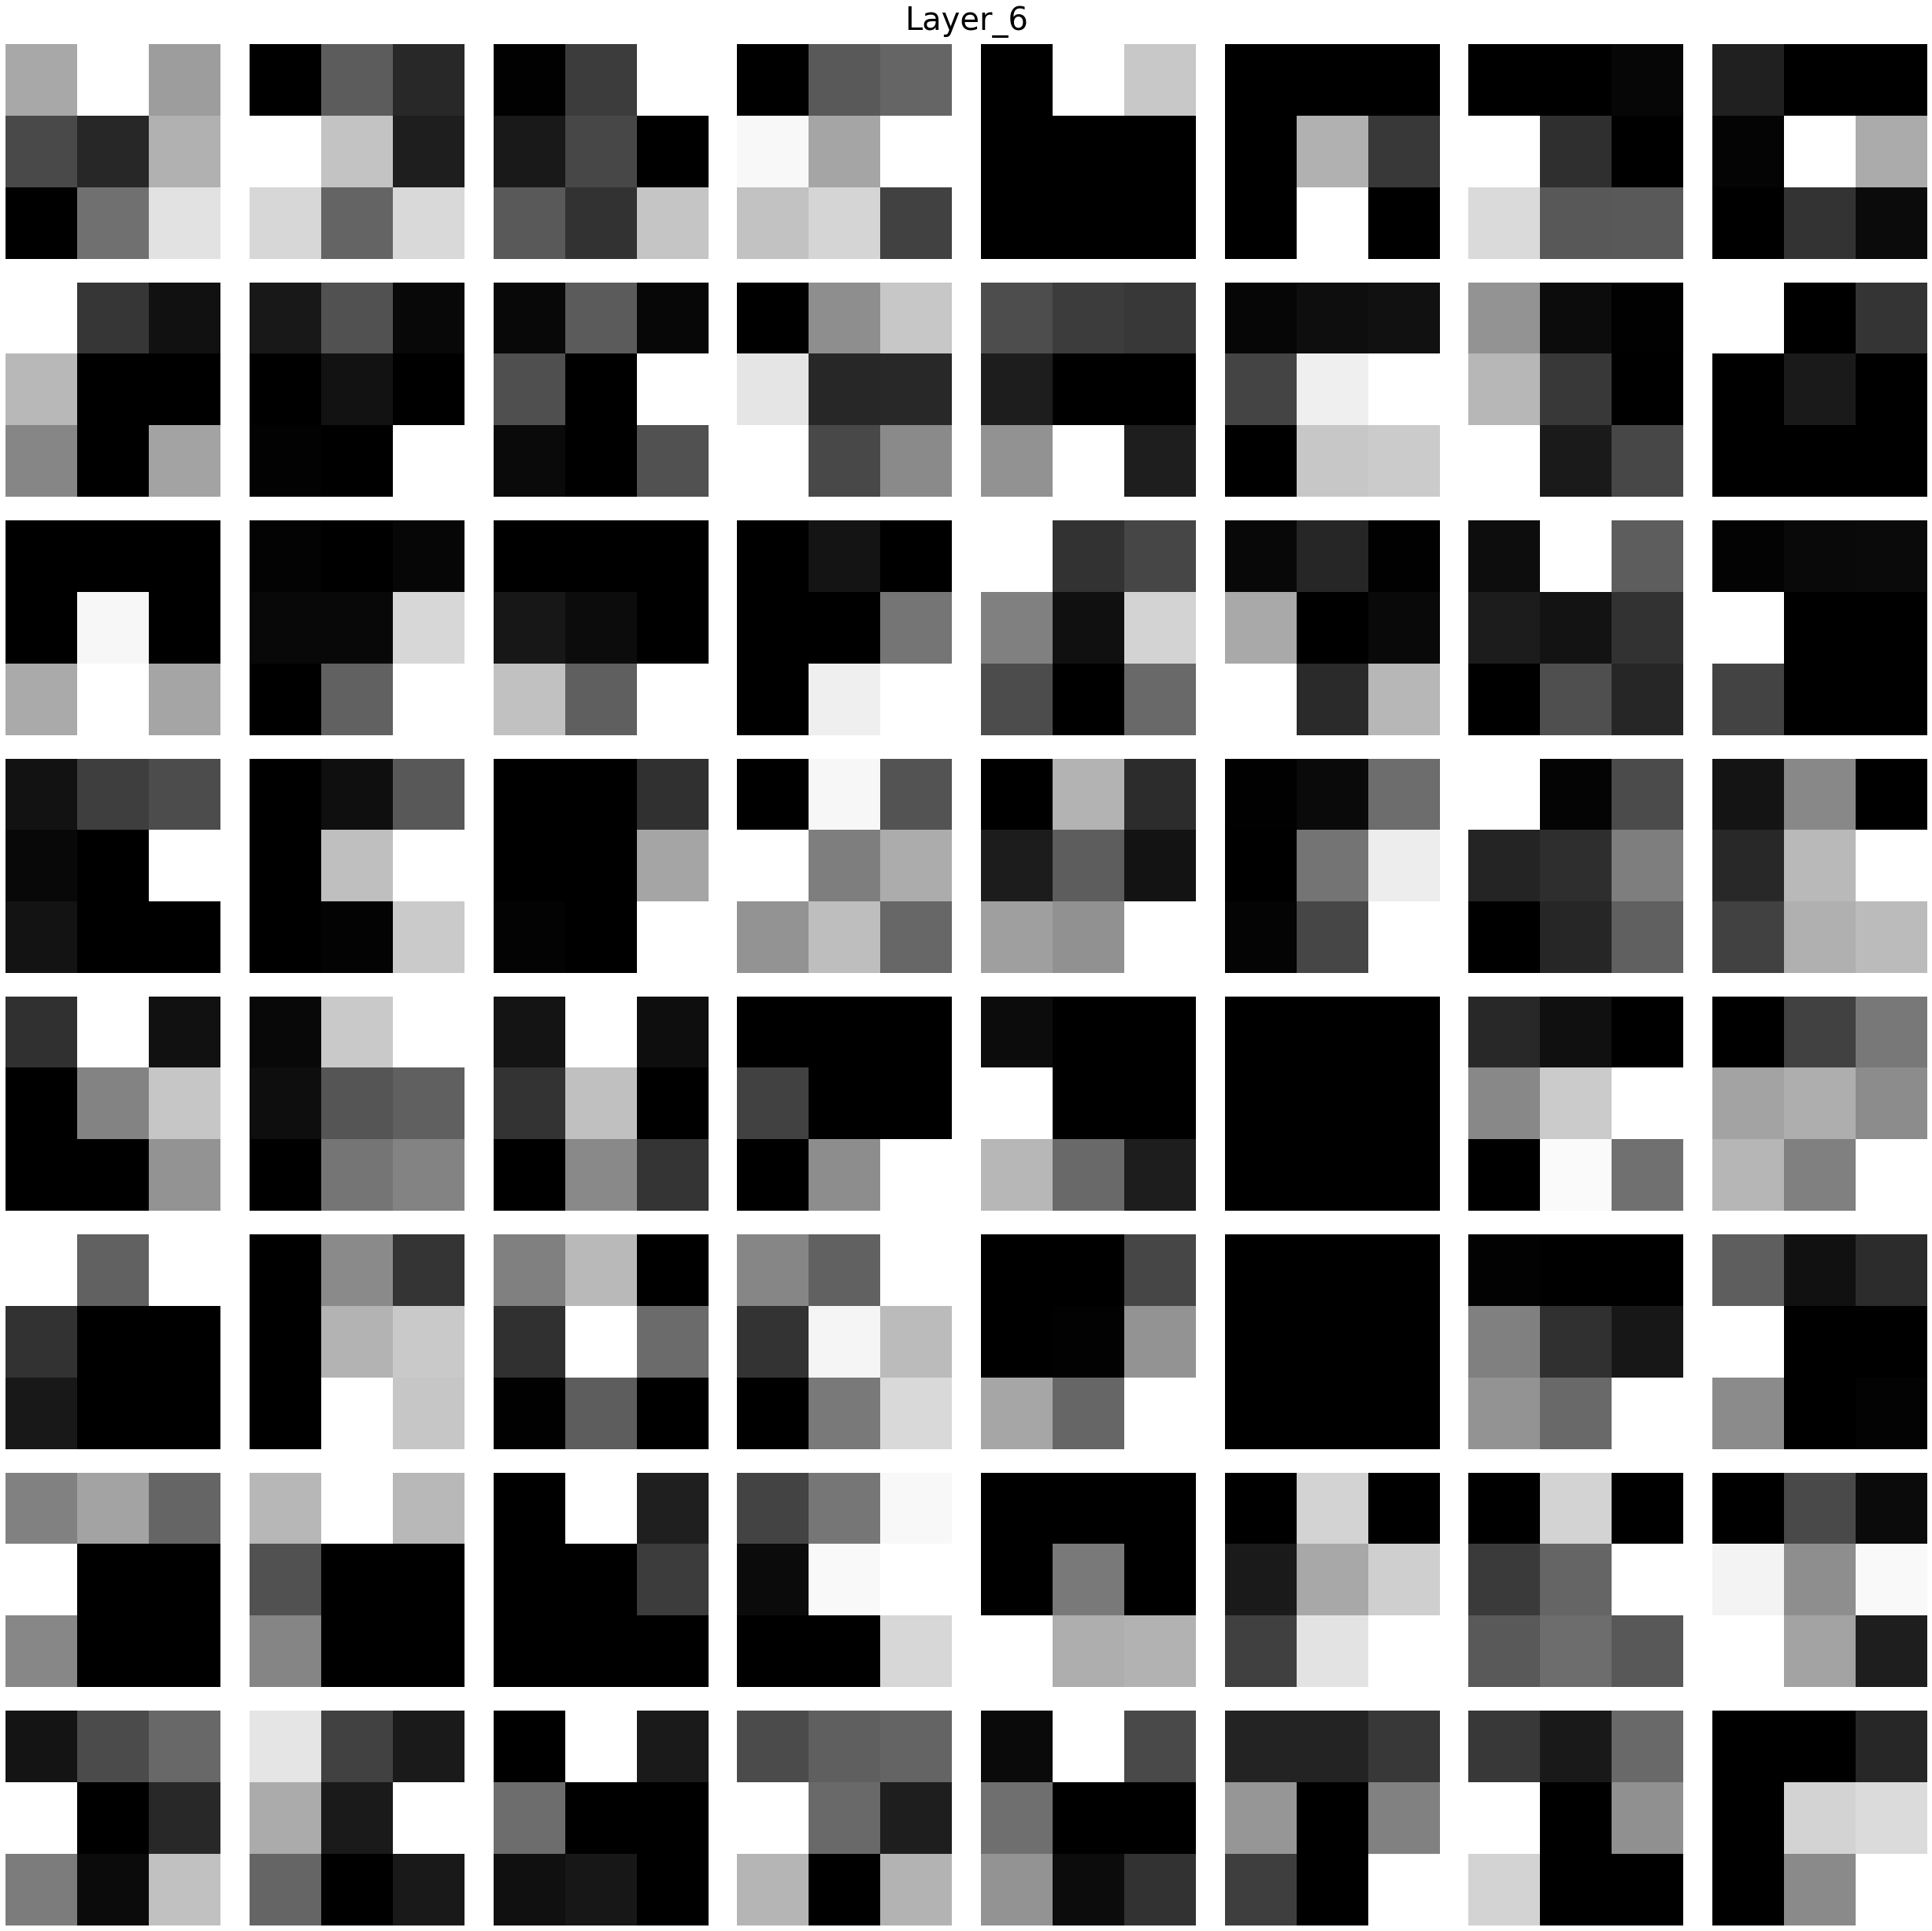

In [180]:
BaseModel.showFeatureMaps(layer='pool', image=img)

Interpreting these values without some processing is difficult at best.  
So, now we will implement Grad CAM to create heatmaps.

---
### 2. Quantify what features/filters are more important to the classification of which tumor types?

> Grad CAM Implementation

meningioma_tumor


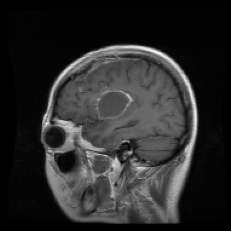

In [193]:
imshow_(img)
BaseModel.predictSingleImage(img) # True class is glioma

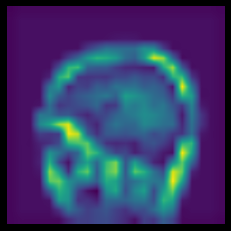

In [196]:
BaseModel.getHeatMap(img, new_size=(224, 224))

Actual no_tumor, Predicted meningioma_tumor


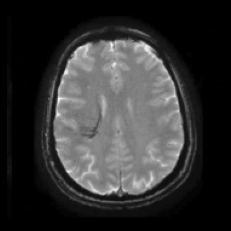

In [231]:
img = BaseModel.falsePredictions[42][0]
print(f'Actual {Images.classes[BaseModel.falsePredictions[42][1]]}, ' \
      f'Predicted {Images.classes[BaseModel.falsePredictions[42][2]]}')
imshow_(img)

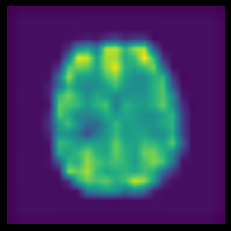

In [232]:
BaseModel.getHeatMap(img)

### Driving on the BestModel from Phase 1

In [26]:
BestModel = CNNModel(
    depth=3,
    kernel_size=5,
    filters=8,
    addDropouts=True,
    optimizer=Adam(learning_rate=0.0008)
)
BestModel.describe()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Conv2D)              (None, 180, 180, 8)       208       
                                                                 
 conv1 (Conv2D)              (None, 90, 90, 16)        3216      
                                                                 
 drop1 (Dropout)             (None, 90, 90, 16)        0         
                                                                 
 pool1 (MaxPooling2D)        (None, 45, 45, 16)        0         
                                                                 
 conv2 (Conv2D)              (None, 23, 23, 32)        12832     
                                                                 
 drop2 (Dropout)             (None, 23, 23, 32)        0         
                                                                 
 pool2 (MaxPooling2D)        (None, 11, 11, 32)       

In [29]:
%%time
folds = 5

accuracy__ = numpy.zeros((folds))

for i in range(folds):
    tumours = Images(180, validation_ratio=0.2, random_state=None)
    tumours.shuffleData(mode='training')
    tumours.shuffleData(mode='validation')
    validation_data_points = tumours.y_val.shape[0]
    training_data_points = tumours.y_train.shape[0]
    print('#'*39)
    print(f'# Starting cross-validation in fold {i} #')
    print('#'*39, end='\n'*2)
    print(f'Training on {training_data_points} and validating in ' \
          f'{validation_data_points} datapoints.')
    print()
    
    print('Training in progress ...')
    
    BestModel.train(
        tumours.x_train, tumours.y_train,
        validation_data=(tumours.x_val, tumours.y_val),
        batch_size=64,
        epochs=100,
    )

    print('Training complete! fetching performance report...')
    
    accuracy__[i] = max(BestModel.getDataPoints(mode='accuracy'))
    BestModel.makePrediction(tumours.x_val)
    BestModel.getClassificationReport(tumours.y_val)

print(f'Mean accuracy : {numpy.mean(accuracy__)}')

#######################################
# Starting cross-validation in fold 0 #
#######################################

Training on 2296 and validating in 574 datapoints.

Training in progress ...
Training complete! fetching performance report...

Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.91      0.92       172
           1       0.88      0.92      0.90       160
           2       0.96      0.85      0.90        85
           3       0.95      0.97      0.96       157

    accuracy                           0.92       574
   macro avg       0.93      0.91      0.92       574
weighted avg       0.92      0.92      0.92       574

#######################################
# Starting cross-validation in fold 1 #
#######################################

Training on 2296 and validating in 574 datapoints.

Training in progress ...
Training complete! fetching performance report...

Classification Report:

              preci

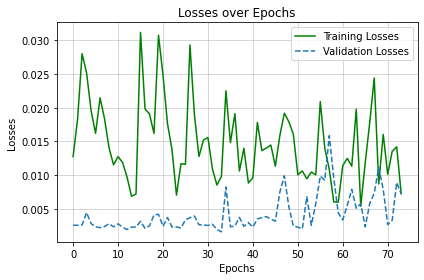

In [32]:
BestModel.plotLosses()

In [31]:
BestModel.finalTest()


Confusion Matrix:

             labels  glioma_tumor  meningioma_tumor  no_tumor  pituitary_tumor
0      glioma_tumor            23                40        29                8
1  meningioma_tumor             0               113         1                1
2          no_tumor             0                 0       105                0
3   pituitary_tumor             1                 4        13               56

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.23      0.37       100
           1       0.72      0.98      0.83       115
           2       0.71      1.00      0.83       105
           3       0.86      0.76      0.81        74

    accuracy                           0.75       394
   macro avg       0.81      0.74      0.71       394
weighted avg       0.80      0.75      0.71       394



###################################
# Filters of convolutional layers #
###################################



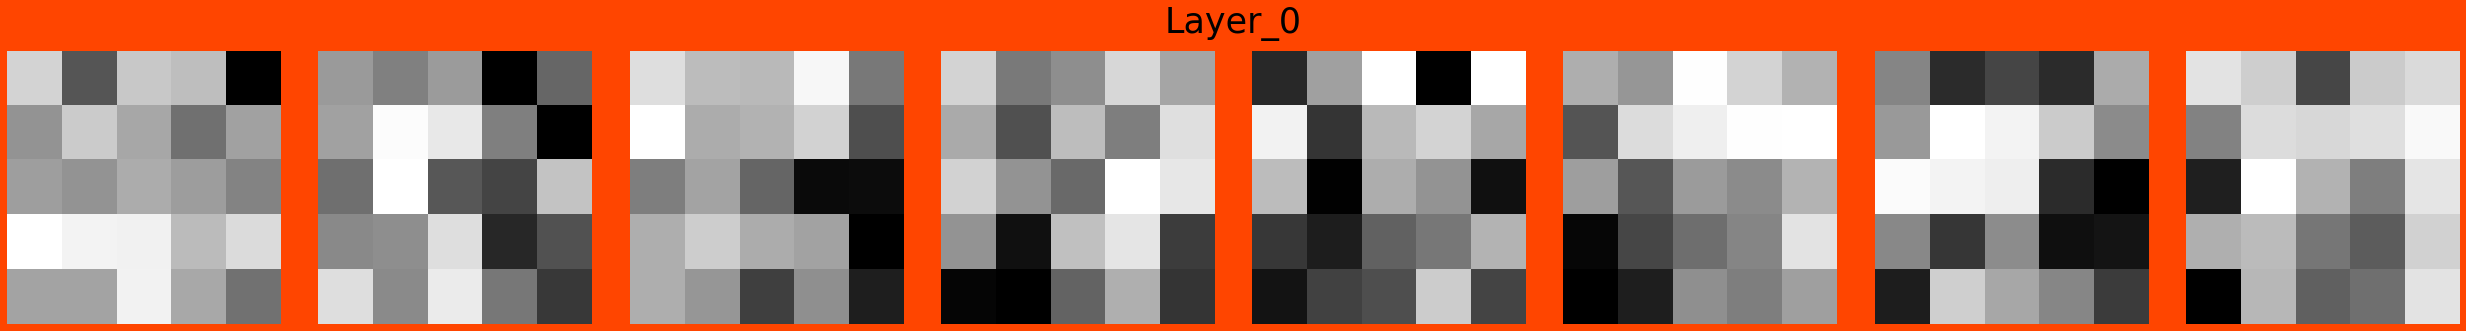

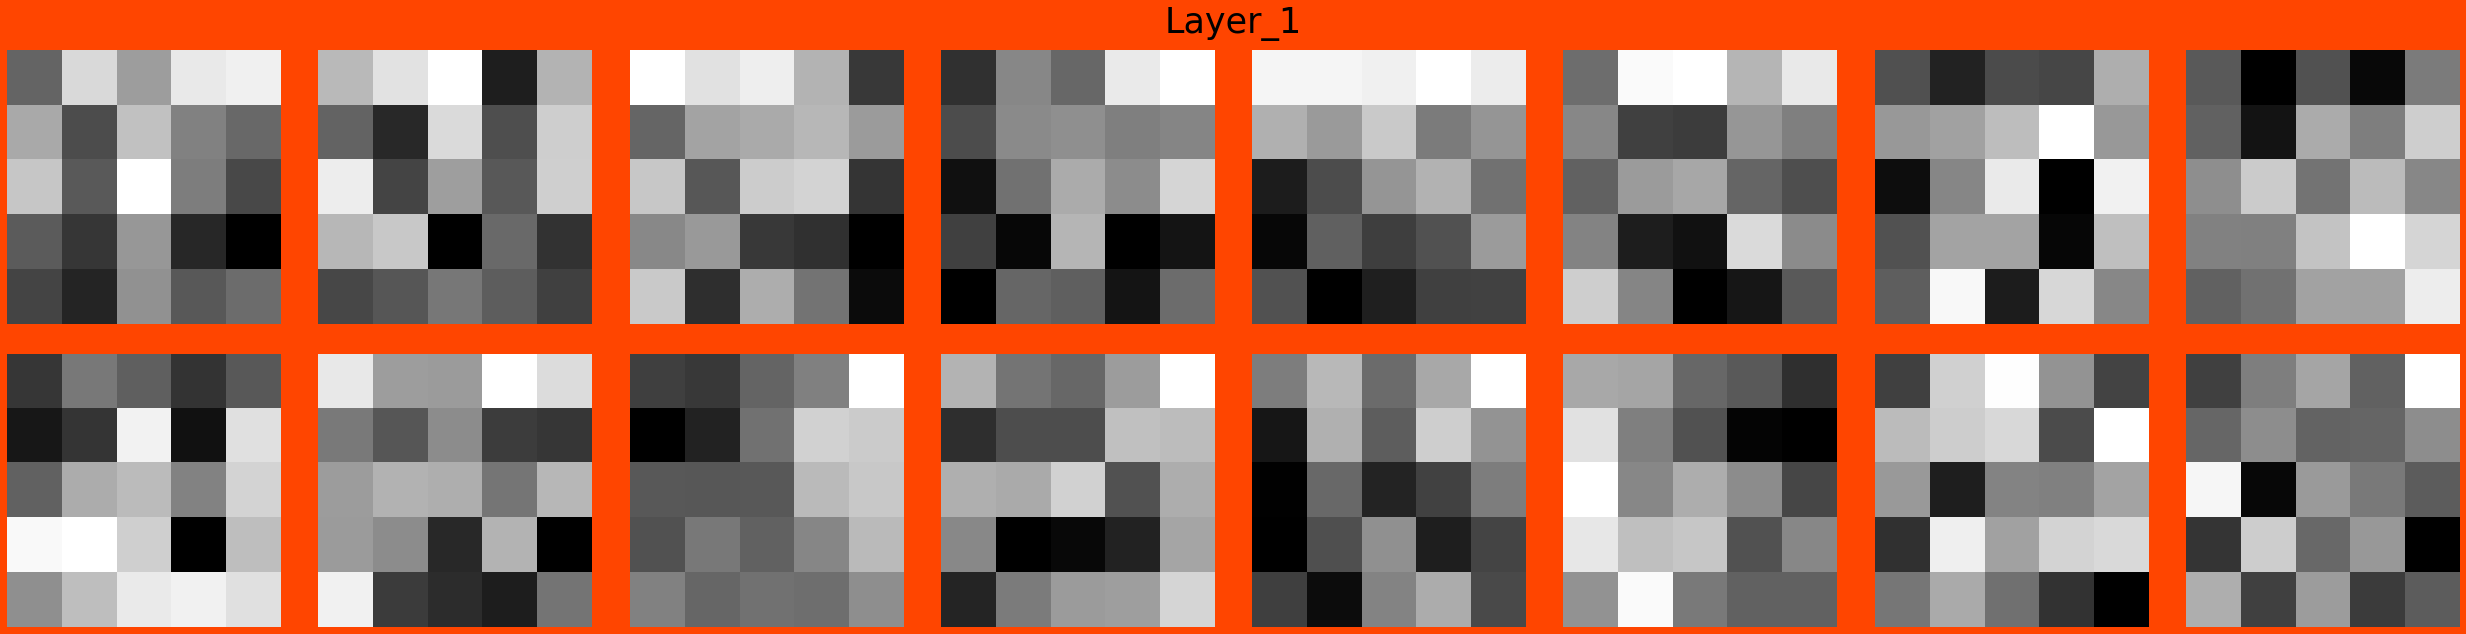

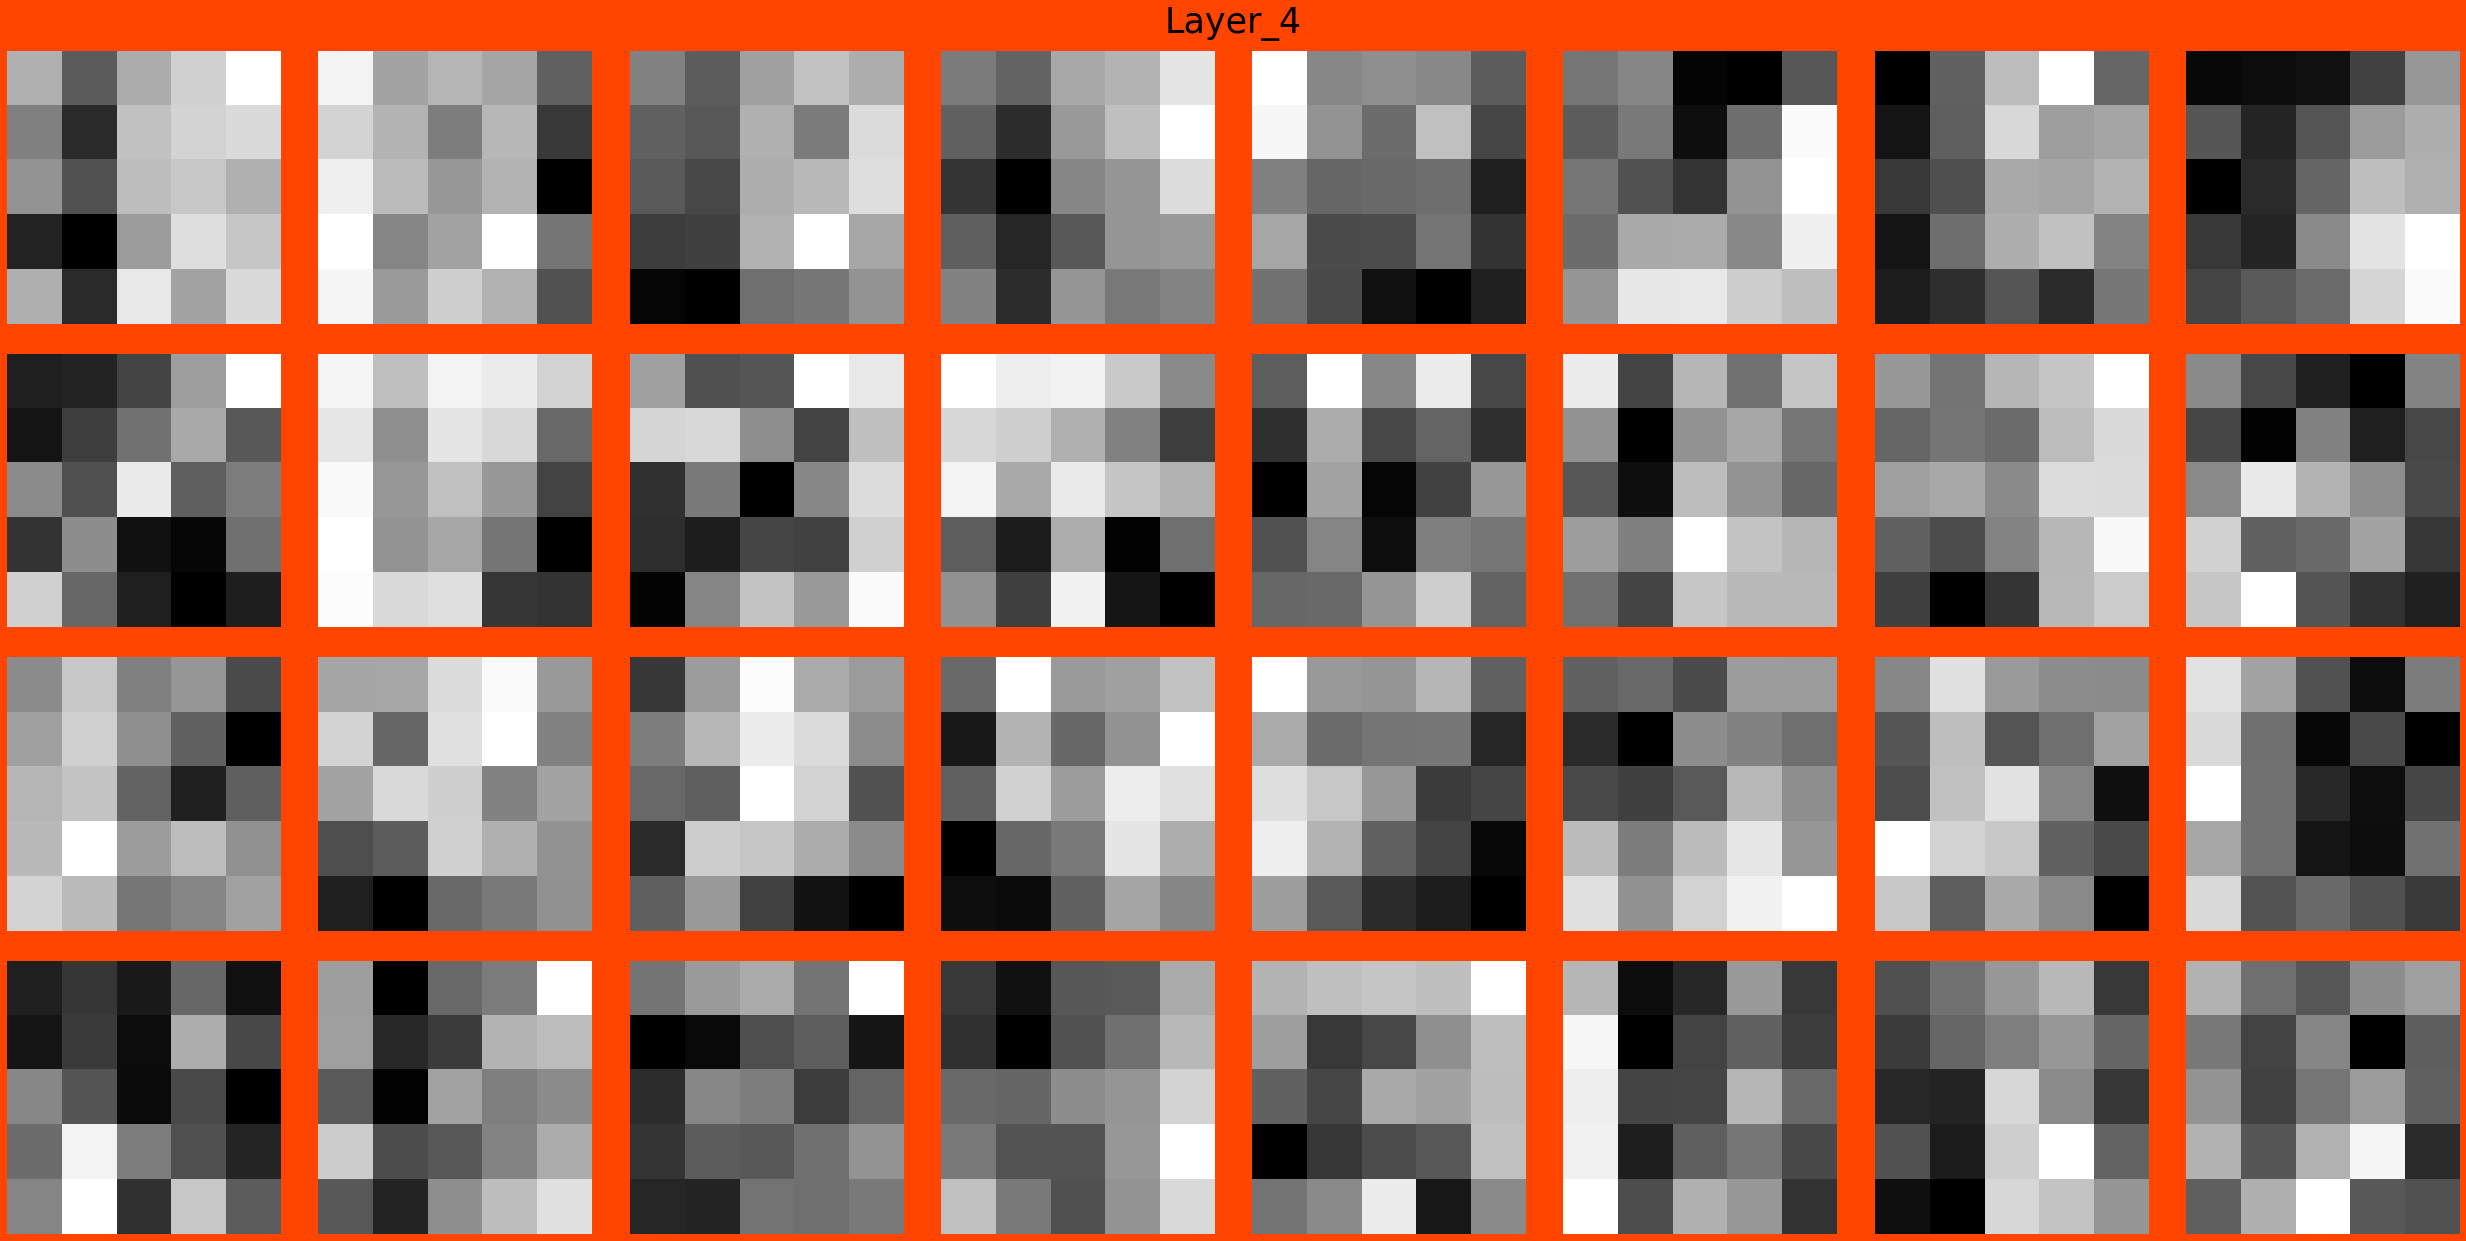

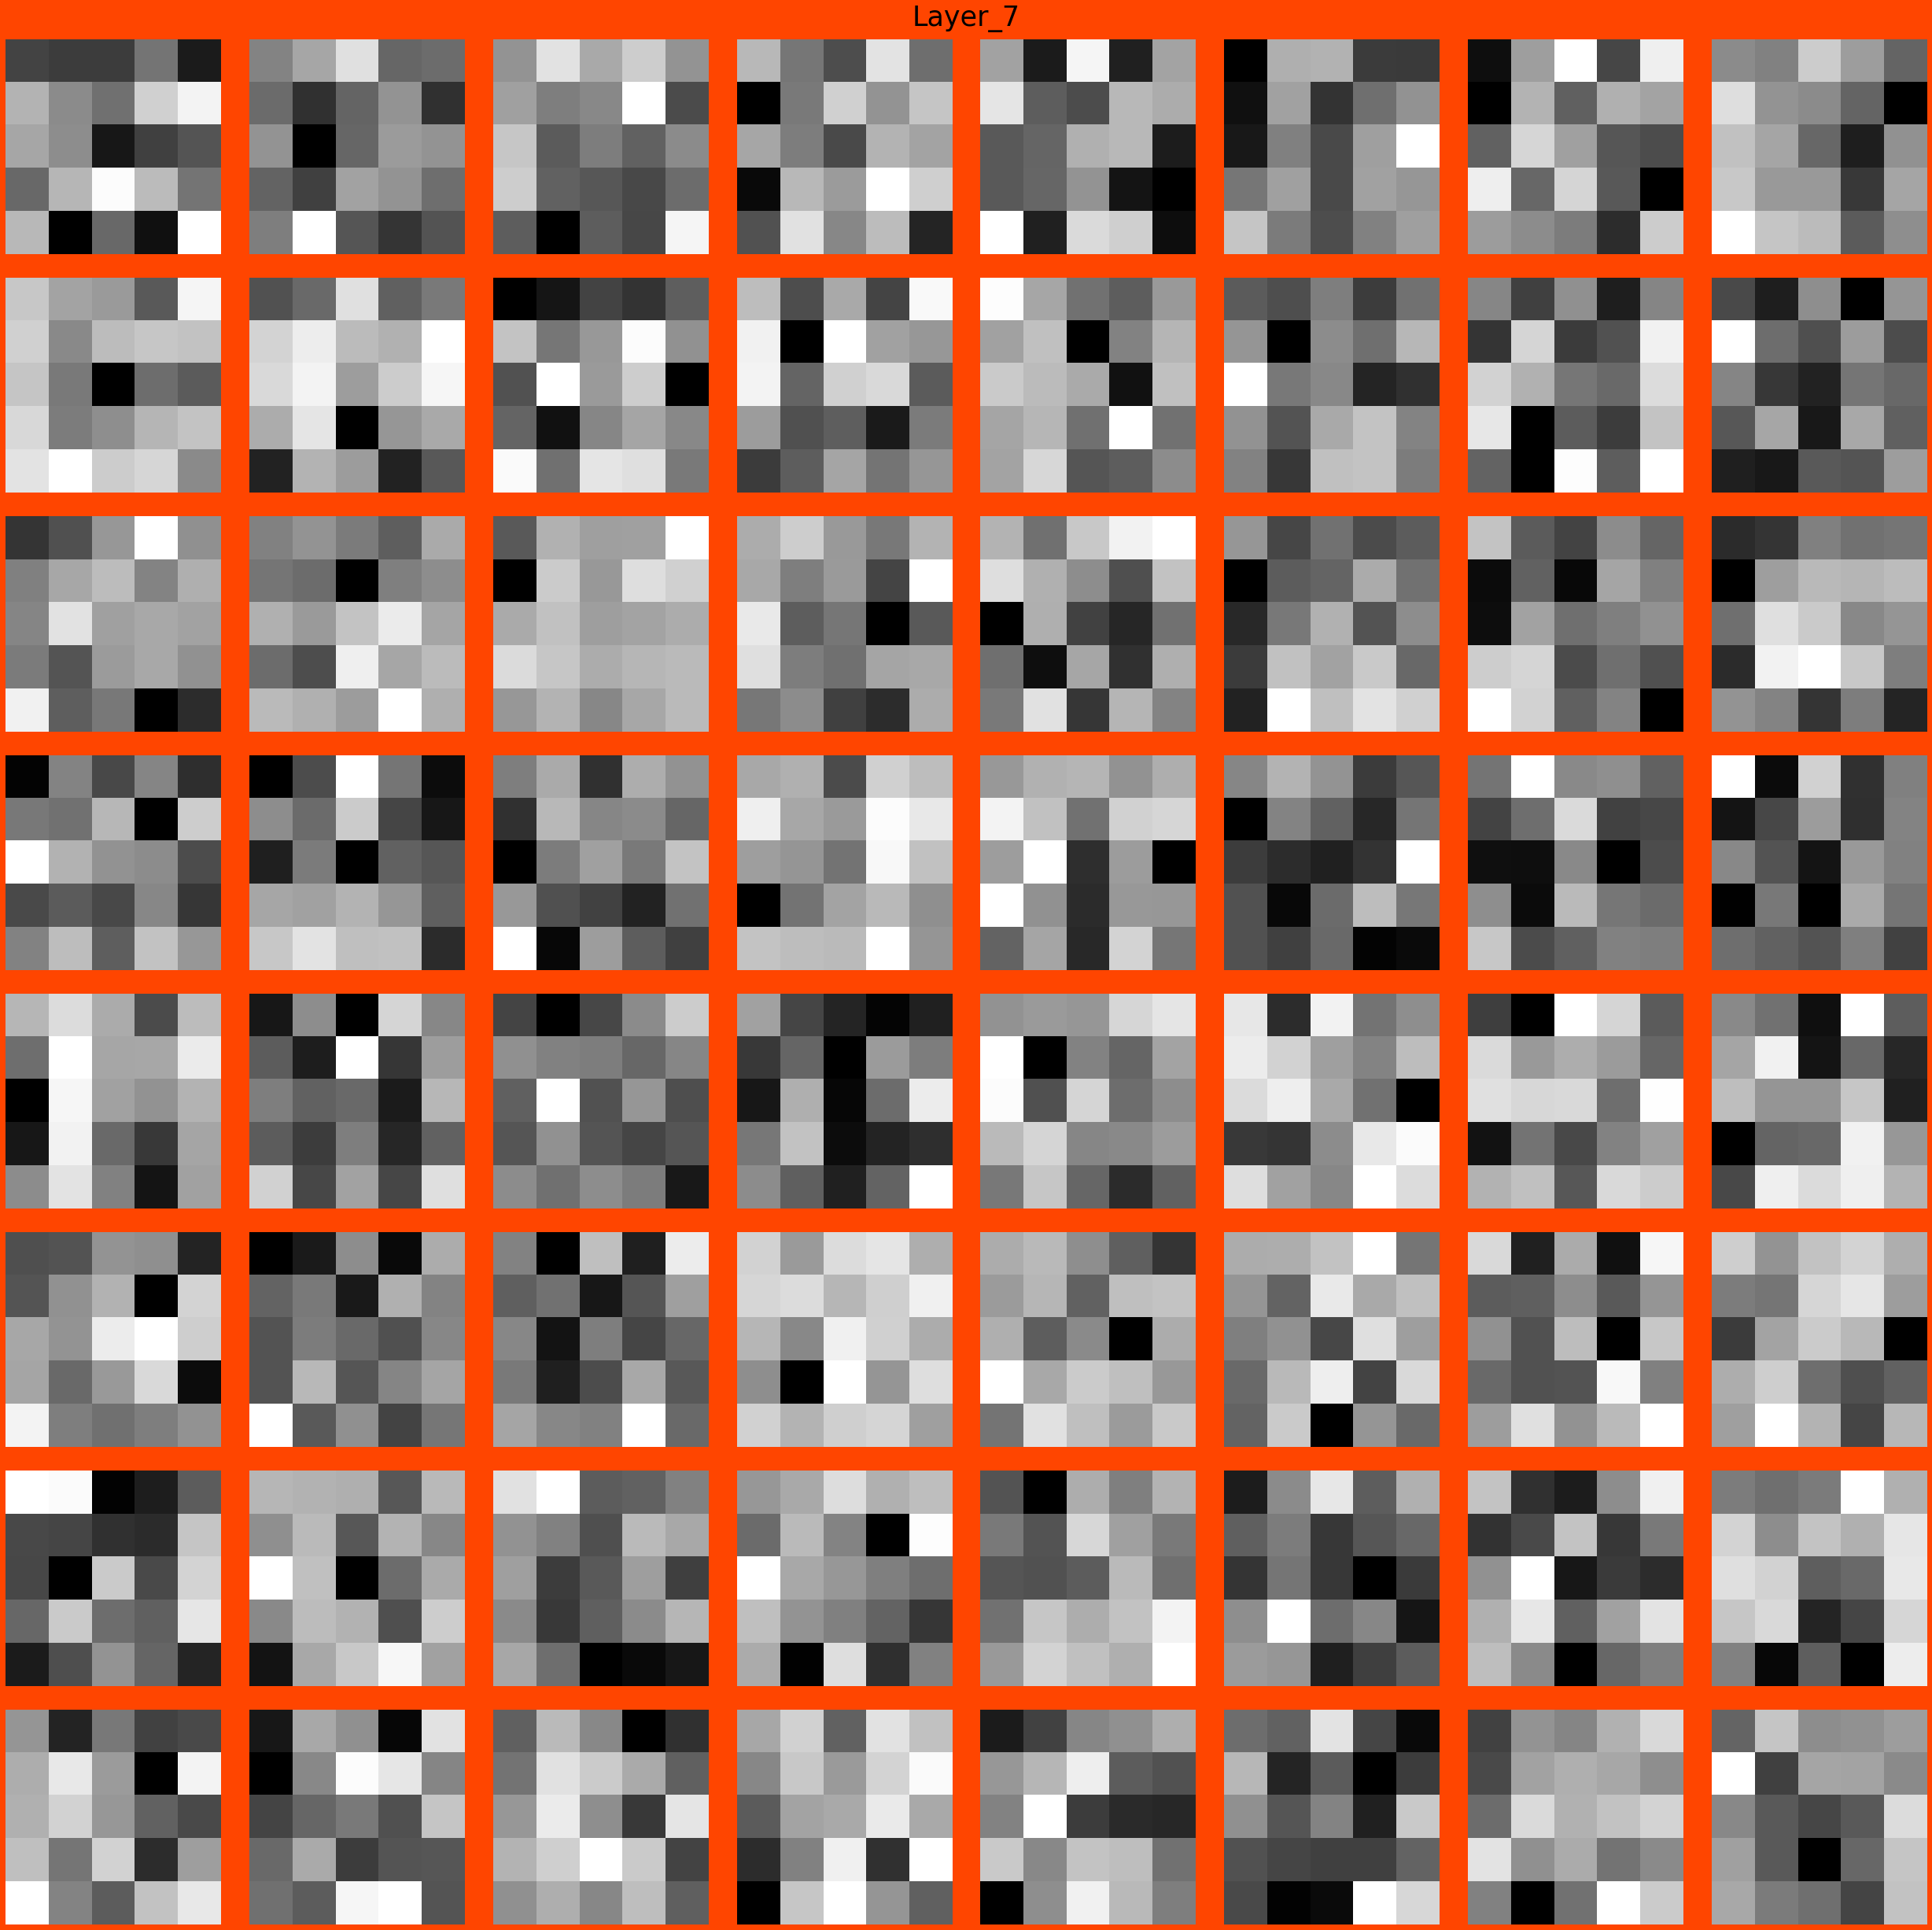

In [33]:
BestModel.extractFilters()

97 incorrect predictions made.


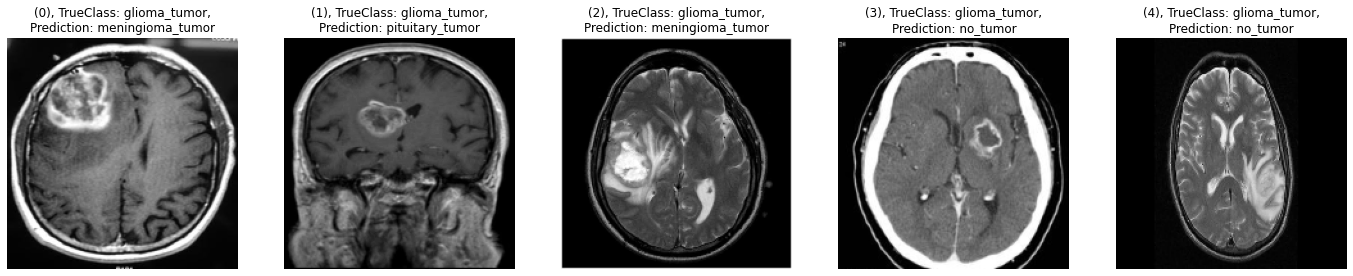

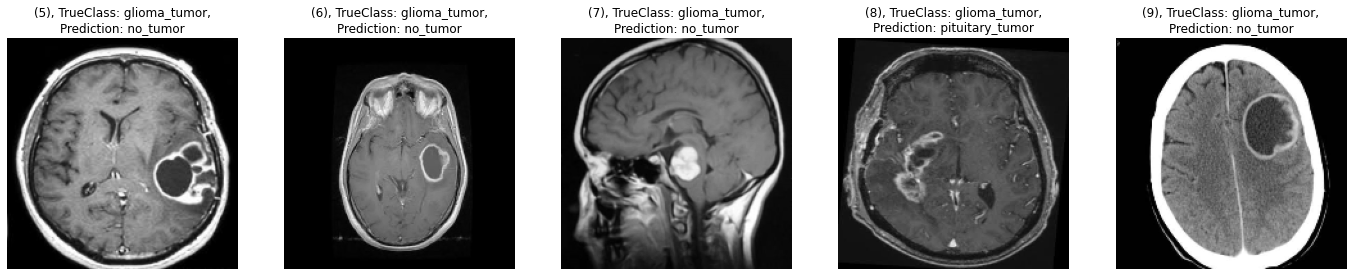

In [39]:
BestModel.showPredictions(tumours.x_test, tumours.y_test, max_out=10)

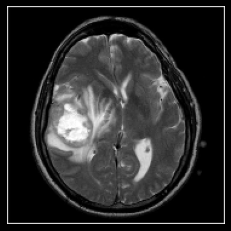

In [58]:
img = BestModel.falsePredictions[2][0]
imshow_(img)

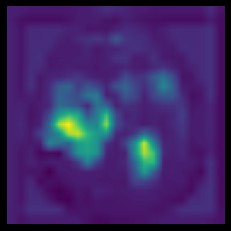

In [59]:
BestModel.getHeatMap(img)

####################################
# Features of convolutional layers #
####################################



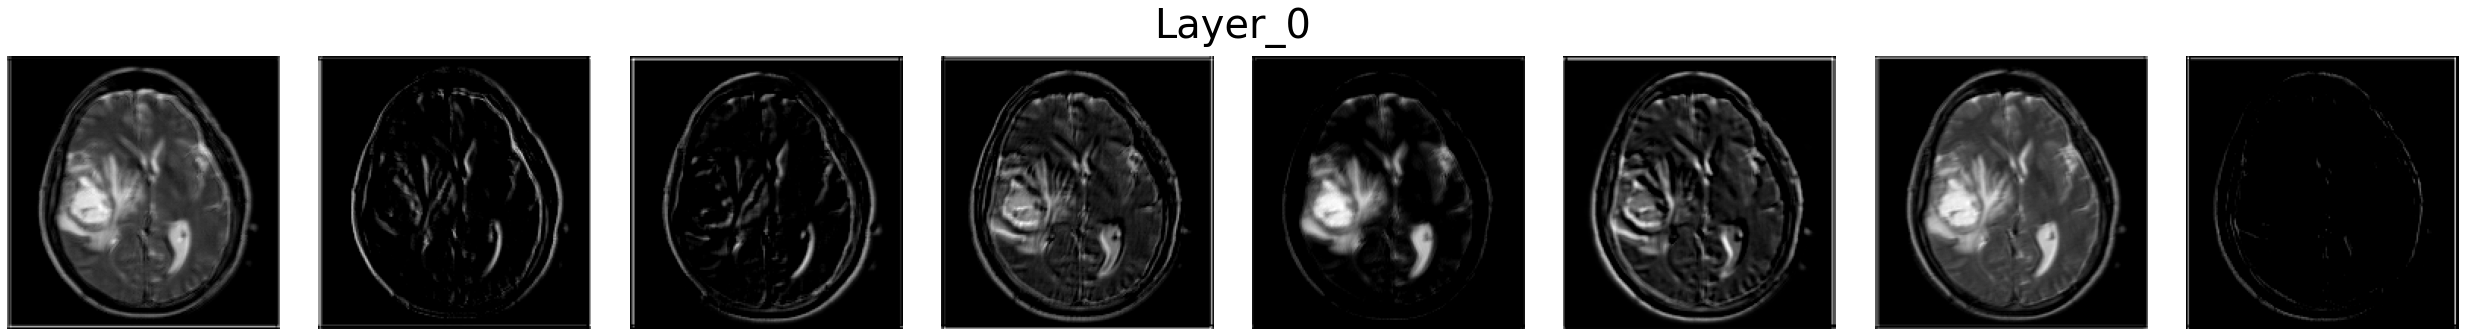

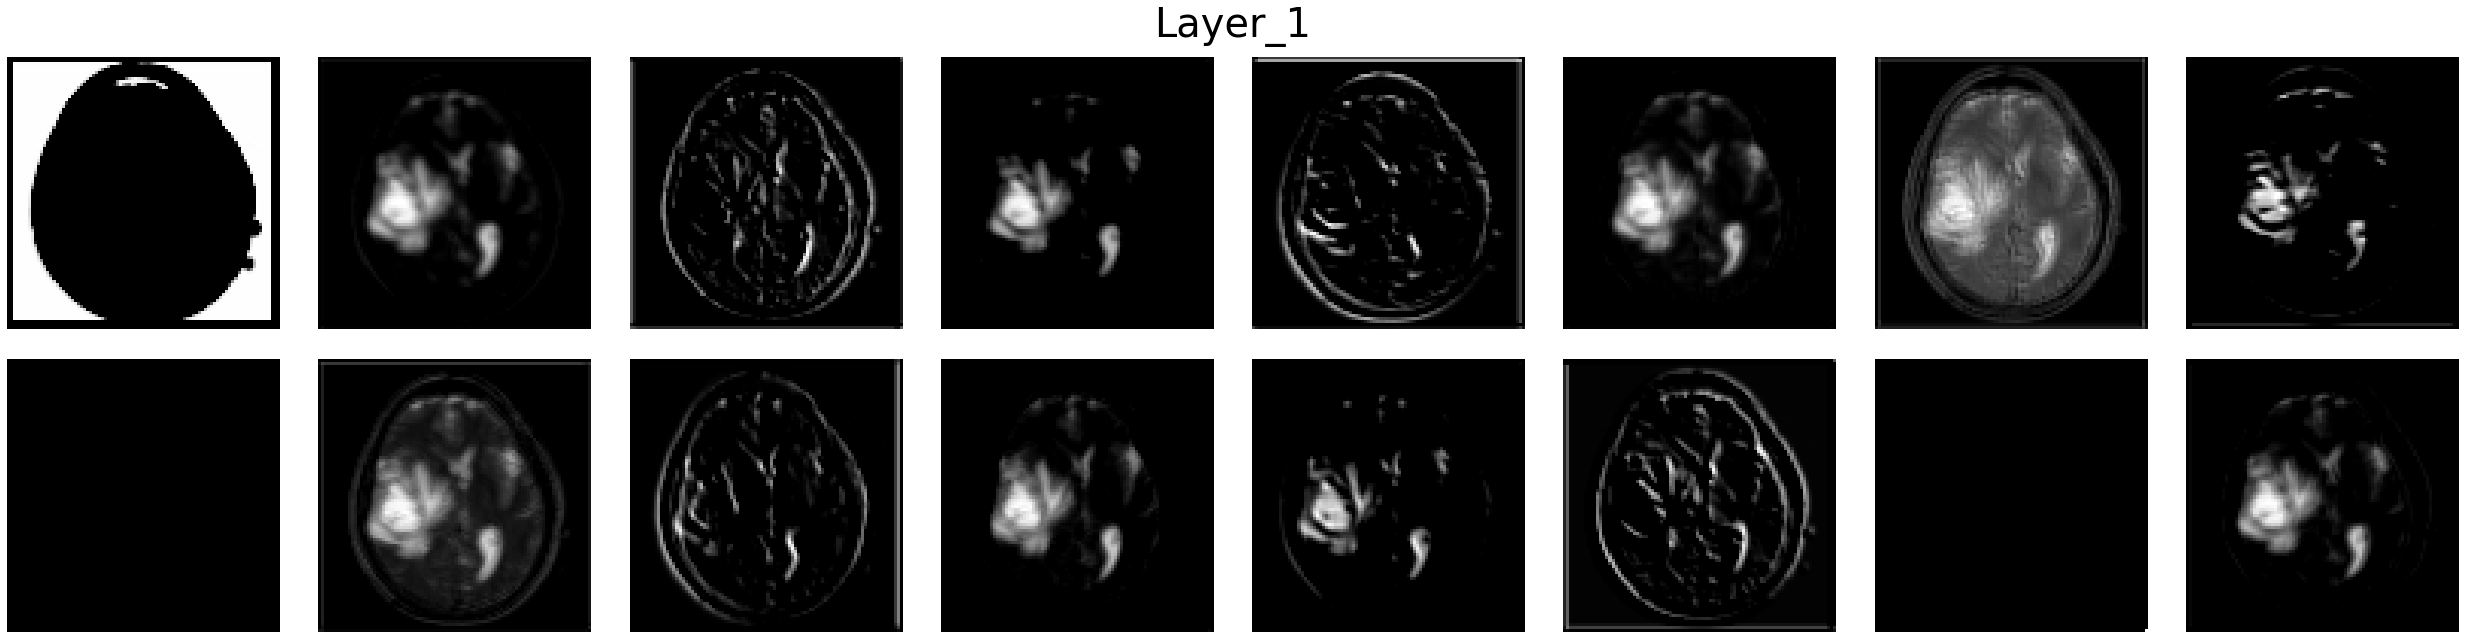

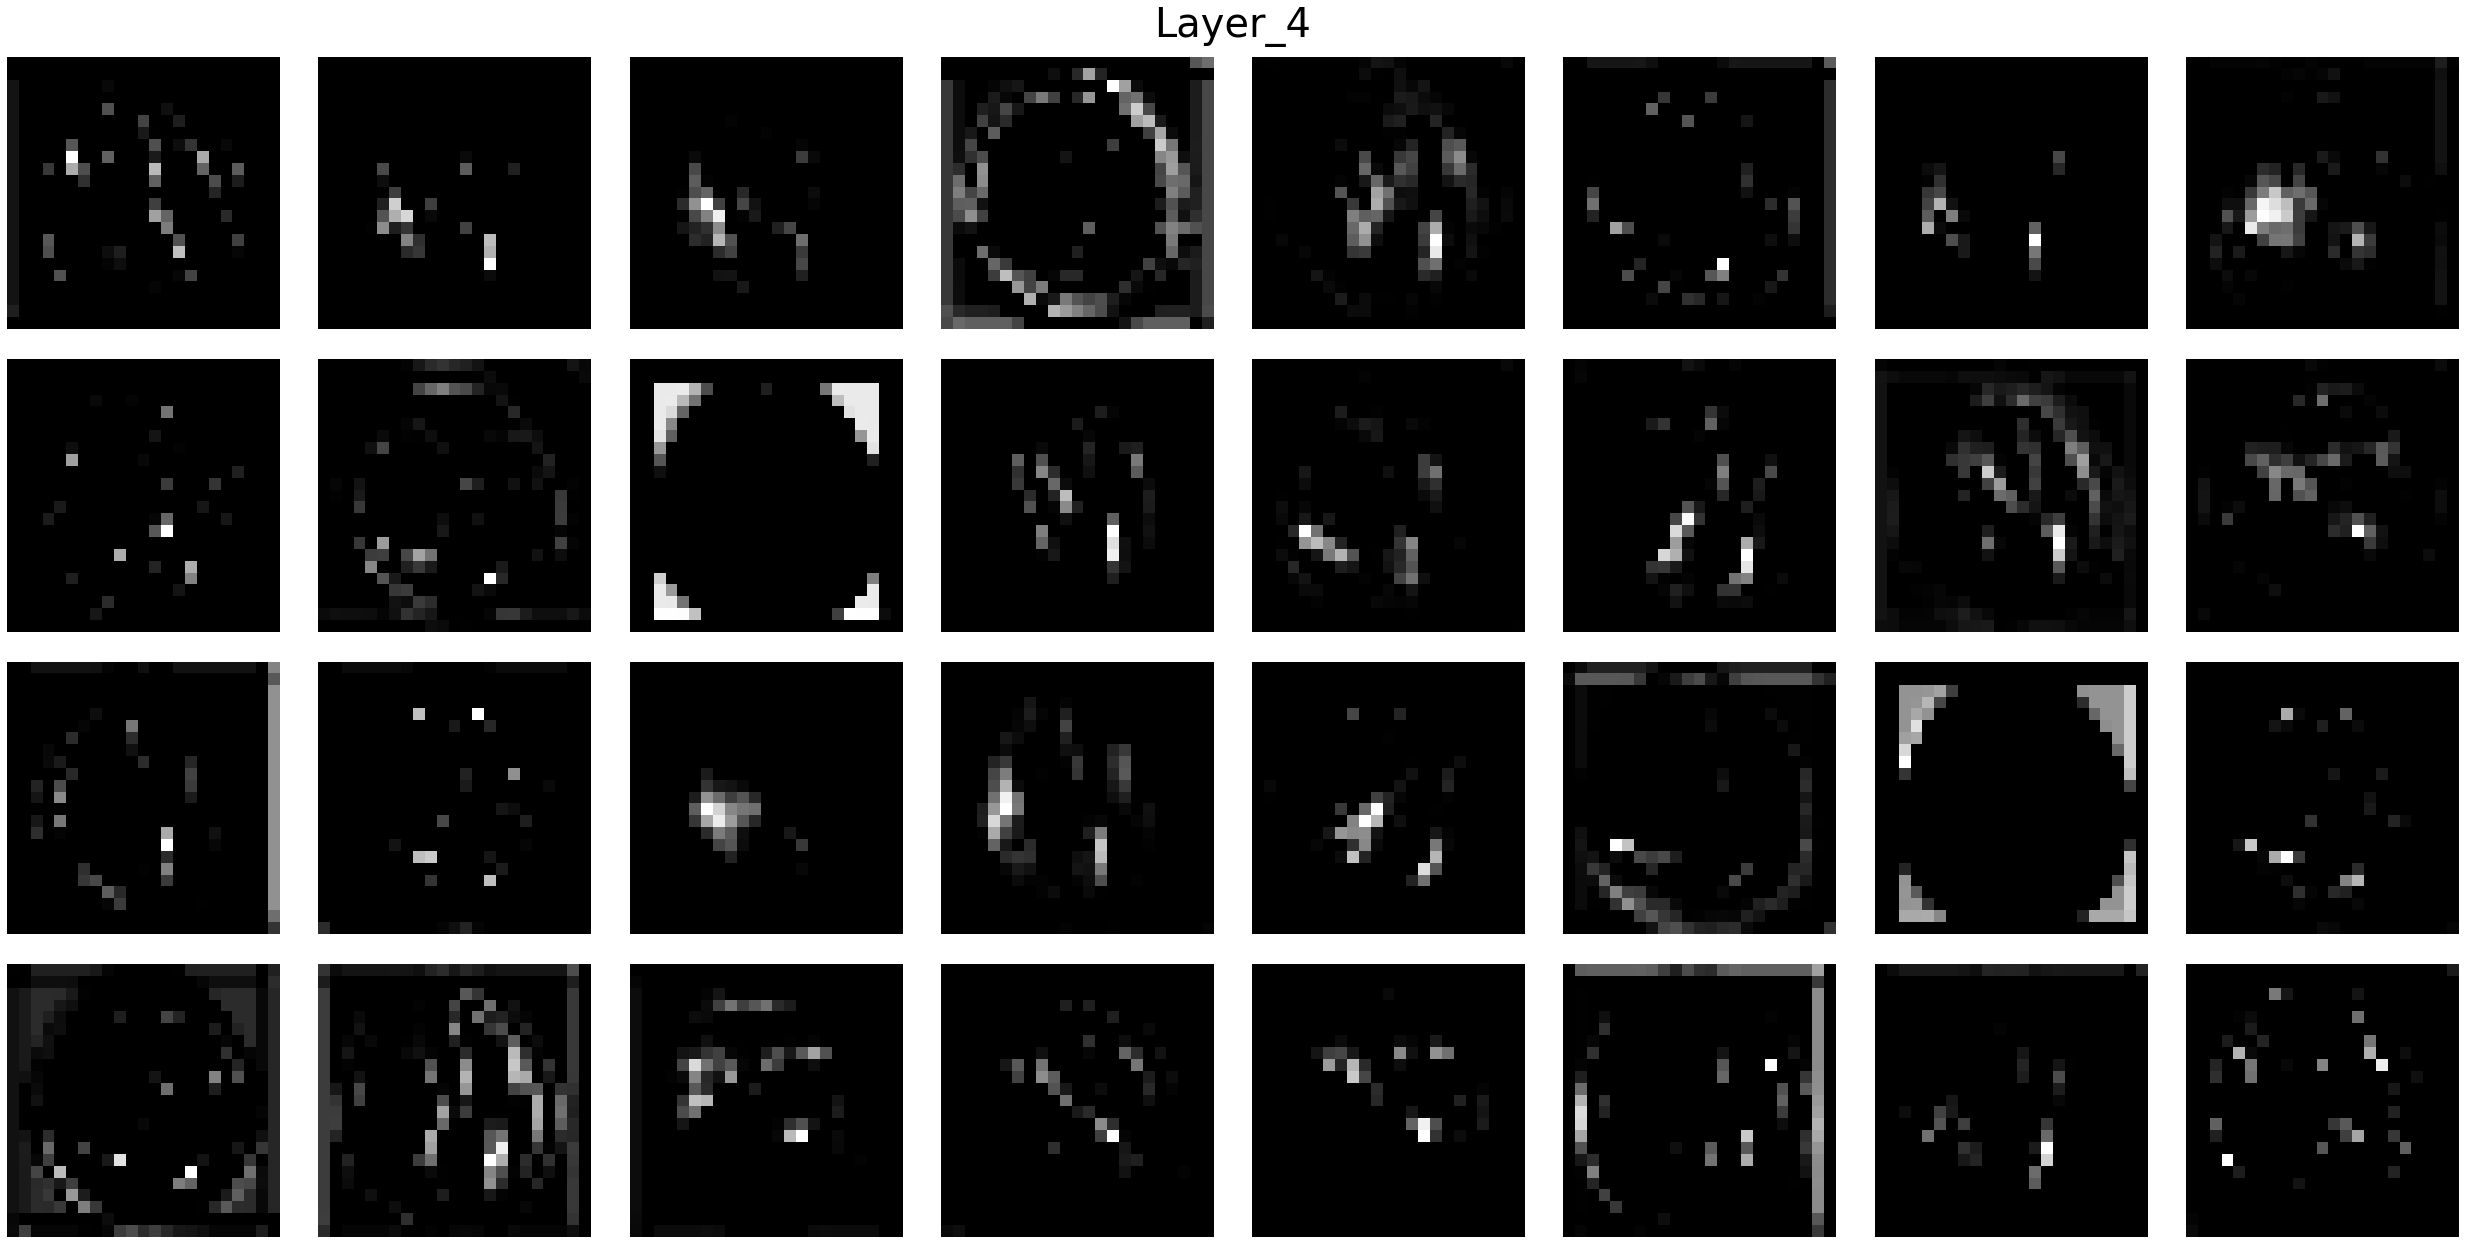

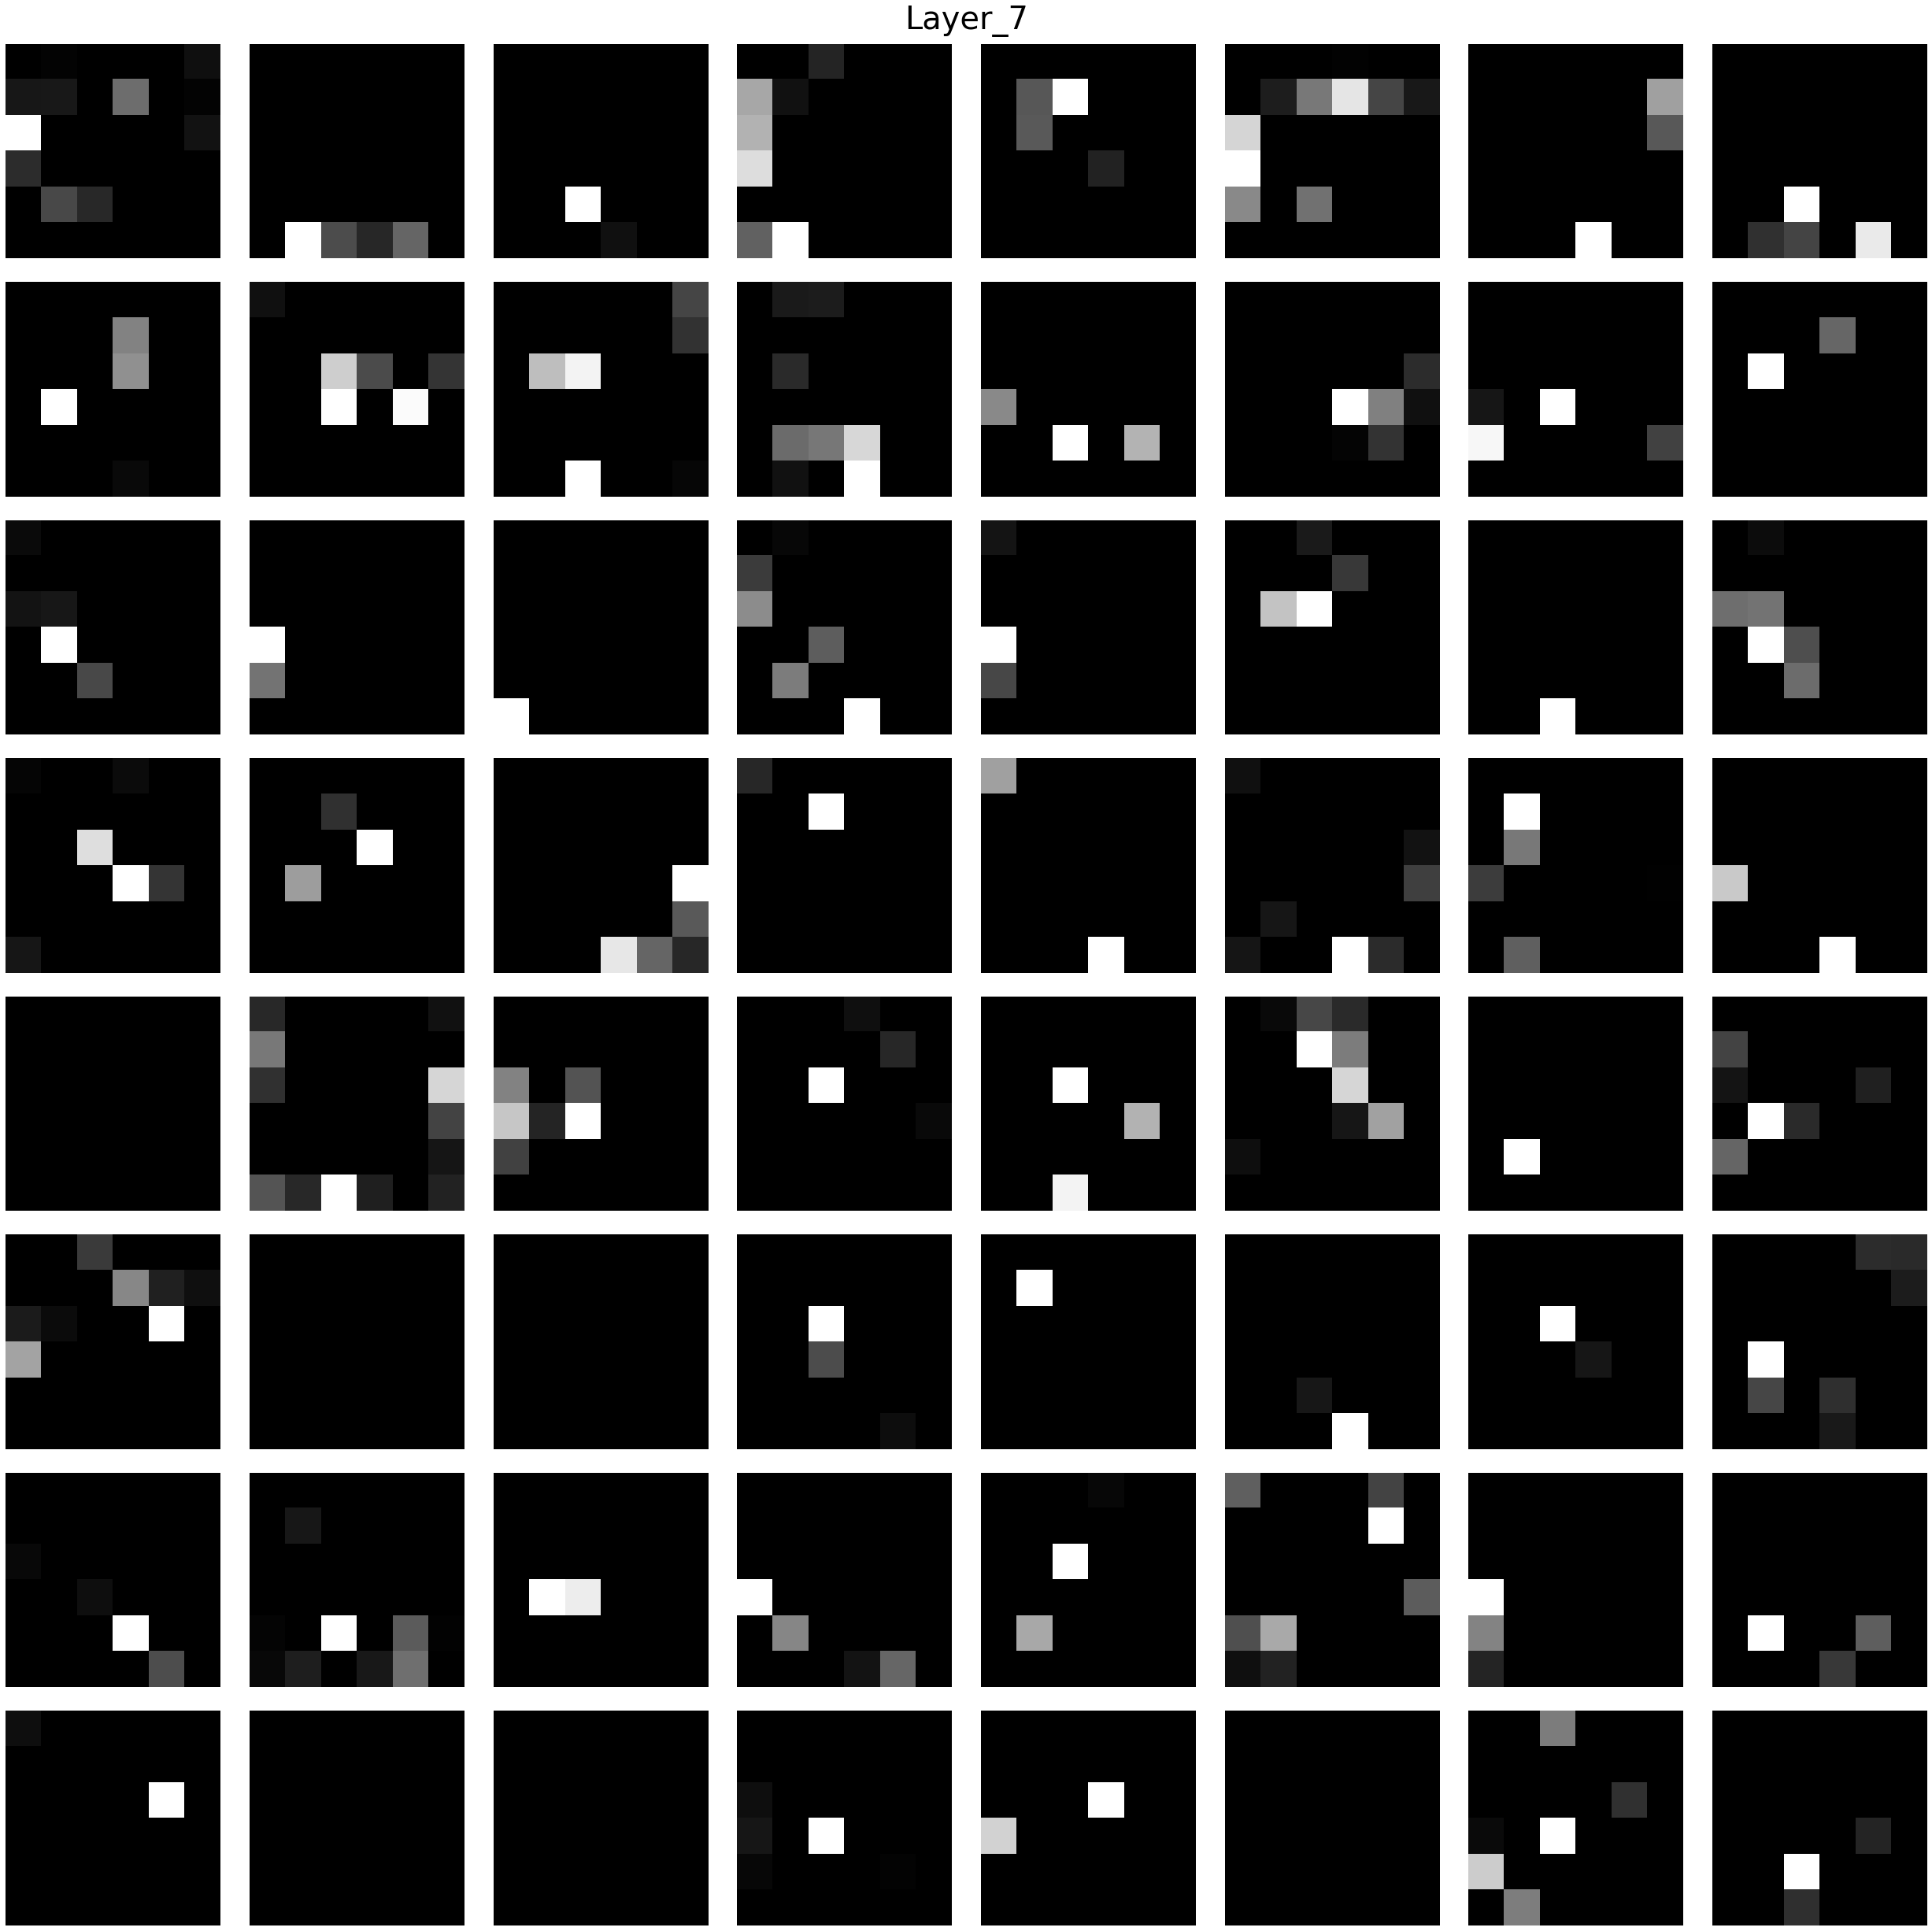

In [60]:
BestModel.showFeatureMaps(layer='conv', image=img)

297 correct predictions made.


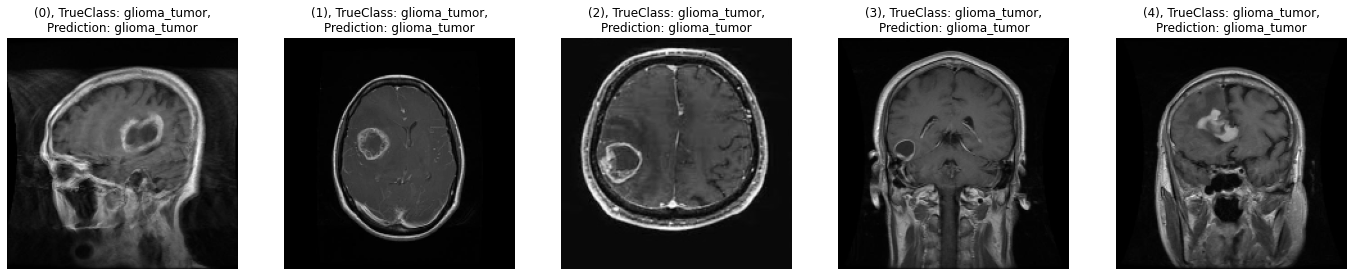

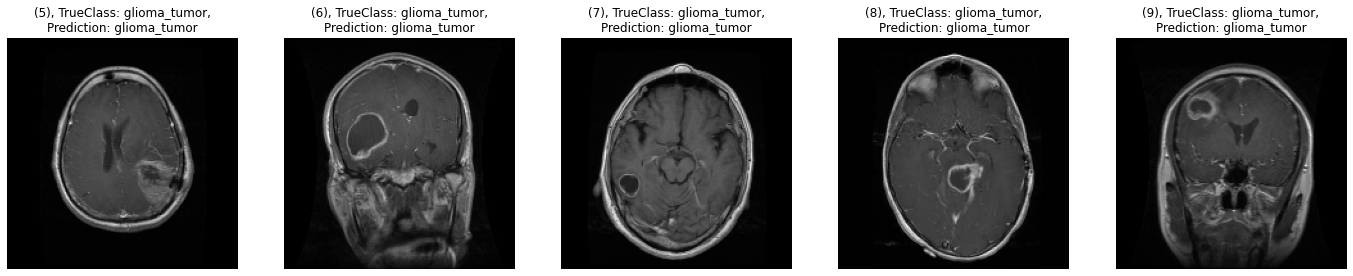

In [65]:
BestModel.showPredictions(tumours.x_test, tumours.y_test,
                          display_mode=1, max_out=10)

Actual glioma_tumor, Predicted glioma_tumor


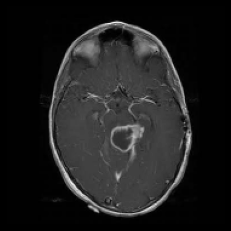

In [118]:
index = 8
img = BestModel.truePredictions[index][0]
print(f'Actual {Images.classes[BestModel.truePredictions[index][1]]}, ' \
      f'Predicted {Images.classes[BestModel.truePredictions[index][2]]}')
imshow_(img)

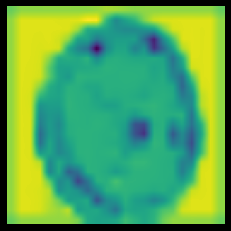

In [119]:
BestModel.getHeatMap(img)

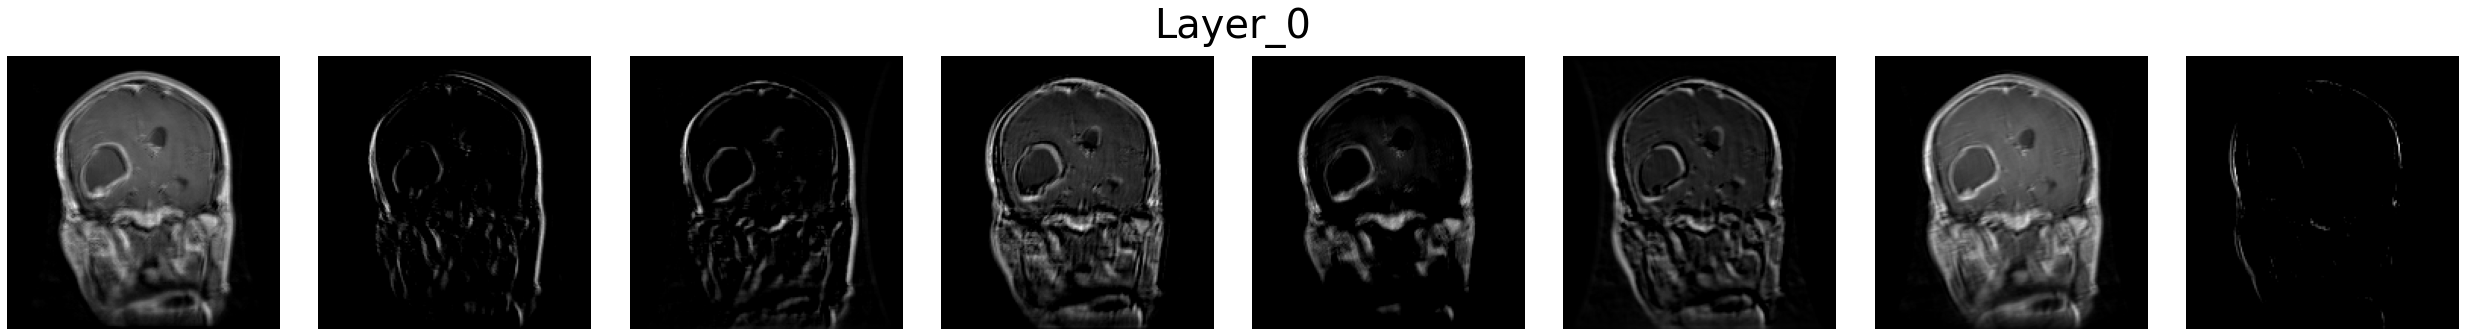

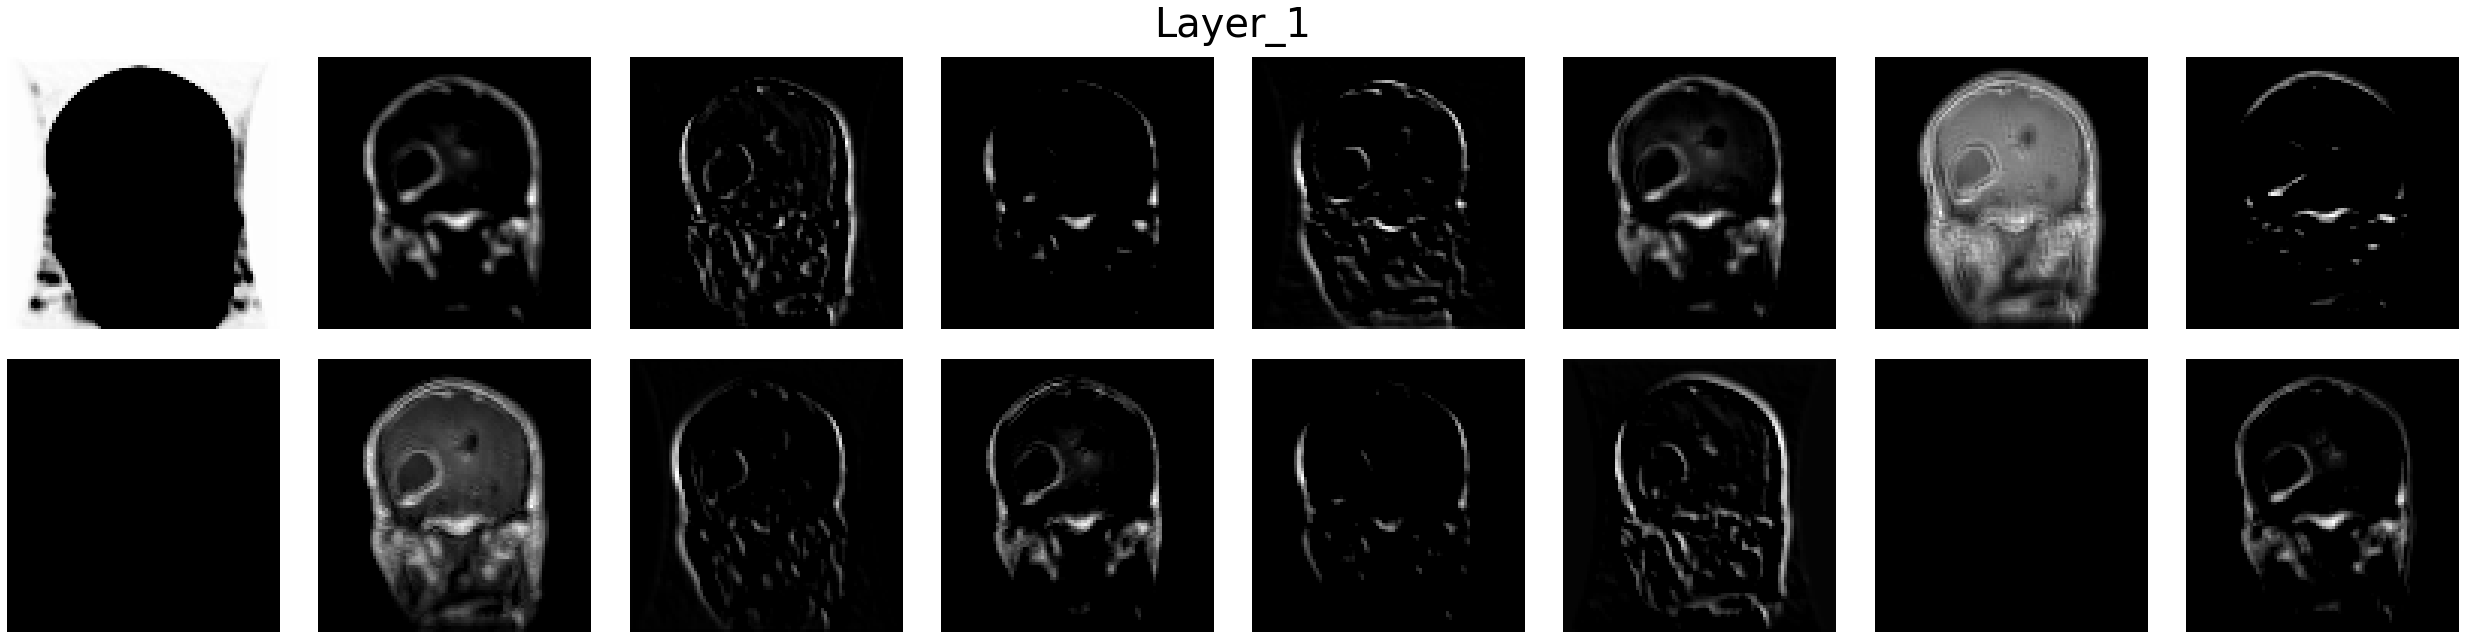

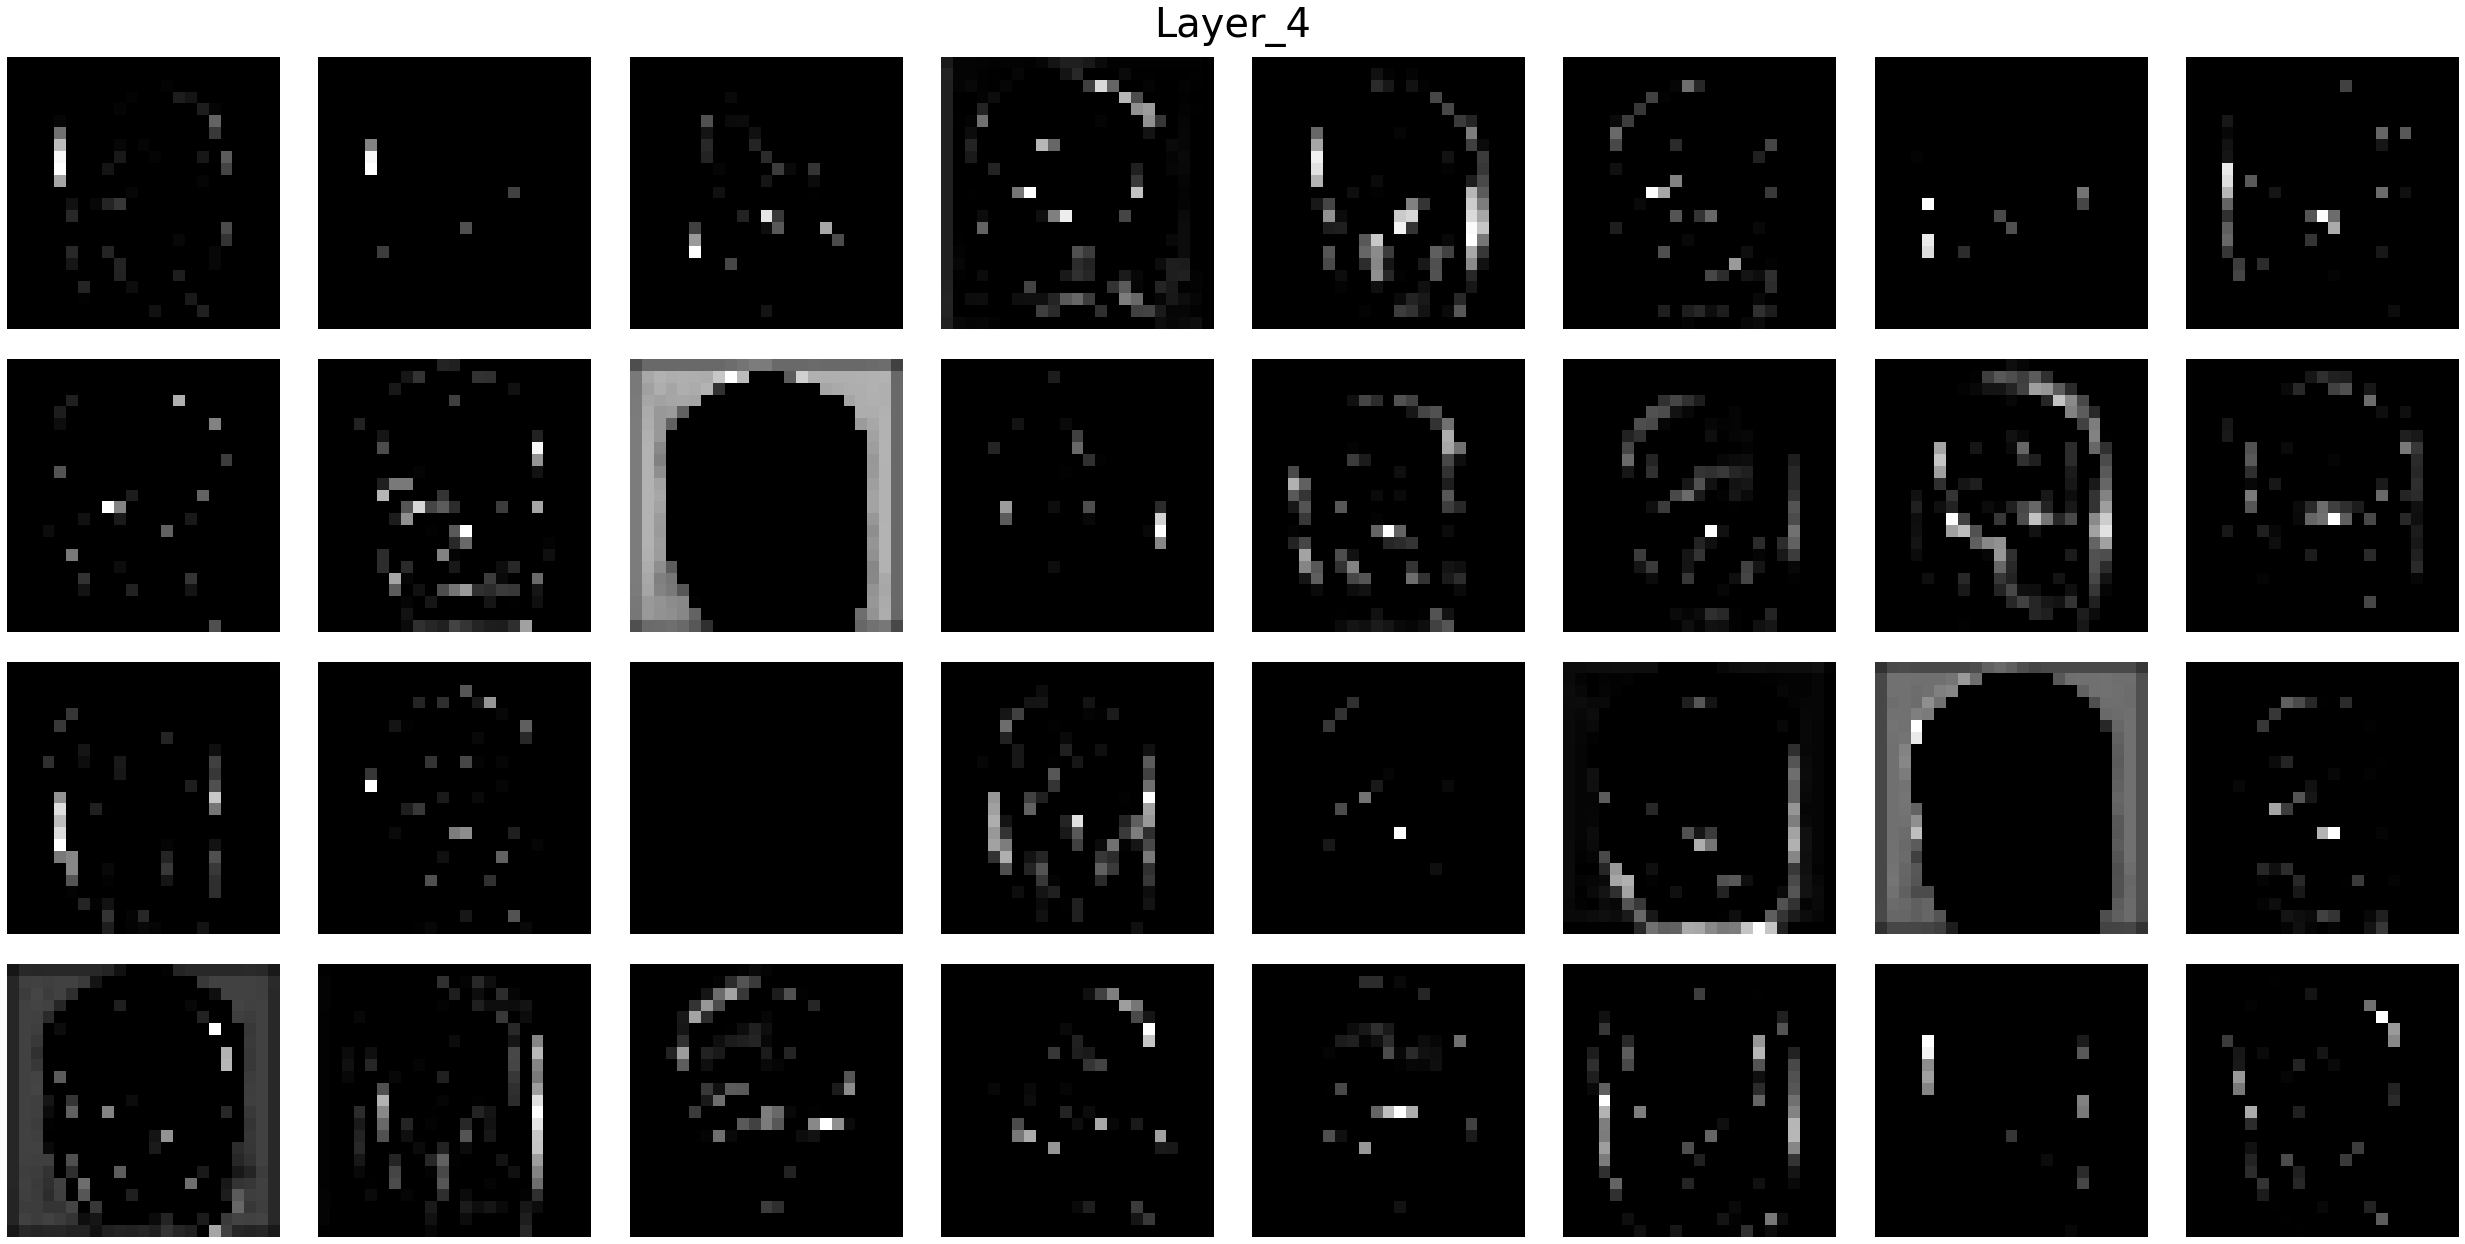

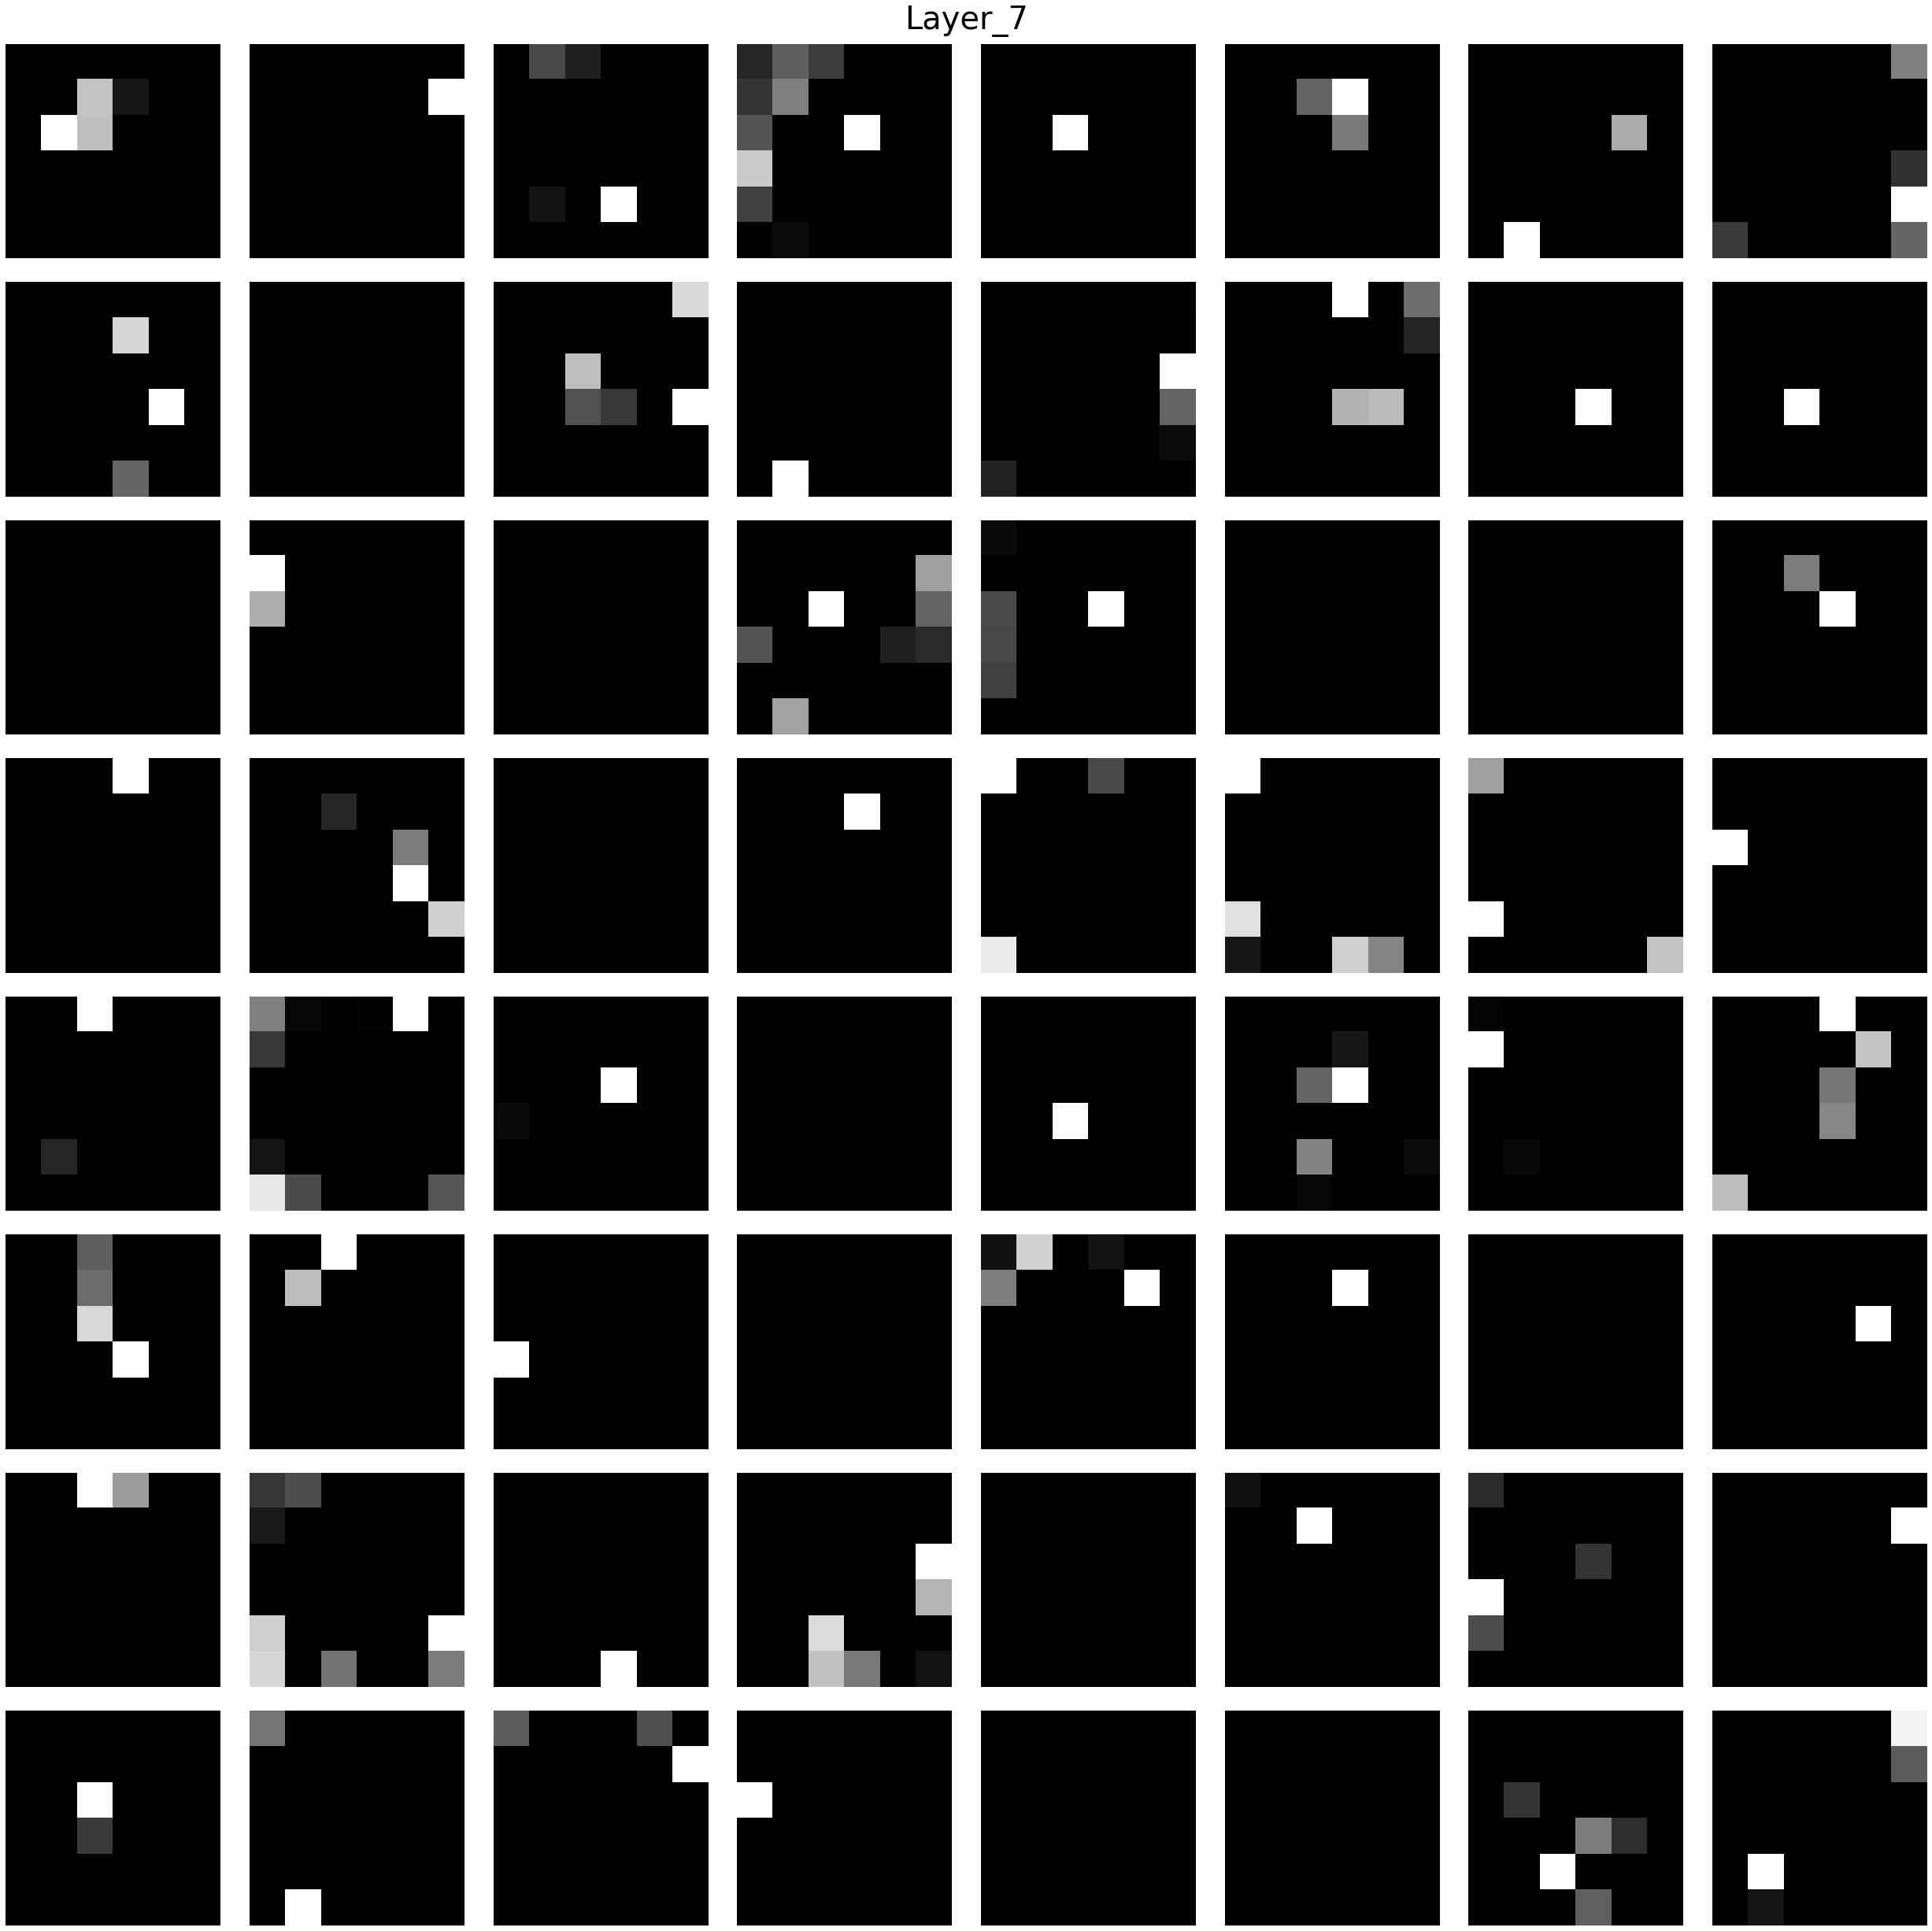

In [82]:
BestModel.showFeatureMaps(layer='conv', image=img)

#### Obtaining the biases for each convolutional layer

In [93]:
biases = [BestModel.classifier.layers[i].get_weights()[0]
                   for i in BestModel.convLayers]

(biases[0])

array([[[[ 0.11032452,  0.02674336,  0.11021057,  0.11167414,
          -0.05423085,  0.07923949,  0.04995477,  0.08258025]],

        [[-0.12644896, -0.01208451,  0.06240086, -0.01681026,
           0.10513106,  0.01805731, -0.07278135,  0.05015832]],

        [[ 0.08867714,  0.02740653,  0.05798344,  0.0123692 ,
           0.23232126,  0.27955854, -0.0366504 , -0.15701178]],

        [[ 0.06990145, -0.20033324,  0.14545125,  0.11487823,
          -0.10853466,  0.17434046, -0.07285373,  0.04494842]],

        [[-0.28526226, -0.05028714, -0.03257295,  0.04493892,
           0.23198448,  0.09018757,  0.10262106,  0.06833136]]],


       [[[-0.01022403,  0.03648948,  0.1573219 ,  0.05196427,
           0.214945  , -0.1471194 ,  0.07831474, -0.06626559]],

        [[ 0.09478939,  0.16970843,  0.04053416, -0.07444619,
          -0.03902824,  0.19588526,  0.2182563 ,  0.07186402]],

        [[ 0.02751726,  0.1403043 ,  0.04873953,  0.07911544,
           0.13906649,  0.24172084,  0.20198046

### 3. Can you use filters to improve the performance of your network?

From the heatmaps, we get a subtle idea about which feature is our model  
detecting for a certain class. We can apply data augmentation or pre-  
processing techniques to alter the images in a variety of ways so that a  
particular feature gets detected in an image.

### 4. Report

#### a) BaseModel Performance 
---

* BaseModel Architecture

![BaseModel architecture](./images/base-model.png)

* Performance on the validation set

![Performance on validation set](./images/base-model-performance-on-validation.png)

* Performance on the test set

![Performance on test set](./images/base-model-performance-on-test-set.png)
<!-- projects/tumor_classification/images/base-model-performance-on-validation.png -->

#### b) Hyperparameter tuning Phase I results. 
---
The following table presents a summary of parameters used and the reulsts they
led to results.

| #epochs | depth | Batch_size | filters |strides| kernel_size| Activation | Optimizer | learning_rate | val_acc | Remarks                                  |
|:-------:|:-----:|:----------:|:-------:|:-----:|:----------:|------------|:---------:|:-------------:|:-------:|:----------------------------------------|
| 10      | 3     | 32         | 8       |1      | 3          | ReLU       | Adam      | 0.001         | 0.76    | Base Model, Image size was 128,128       |
| 10      | 3     | 16         | 8       |1      | 3          | ReLU       | Adam      | 0.001         | 0.79    |                                          |
| 10      | 3     | 8          | 8       |1      | 3          | ReLU       | Adam      | 0.001         | 0.81    |                                          |
| 10      | 3     | 64         | 8       |1      | 3          | ReLU       | Adam      | 0.001         | 0.76    |                                          |
| 20      | 2     | 64         | 8       |1      | 3          | ReLU       | Adam      | 0.001         | 0.81    |                                          |
| 25      | 2     | 64         | 8       |1      | 3          | ReLU       | Adam      | 0.001         | 0.85    |                                          |
| 10      | 3     | 100        | 16      |1      | 3          | ReLU       | Adam      | 0.001         | 0.67    | Poor compared to smaller batch size.     |
| 15      | 3     | 32         | 64      |2      | 3          | ReLU       | Adam      | 0.001         | 0.87    |                                          |
| 25      | 3     | 32         | 64      |2      | 3          | ReLU       | Adam      | 0.001         | 0.89    |                                          |
| 15      | 3     | 32         | 8       |1      | 5          | ReLU       | Adam      | 0.001         | 0.86    |                                          |
| 15      | 3     | 32         | 4       |1      | 7          | ReLU       | Adam      | 0.001         | 0.27    | Kernel size should not be increased much |
| 30      | 3     | 32         | 16      |1      | 5          | ReLU       | SGD       | 0.1           | 0.84    | LR decayed exponentially                 |
|         |       |            |         |       |            |            |           |               |         |                                          |
| 30      | 3     | 32         | 20      |1      | 3          | ReLU       | SGD       | 0.1           | 0.85    | LR decayed exponentially, ImgSize (180)  |
| 30      | 3     | 128        | 24      |1      | 3          | ReLU       | SGD       | 0.9           | 0.72    | LR decayed exponentially                 |
| 40      | 3     | 32         | 16      |1      | 3          | ReLU       | SGD       | 0.2           | 0.85    | LR decayed exponentially                 |
| 10      | 4     | 32         | 8       |1      | 3          | ReLU       | Adam      | 0.0008        | 0.74    |                                          |
| 30      | 4     | 32         | 8       |1      | 3          | ReLU       | Adam      | 0.0009        | 0.82    |                                          |
| 20      | 4     | 32         | 32      |1      | 3          | ReLU       | Adam      | 0.0009        | 0.86    |                                          |
| 100     | 3     | 32         | 8       |1      | 4          | ReLU       | Adam      | 0.0008        | 0.89    |                                          |
| 100     | 3     | 64         | 8       |1      | 5          | ReLU       | Adam      | 0.0008        | 0.90    |                                          |
| 100*5   | 3     | 64         | 8       |1      | 5          | ReLU       | Adam      | 0.0008        | 1.00    | With dropouts                            |
| 100*3   | 3     | 64         | 8       |1      | 5          | ReLU       | Adam      | 0.0008        | 0.98    |                                          |
| 50      | 4     | 32         | 16      |2      | 3          | ReLU       | Adam      | 0.0008        | 0.89    | With dropouts                            |
| 30      | 4     | 32         | 32      |2      | 2          | ReLU       | Adam      | 0.0008        | 0.86    |                                          |
| 30      | 4     | 32         | 36      |1      | 5          | ReLU       | Adam      | 0.0008        | 0.87    | with weights and dropouts                |
| 35      | 3     | 32         | 36      |1      | 5          | ReLU       | Adam      | 0.0008        | 0.90    | with weights and dropouts                |
| 40*4    | 3     | 32         | 36      |1      | 5          | ReLU       | Adam      | 0.0008        | 0.97    | with weights and dropouts                |
| 25      | 3     | 32         | 52      |1      | 4          | ReLU       | Adam      | 0.00009       | 0.79    | with weights                             |


#### c) CNN Filter Analysis
---

* Each convolution layer has different filters and each filter looks  
for a different feature in the image. The features are traced by the  
brighter pixels in the filtres, and appear as warmer temperature in  
the heatmap.

* The most problematic mis-classification was between the glioma and  
the meningioma tumors. The heatmap shows that those images which  
pertained to glioma tumour but were being misclassified as menigioma  
tumour had activations in the skull area. (Stripping the skull  
through segmentation might help).

* Also, some other incorrectly classified images had little to no  
detection of any feature as suggested in heatmaps. In contrast,  
correctly classified images had activations in most areas in the  
heatmap.

#### d) Final improvement results in your model after Phase I.
---

* BestModel Architecture

![BestModel architecture](./images/best-model.png)

* Performance on the validation set

![Performance on validation set](./images/best-model-performance-on-validation.png)

* Performance on the test set

![Performance on test set](./images/best-model-performance-on-test-set.png)

In [100]:
%%bash
# Runtime Environment
python --version
neofetch | grep 'CPU\|GPU'

Python 3.10.4
CPU: Intel i7-8550U (8) @ 4.000GHz 
GPU: NVIDIA GeForce 940MX 
GPU: Intel UHD Graphics 620 
